<a href="https://www.kaggle.com/code/w1ndness/data-analysis-07-lstm?scriptVersionId=109306828" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [246]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/electrical-energy-load/test/1.csv
/kaggle/input/electrical-energy-load/test/3.csv
/kaggle/input/electrical-energy-load/test/.pdf
/kaggle/input/electrical-energy-load/test/2-1.csv
/kaggle/input/electrical-energy-load/test/2-2.csv
/kaggle/input/electrical-energy-load/train/1.csv
/kaggle/input/electrical-energy-load/train/3.csv
/kaggle/input/electrical-energy-load/train/2.csv


In [247]:
from matplotlib import pyplot as plt
import seaborn as sns

In [248]:
!nvidia-smi

Thu Oct 27 14:48:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    34W / 250W |   2220MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Question 1

In [249]:
!rm -f model*

In [250]:
train_data = pd.read_csv('/kaggle/input/electrical-energy-load/train/1.csv')
test_data = pd.read_csv('/kaggle/input/electrical-energy-load/test/1.csv', encoding='gb2312')

In [251]:
train_data.head()

,数据时间,总有功功率（kw）
0,2018/1/1 00:00:00,244033.7682
1,2018/1/1 00:15:00,232720.6402
2,2018/1/1 00:30:00,231685.6891
3,2018/1/1 00:45:00,227581.3317
4,2018/1/1 01:00:00,233482.4269


In [252]:
train_data.columns = ['Date', 'Power']
train_data.head()

,Date,Power
0,2018/1/1 00:00:00,244033.7682
1,2018/1/1 00:15:00,232720.6402
2,2018/1/1 00:30:00,231685.6891
3,2018/1/1 00:45:00,227581.3317
4,2018/1/1 01:00:00,233482.4269


In [253]:
train_data.shape

(128156, 2)

In [254]:
train_data['Date'] = pd.to_datetime(train_data['Date'])
grouper = pd.Grouper(key='Date', freq='15min')
train_data = train_data.groupby(grouper).first()
train_data.head()

,Power
Date,
2018-01-01 00:00:00,244033.7682
2018-01-01 00:15:00,232720.6402
2018-01-01 00:30:00,231685.6891
2018-01-01 00:45:00,227581.3317
2018-01-01 01:00:00,233482.4269


In [255]:
train_data.shape

(128544, 1)

In [256]:
train_data.isnull().sum()

Power    388
dtype: int64

In [257]:
train_data['Power'] = train_data['Power'].interpolate()
train_data.isnull().sum()

Power    0
dtype: int64

In [258]:
train_data.to_csv('15min_freq.csv')

<AxesSubplot:xlabel='Date', ylabel='Power'>

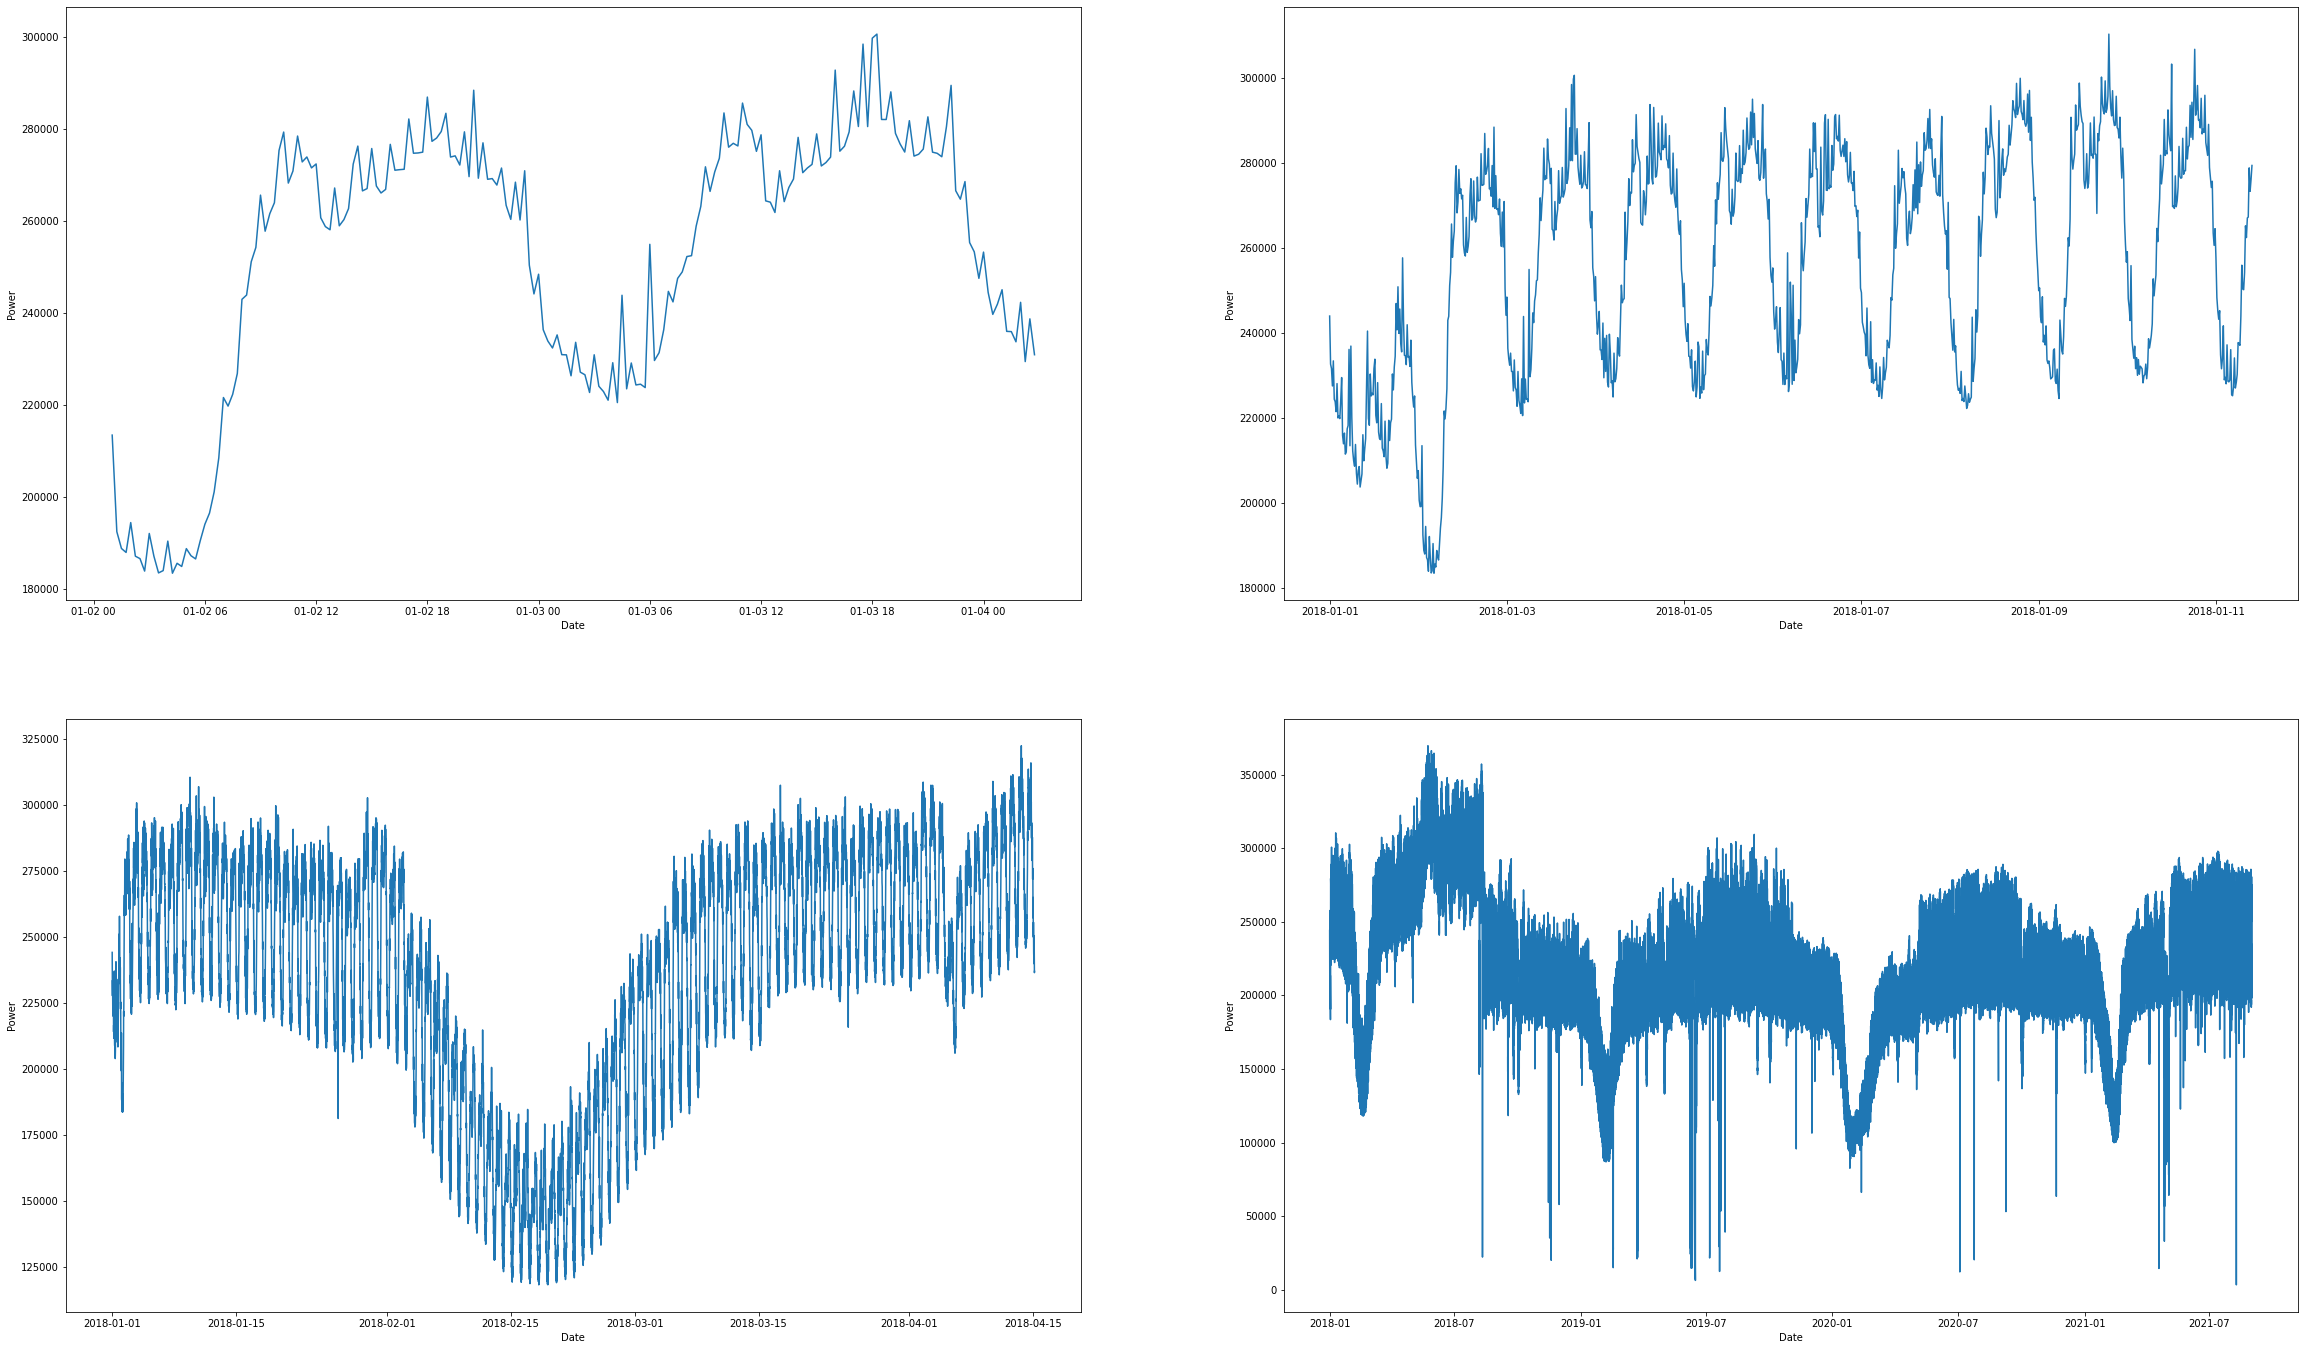

In [259]:
fig, ax = plt.subplots(2, 2, figsize=(40, 24))
sns.lineplot(data=train_data[100:300], x='Date', y='Power', ax=ax[0][0])
sns.lineplot(data=train_data[:1000], x='Date', y='Power', ax=ax[0][1])
sns.lineplot(data=train_data[:10000], x='Date', y='Power', ax=ax[1][0])
sns.lineplot(data=train_data, x='Date', y='Power', ax=ax[1][1])

In [260]:
def split_dataset(data, train_size=.8, valid_size=.1):
    data_size = len(data)
    X_train = data[:int(data_size * train_size)].copy()
    X_valid = data[int(data_size * train_size):int(data_size * train_size) + int(data_size * valid_size)].copy()
    X_test = data[int(data_size * train_size) + int(data_size * valid_size):].copy()
    return X_train, X_valid, X_test

In [261]:
train_bin, valid_bin, test_bin = split_dataset(train_data)

In [262]:
from sklearn.preprocessing import MinMaxScaler

train_scaler = MinMaxScaler()
valid_scaler = MinMaxScaler()
test_scaler = MinMaxScaler()

train_bin = train_scaler.fit_transform(train_bin)
valid_bin = valid_scaler.fit_transform(valid_bin)
test_bin = test_scaler.fit_transform(test_bin)

In [263]:
import torch
from torch.utils.data import DataLoader, TensorDataset

def preprocessing(data, window_size, predict_size):
    X, y = [], []
    for i in range(len(data) - window_size - predict_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size:i + window_size + predict_size].ravel())
    X = torch.FloatTensor(np.array(X))
    y = torch.FloatTensor(np.array(y))
    return X, y

In [264]:
window_size, predict_size = 96, 1

X_train, y_train = preprocessing(train_bin, window_size, predict_size)
X_valid, y_valid = preprocessing(valid_bin, window_size, predict_size)
X_test, y_test = preprocessing(test_bin, window_size, predict_size)

train_data = TensorDataset(X_train, y_train)
valid_data = TensorDataset(X_valid, y_valid)
test_data = TensorDataset(X_test, y_test)

In [265]:
X_train.shape, X_valid.shape, X_test.shape

(torch.Size([102738, 96, 1]),
 torch.Size([12757, 96, 1]),
 torch.Size([12758, 96, 1]))

In [266]:
USE_MULTI_GPU = False

if USE_MULTI_GPU and torch.cuda.device_count() > 1:
    MULTI_GPU = True
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1"
    device_ids = [0, 1]
else:
    MULTI_GPU = False

num_gpus = 2 if MULTI_GPU else 1    
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [267]:
batch_size = 128
train_loader = DataLoader(train_data, batch_size=batch_size * num_gpus,
                          shuffle=True, num_workers=2,
                          drop_last=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size * num_gpus,
                          shuffle=True, num_workers=2,
                          drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size * num_gpus,
                          shuffle=True, num_workers=2,
                          drop_last=True)

In [268]:
from torch import nn
from torch.nn import functional as F

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size,
                 num_layers, output_size, batch_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_size = batch_size
        self.num_directions = 1
        self.lstm = nn.LSTM(self.input_size, self.hidden_size,
                            self.num_layers, batch_first=True)
        self.linear = nn.Linear(self.hidden_size, self.output_size)
#         self.reg = nn.Sequential(nn.Linear(self.hidden_size, self.hidden_size // 2),
#                                  nn.ReLU(),
#                                  nn.Linear(self.hidden_size // 2, self.output_size))
#         self.fc1 = nn.Linear(self.hidden_size, self.hidden_size // 2)
#         self.fc2 = nn.Linear(self.hidden_size // 2, self.hidden_size // 4)
#         self.fc3 = nn.Linear(self.hidden_size // 4, self.output_size)
    
    def forward(self, X):
        h_0 = torch.randn(self.num_directions * self.num_layers, self.batch_size, self.hidden_size).to(device)
        c_0 = torch.randn(self.num_directions * self.num_layers, self.batch_size, self.hidden_size).to(device)
        output, _ = self.lstm(X, (h_0, c_0))
#         print(output.shape)
        o = output[:, -1, :]
#         pred = self.reg(o)
        pred = self.linear(o)
        return pred

In [269]:
from tqdm import tqdm

def train(params, train_loader, valid_loader, path):
    input_size = params['input_size']
    hidden_size = params['hidden_size']
    num_layers = params['num_layers']
    output_size = params['output_size']
    lr = params['learning_rate']
    wd = params['weight_decay']
    step_size = params['step_size']
    gamma = params['gamma']
    epochs = params['epochs']
    train_loss, valid_loss = [], []
    min_valid_loss = np.inf
    
    model = LSTM(input_size, hidden_size, num_layers, output_size, batch_size)
    print(model)
    if MULTI_GPU:
        model = nn.DataParallel(model, device_ids=device_ids)
    model.to(device)
    
    loss = nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size,
                                                gamma=gamma)
    if MULTI_GPU:
        optimizer = nn.DataParallel(optimizer, device_ids=device_ids)
        scheduler = nn.DataParallel(scheduler, device_ids=device_ids)
        
    for epoch in tqdm(range(epochs)):
        train_ls, valid_ls = [], []
        
        model.train()
        for step, (X, y) in enumerate(train_loader):
            optimizer.zero_grad()
            X = X.to(device)
            y = y.to(device)
            y_hat = model(X)
#             if step == 0:
#                 print(y_hat, y)
            l = loss(y_hat, y)
            train_ls.append(l.item())
            l.backward()
            optimizer.step()
            if step % 100 == 0:
                print("Step {}, train loss {:.6f}".format(step, l.item()))
        train_loss.append(np.mean(train_ls))
        
        model.eval()
        for step, (X, y) in enumerate(valid_loader):
            X = X.to(device)
            y = y.to(device)
            with torch.no_grad():
                y_hat = model(X)
#                 print(y_hat)
            l = loss(y_hat, y)
            valid_ls.append(l.item())
        valid_loss.append(np.mean(valid_ls))
        if valid_loss[-1] < min_valid_loss:
            state = {'model': model.state_dict()}
            torch.save(state, path)
            print('New best performance... Save new model checkpoint.')
            min_valid_loss = valid_loss[-1]
        
        print('Epoch [{:d}/{:d}], train loss {:.6f}, valid loss {:.6f}. Now best: {:.6f}'.format(
                epoch + 1, epochs, train_loss[-1], valid_loss[-1], min_valid_loss))
        scheduler.step()
    
    return train_loss, valid_loss


In [270]:
params = {'input_size': 1,
          'hidden_size': 64,
          'output_size': predict_size,
          'num_layers': 2, 
          'learning_rate': 0.1,
          'weight_decay': 1e-3,
          'step_size': 2,
          'gamma': 0.1,
          'epochs': 50}

In [271]:
train_loss, valid_loss = train(params, train_loader, valid_loader, 'model.pth')

LSTM(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)


  0%|          | 0/50 [00:00<?, ?it/s]

Step 0, train loss 0.474748
Step 100, train loss 0.019021
Step 200, train loss 0.021142
Step 300, train loss 0.014970
Step 400, train loss 0.018038
Step 500, train loss 0.021682
Step 600, train loss 0.015978
Step 700, train loss 0.016014
Step 800, train loss 0.018749


  2%|▏         | 1/50 [00:08<06:48,  8.34s/it]

New best performance... Save new model checkpoint.
Epoch [1/50], train loss 0.037586, valid loss 0.031975. Now best: 0.031975
Step 0, train loss 0.018712
Step 100, train loss 0.016027
Step 200, train loss 0.040733
Step 300, train loss 0.016469
Step 400, train loss 0.015050
Step 500, train loss 0.026996
Step 600, train loss 0.013635
Step 700, train loss 0.017484
Step 800, train loss 0.014030


  4%|▍         | 2/50 [00:17<06:59,  8.73s/it]

Epoch [2/50], train loss 0.033682, valid loss 0.033721. Now best: 0.031975
Step 0, train loss 0.017078
Step 100, train loss 0.016899
Step 200, train loss 0.017279
Step 300, train loss 0.018395
Step 400, train loss 0.016819
Step 500, train loss 0.016250
Step 600, train loss 0.013648
Step 700, train loss 0.018620
Step 800, train loss 0.016407


  6%|▌         | 3/50 [00:25<06:45,  8.64s/it]

Epoch [3/50], train loss 0.017092, valid loss 0.035061. Now best: 0.031975
Step 0, train loss 0.014949
Step 100, train loss 0.013796
Step 200, train loss 0.017614
Step 300, train loss 0.018302
Step 400, train loss 0.015692
Step 500, train loss 0.014584
Step 600, train loss 0.014027
Step 700, train loss 0.013953
Step 800, train loss 0.020998


  8%|▊         | 4/50 [00:34<06:33,  8.56s/it]

Epoch [4/50], train loss 0.017097, valid loss 0.034168. Now best: 0.031975
Step 0, train loss 0.018250
Step 100, train loss 0.016639
Step 200, train loss 0.013977
Step 300, train loss 0.011488
Step 400, train loss 0.008722
Step 500, train loss 0.004557
Step 600, train loss 0.007292
Step 700, train loss 0.003443
Step 800, train loss 0.004022


 10%|█         | 5/50 [00:42<06:24,  8.54s/it]

New best performance... Save new model checkpoint.
Epoch [5/50], train loss 0.009638, valid loss 0.005818. Now best: 0.005818
Step 0, train loss 0.009116
Step 100, train loss 0.002954
Step 200, train loss 0.002603
Step 300, train loss 0.002745
Step 400, train loss 0.002471
Step 500, train loss 0.003147
Step 600, train loss 0.002800
Step 700, train loss 0.002906
Step 800, train loss 0.002281


 12%|█▏        | 6/50 [00:51<06:19,  8.63s/it]

New best performance... Save new model checkpoint.
Epoch [6/50], train loss 0.002994, valid loss 0.002928. Now best: 0.002928
Step 0, train loss 0.002893
Step 100, train loss 0.002222
Step 200, train loss 0.003464
Step 300, train loss 0.001797
Step 400, train loss 0.001776
Step 500, train loss 0.001999
Step 600, train loss 0.001447
Step 700, train loss 0.002432
Step 800, train loss 0.002054


 14%|█▍        | 7/50 [01:00<06:09,  8.60s/it]

New best performance... Save new model checkpoint.
Epoch [7/50], train loss 0.002155, valid loss 0.002873. Now best: 0.002873
Step 0, train loss 0.001681
Step 100, train loss 0.002013
Step 200, train loss 0.002203
Step 300, train loss 0.002046
Step 400, train loss 0.001482
Step 500, train loss 0.003133
Step 600, train loss 0.001617
Step 700, train loss 0.002623
Step 800, train loss 0.001773


 16%|█▌        | 8/50 [01:08<06:00,  8.58s/it]

New best performance... Save new model checkpoint.
Epoch [8/50], train loss 0.002114, valid loss 0.002693. Now best: 0.002693
Step 0, train loss 0.002875
Step 100, train loss 0.001155
Step 200, train loss 0.001500
Step 300, train loss 0.002102
Step 400, train loss 0.001353
Step 500, train loss 0.002217
Step 600, train loss 0.002158
Step 700, train loss 0.003190
Step 800, train loss 0.001527


 18%|█▊        | 9/50 [01:17<05:59,  8.76s/it]

New best performance... Save new model checkpoint.
Epoch [9/50], train loss 0.002072, valid loss 0.002651. Now best: 0.002651
Step 0, train loss 0.001717
Step 100, train loss 0.003170
Step 200, train loss 0.002075
Step 300, train loss 0.003242
Step 400, train loss 0.003747
Step 500, train loss 0.001890
Step 600, train loss 0.002089
Step 700, train loss 0.002963
Step 800, train loss 0.001624


 20%|██        | 10/50 [01:26<05:48,  8.72s/it]

Epoch [10/50], train loss 0.002057, valid loss 0.002661. Now best: 0.002651
Step 0, train loss 0.001788
Step 100, train loss 0.001624
Step 200, train loss 0.001481
Step 300, train loss 0.001732
Step 400, train loss 0.003124
Step 500, train loss 0.002102
Step 600, train loss 0.001349
Step 700, train loss 0.001310
Step 800, train loss 0.001750


 22%|██▏       | 11/50 [01:34<05:34,  8.57s/it]

Epoch [11/50], train loss 0.002048, valid loss 0.002668. Now best: 0.002651
Step 0, train loss 0.001497
Step 100, train loss 0.001530
Step 200, train loss 0.001292
Step 300, train loss 0.001590
Step 400, train loss 0.002161
Step 500, train loss 0.001728
Step 600, train loss 0.001493
Step 700, train loss 0.002148
Step 800, train loss 0.004045


 24%|██▍       | 12/50 [01:43<05:26,  8.58s/it]

New best performance... Save new model checkpoint.
Epoch [12/50], train loss 0.002064, valid loss 0.002639. Now best: 0.002639
Step 0, train loss 0.002260
Step 100, train loss 0.001276
Step 200, train loss 0.001782
Step 300, train loss 0.001271
Step 400, train loss 0.001637
Step 500, train loss 0.001368
Step 600, train loss 0.002495
Step 700, train loss 0.001313
Step 800, train loss 0.001536


 26%|██▌       | 13/50 [01:52<05:23,  8.75s/it]

Epoch [13/50], train loss 0.002059, valid loss 0.002660. Now best: 0.002639
Step 0, train loss 0.001602
Step 100, train loss 0.002251
Step 200, train loss 0.002153
Step 300, train loss 0.001792
Step 400, train loss 0.001338
Step 500, train loss 0.001779
Step 600, train loss 0.002184
Step 700, train loss 0.003547
Step 800, train loss 0.001685


 28%|██▊       | 14/50 [02:00<05:12,  8.68s/it]

Epoch [14/50], train loss 0.002068, valid loss 0.002675. Now best: 0.002639
Step 0, train loss 0.001858
Step 100, train loss 0.001682
Step 200, train loss 0.001404
Step 300, train loss 0.002003
Step 400, train loss 0.001768
Step 500, train loss 0.001401
Step 600, train loss 0.002987
Step 700, train loss 0.002145
Step 800, train loss 0.001320


 30%|███       | 15/50 [02:09<05:01,  8.60s/it]

Epoch [15/50], train loss 0.002046, valid loss 0.002674. Now best: 0.002639
Step 0, train loss 0.001722
Step 100, train loss 0.004044
Step 200, train loss 0.001749
Step 300, train loss 0.001378
Step 400, train loss 0.003405
Step 500, train loss 0.001532
Step 600, train loss 0.004628
Step 700, train loss 0.002829
Step 800, train loss 0.001919


 32%|███▏      | 16/50 [02:18<04:54,  8.66s/it]

Epoch [16/50], train loss 0.002076, valid loss 0.002675. Now best: 0.002639
Step 0, train loss 0.001822
Step 100, train loss 0.001291
Step 200, train loss 0.001841
Step 300, train loss 0.002065
Step 400, train loss 0.003623
Step 500, train loss 0.001886
Step 600, train loss 0.001752
Step 700, train loss 0.001471
Step 800, train loss 0.002054


 34%|███▍      | 17/50 [02:26<04:46,  8.68s/it]

Epoch [17/50], train loss 0.002049, valid loss 0.002666. Now best: 0.002639
Step 0, train loss 0.001307
Step 100, train loss 0.002002
Step 200, train loss 0.001430
Step 300, train loss 0.005917
Step 400, train loss 0.002866
Step 500, train loss 0.001391
Step 600, train loss 0.001933
Step 700, train loss 0.001988
Step 800, train loss 0.002003


 36%|███▌      | 18/50 [02:35<04:35,  8.61s/it]

New best performance... Save new model checkpoint.
Epoch [18/50], train loss 0.002053, valid loss 0.002571. Now best: 0.002571
Step 0, train loss 0.002434
Step 100, train loss 0.001252
Step 200, train loss 0.001466
Step 300, train loss 0.001541
Step 400, train loss 0.002043
Step 500, train loss 0.001669
Step 600, train loss 0.001682
Step 700, train loss 0.002316
Step 800, train loss 0.001712


 38%|███▊      | 19/50 [02:43<04:25,  8.55s/it]

Epoch [19/50], train loss 0.002049, valid loss 0.002663. Now best: 0.002571
Step 0, train loss 0.001784
Step 100, train loss 0.001667
Step 200, train loss 0.001402
Step 300, train loss 0.001472
Step 400, train loss 0.001670
Step 500, train loss 0.001814
Step 600, train loss 0.003161
Step 700, train loss 0.001994
Step 800, train loss 0.001919


 40%|████      | 20/50 [02:52<04:20,  8.67s/it]

Epoch [20/50], train loss 0.002020, valid loss 0.002612. Now best: 0.002571
Step 0, train loss 0.001387
Step 100, train loss 0.002717
Step 200, train loss 0.001286
Step 300, train loss 0.001818
Step 400, train loss 0.004831
Step 500, train loss 0.001888
Step 600, train loss 0.001264
Step 700, train loss 0.001681
Step 800, train loss 0.002375


 42%|████▏     | 21/50 [03:01<04:11,  8.67s/it]

Epoch [21/50], train loss 0.002064, valid loss 0.002635. Now best: 0.002571
Step 0, train loss 0.002271
Step 100, train loss 0.001070
Step 200, train loss 0.003463
Step 300, train loss 0.001954
Step 400, train loss 0.001656
Step 500, train loss 0.001438
Step 600, train loss 0.001446
Step 700, train loss 0.001325
Step 800, train loss 0.001295


 44%|████▍     | 22/50 [03:09<04:01,  8.64s/it]

Epoch [22/50], train loss 0.002060, valid loss 0.002659. Now best: 0.002571
Step 0, train loss 0.001699
Step 100, train loss 0.002390
Step 200, train loss 0.001629
Step 300, train loss 0.002552
Step 400, train loss 0.001526
Step 500, train loss 0.001507
Step 600, train loss 0.001771
Step 700, train loss 0.002060
Step 800, train loss 0.001931


 46%|████▌     | 23/50 [03:18<03:52,  8.61s/it]

Epoch [23/50], train loss 0.002038, valid loss 0.002604. Now best: 0.002571
Step 0, train loss 0.001714
Step 100, train loss 0.001358
Step 200, train loss 0.002493
Step 300, train loss 0.001517
Step 400, train loss 0.001458
Step 500, train loss 0.001765
Step 600, train loss 0.001710
Step 700, train loss 0.004065
Step 800, train loss 0.002119


 48%|████▊     | 24/50 [03:27<03:47,  8.76s/it]

Epoch [24/50], train loss 0.002043, valid loss 0.002615. Now best: 0.002571
Step 0, train loss 0.003626
Step 100, train loss 0.001321
Step 200, train loss 0.001231
Step 300, train loss 0.002237
Step 400, train loss 0.001403
Step 500, train loss 0.001549
Step 600, train loss 0.002351
Step 700, train loss 0.001962
Step 800, train loss 0.001331


 50%|█████     | 25/50 [03:35<03:34,  8.60s/it]

Epoch [25/50], train loss 0.002070, valid loss 0.002644. Now best: 0.002571
Step 0, train loss 0.001633
Step 100, train loss 0.001681
Step 200, train loss 0.001710
Step 300, train loss 0.001838
Step 400, train loss 0.001213
Step 500, train loss 0.001215
Step 600, train loss 0.001928
Step 700, train loss 0.002323
Step 800, train loss 0.003229


 52%|█████▏    | 26/50 [03:44<03:27,  8.66s/it]

Epoch [26/50], train loss 0.002062, valid loss 0.002619. Now best: 0.002571
Step 0, train loss 0.002584
Step 100, train loss 0.001960
Step 200, train loss 0.002348
Step 300, train loss 0.001929
Step 400, train loss 0.001662
Step 500, train loss 0.001674
Step 600, train loss 0.001787
Step 700, train loss 0.004131
Step 800, train loss 0.001371


 54%|█████▍    | 27/50 [03:53<03:21,  8.75s/it]

Epoch [27/50], train loss 0.002087, valid loss 0.002758. Now best: 0.002571
Step 0, train loss 0.001502
Step 100, train loss 0.001681
Step 200, train loss 0.002434
Step 300, train loss 0.001767
Step 400, train loss 0.003173
Step 500, train loss 0.001578
Step 600, train loss 0.001301
Step 700, train loss 0.001428
Step 800, train loss 0.001536


 56%|█████▌    | 28/50 [04:02<03:12,  8.74s/it]

Epoch [28/50], train loss 0.002064, valid loss 0.002677. Now best: 0.002571
Step 0, train loss 0.002470
Step 100, train loss 0.001440
Step 200, train loss 0.001553
Step 300, train loss 0.002533
Step 400, train loss 0.001168
Step 500, train loss 0.002871
Step 600, train loss 0.002761
Step 700, train loss 0.001576
Step 800, train loss 0.001679


 58%|█████▊    | 29/50 [04:10<03:00,  8.60s/it]

Epoch [29/50], train loss 0.002030, valid loss 0.002698. Now best: 0.002571
Step 0, train loss 0.001954
Step 100, train loss 0.001572
Step 200, train loss 0.001639
Step 300, train loss 0.001445
Step 400, train loss 0.001527
Step 500, train loss 0.002186
Step 600, train loss 0.001343
Step 700, train loss 0.001377
Step 800, train loss 0.002539


 60%|██████    | 30/50 [04:19<02:51,  8.57s/it]

Epoch [30/50], train loss 0.002074, valid loss 0.002660. Now best: 0.002571
Step 0, train loss 0.001829
Step 100, train loss 0.001927
Step 200, train loss 0.001824
Step 300, train loss 0.001603
Step 400, train loss 0.002291
Step 500, train loss 0.002234
Step 600, train loss 0.001351
Step 700, train loss 0.001787
Step 800, train loss 0.003591


 62%|██████▏   | 31/50 [04:28<02:45,  8.71s/it]

Epoch [31/50], train loss 0.002021, valid loss 0.002689. Now best: 0.002571
Step 0, train loss 0.001882
Step 100, train loss 0.002144
Step 200, train loss 0.001922
Step 300, train loss 0.001678
Step 400, train loss 0.001245
Step 500, train loss 0.001358
Step 600, train loss 0.002328
Step 700, train loss 0.001075
Step 800, train loss 0.002267


 64%|██████▍   | 32/50 [04:36<02:35,  8.63s/it]

Epoch [32/50], train loss 0.002053, valid loss 0.002601. Now best: 0.002571
Step 0, train loss 0.001930
Step 100, train loss 0.001448
Step 200, train loss 0.001584
Step 300, train loss 0.001208
Step 400, train loss 0.001904
Step 500, train loss 0.001476
Step 600, train loss 0.001576
Step 700, train loss 0.001439
Step 800, train loss 0.001494


 66%|██████▌   | 33/50 [04:45<02:26,  8.63s/it]

Epoch [33/50], train loss 0.002079, valid loss 0.002615. Now best: 0.002571
Step 0, train loss 0.001801
Step 100, train loss 0.002072
Step 200, train loss 0.002262
Step 300, train loss 0.001675
Step 400, train loss 0.001672
Step 500, train loss 0.001266
Step 600, train loss 0.002767
Step 700, train loss 0.001487
Step 800, train loss 0.001306


 68%|██████▊   | 34/50 [04:53<02:16,  8.50s/it]

Epoch [34/50], train loss 0.002048, valid loss 0.002743. Now best: 0.002571
Step 0, train loss 0.002102
Step 100, train loss 0.001831
Step 200, train loss 0.001310
Step 300, train loss 0.002151
Step 400, train loss 0.002037
Step 500, train loss 0.001454
Step 600, train loss 0.001757
Step 700, train loss 0.001702
Step 800, train loss 0.001986


 70%|███████   | 35/50 [05:02<02:10,  8.70s/it]

Epoch [35/50], train loss 0.002038, valid loss 0.002672. Now best: 0.002571
Step 0, train loss 0.004247
Step 100, train loss 0.001982
Step 200, train loss 0.001982
Step 300, train loss 0.004086
Step 400, train loss 0.001883
Step 500, train loss 0.002549
Step 600, train loss 0.002424
Step 700, train loss 0.002019
Step 800, train loss 0.001294


 72%|███████▏  | 36/50 [05:11<02:00,  8.62s/it]

Epoch [36/50], train loss 0.002073, valid loss 0.002603. Now best: 0.002571
Step 0, train loss 0.001726
Step 100, train loss 0.001688
Step 200, train loss 0.001572
Step 300, train loss 0.001466
Step 400, train loss 0.001635
Step 500, train loss 0.001585
Step 600, train loss 0.001191
Step 700, train loss 0.003305
Step 800, train loss 0.001459


 74%|███████▍  | 37/50 [05:19<01:51,  8.59s/it]

Epoch [37/50], train loss 0.002070, valid loss 0.002654. Now best: 0.002571
Step 0, train loss 0.001657
Step 100, train loss 0.001741
Step 200, train loss 0.001468
Step 300, train loss 0.002009
Step 400, train loss 0.001981
Step 500, train loss 0.001376
Step 600, train loss 0.002115
Step 700, train loss 0.001732
Step 800, train loss 0.001702


 76%|███████▌  | 38/50 [05:28<01:44,  8.68s/it]

Epoch [38/50], train loss 0.002044, valid loss 0.002632. Now best: 0.002571
Step 0, train loss 0.001402
Step 100, train loss 0.001977
Step 200, train loss 0.002185
Step 300, train loss 0.001351
Step 400, train loss 0.001865
Step 500, train loss 0.001543
Step 600, train loss 0.001773
Step 700, train loss 0.004579
Step 800, train loss 0.001608


 78%|███████▊  | 39/50 [05:36<01:34,  8.56s/it]

Epoch [39/50], train loss 0.002070, valid loss 0.002689. Now best: 0.002571
Step 0, train loss 0.001880
Step 100, train loss 0.001890
Step 200, train loss 0.002058
Step 300, train loss 0.001282
Step 400, train loss 0.002528
Step 500, train loss 0.004821
Step 600, train loss 0.001115
Step 700, train loss 0.001777
Step 800, train loss 0.001761


 80%|████████  | 40/50 [05:45<01:26,  8.61s/it]

Epoch [40/50], train loss 0.002035, valid loss 0.002645. Now best: 0.002571
Step 0, train loss 0.001349
Step 100, train loss 0.001547
Step 200, train loss 0.001599
Step 300, train loss 0.001412
Step 400, train loss 0.001909
Step 500, train loss 0.001383
Step 600, train loss 0.002250
Step 700, train loss 0.004081
Step 800, train loss 0.001816


 82%|████████▏ | 41/50 [05:53<01:17,  8.57s/it]

Epoch [41/50], train loss 0.002053, valid loss 0.002623. Now best: 0.002571
Step 0, train loss 0.002147
Step 100, train loss 0.001086
Step 200, train loss 0.001516
Step 300, train loss 0.002146
Step 400, train loss 0.005350
Step 500, train loss 0.002264
Step 600, train loss 0.001543
Step 700, train loss 0.001280
Step 800, train loss 0.001918


 84%|████████▍ | 42/50 [06:02<01:09,  8.70s/it]

Epoch [42/50], train loss 0.002062, valid loss 0.002707. Now best: 0.002571
Step 0, train loss 0.003347
Step 100, train loss 0.001995
Step 200, train loss 0.001463
Step 300, train loss 0.003192
Step 400, train loss 0.001286
Step 500, train loss 0.001456
Step 600, train loss 0.001615
Step 700, train loss 0.001892
Step 800, train loss 0.001523


 86%|████████▌ | 43/50 [06:11<00:59,  8.55s/it]

Epoch [43/50], train loss 0.002076, valid loss 0.002588. Now best: 0.002571
Step 0, train loss 0.001775
Step 100, train loss 0.001509
Step 200, train loss 0.001507
Step 300, train loss 0.001483
Step 400, train loss 0.006251
Step 500, train loss 0.002109
Step 600, train loss 0.001989
Step 700, train loss 0.004052
Step 800, train loss 0.002468


 88%|████████▊ | 44/50 [06:20<00:52,  8.78s/it]

Epoch [44/50], train loss 0.002029, valid loss 0.002659. Now best: 0.002571
Step 0, train loss 0.003789
Step 100, train loss 0.001662
Step 200, train loss 0.002218
Step 300, train loss 0.002830
Step 400, train loss 0.001380
Step 500, train loss 0.002044
Step 600, train loss 0.001531
Step 700, train loss 0.004539
Step 800, train loss 0.002303


 90%|█████████ | 45/50 [06:29<00:43,  8.73s/it]

Epoch [45/50], train loss 0.002069, valid loss 0.002652. Now best: 0.002571
Step 0, train loss 0.002011
Step 100, train loss 0.001564
Step 200, train loss 0.001585
Step 300, train loss 0.001377
Step 400, train loss 0.001761
Step 500, train loss 0.001644
Step 600, train loss 0.001574
Step 700, train loss 0.004591
Step 800, train loss 0.001613


 92%|█████████▏| 46/50 [06:37<00:35,  8.75s/it]

Epoch [46/50], train loss 0.002075, valid loss 0.002651. Now best: 0.002571
Step 0, train loss 0.002212
Step 100, train loss 0.001888
Step 200, train loss 0.001889
Step 300, train loss 0.001474
Step 400, train loss 0.001698
Step 500, train loss 0.002223
Step 600, train loss 0.001246
Step 700, train loss 0.001367
Step 800, train loss 0.002311


 94%|█████████▍| 47/50 [06:46<00:25,  8.66s/it]

Epoch [47/50], train loss 0.002023, valid loss 0.002708. Now best: 0.002571
Step 0, train loss 0.003718
Step 100, train loss 0.001431
Step 200, train loss 0.001414
Step 300, train loss 0.001994
Step 400, train loss 0.001681
Step 500, train loss 0.001962
Step 600, train loss 0.001687
Step 700, train loss 0.001147
Step 800, train loss 0.002496


 96%|█████████▌| 48/50 [06:54<00:17,  8.52s/it]

Epoch [48/50], train loss 0.002047, valid loss 0.002661. Now best: 0.002571
Step 0, train loss 0.001618
Step 100, train loss 0.002159
Step 200, train loss 0.001799
Step 300, train loss 0.001376
Step 400, train loss 0.001691
Step 500, train loss 0.001837
Step 600, train loss 0.001328
Step 700, train loss 0.001594
Step 800, train loss 0.001653


 98%|█████████▊| 49/50 [07:03<00:08,  8.63s/it]

Epoch [49/50], train loss 0.002041, valid loss 0.002713. Now best: 0.002571
Step 0, train loss 0.001260
Step 100, train loss 0.001677
Step 200, train loss 0.004218
Step 300, train loss 0.001538
Step 400, train loss 0.001581
Step 500, train loss 0.001245
Step 600, train loss 0.001478
Step 700, train loss 0.001608
Step 800, train loss 0.001878


100%|██████████| 50/50 [07:11<00:00,  8.64s/it]

Epoch [50/50], train loss 0.002044, valid loss 0.002593. Now best: 0.002571


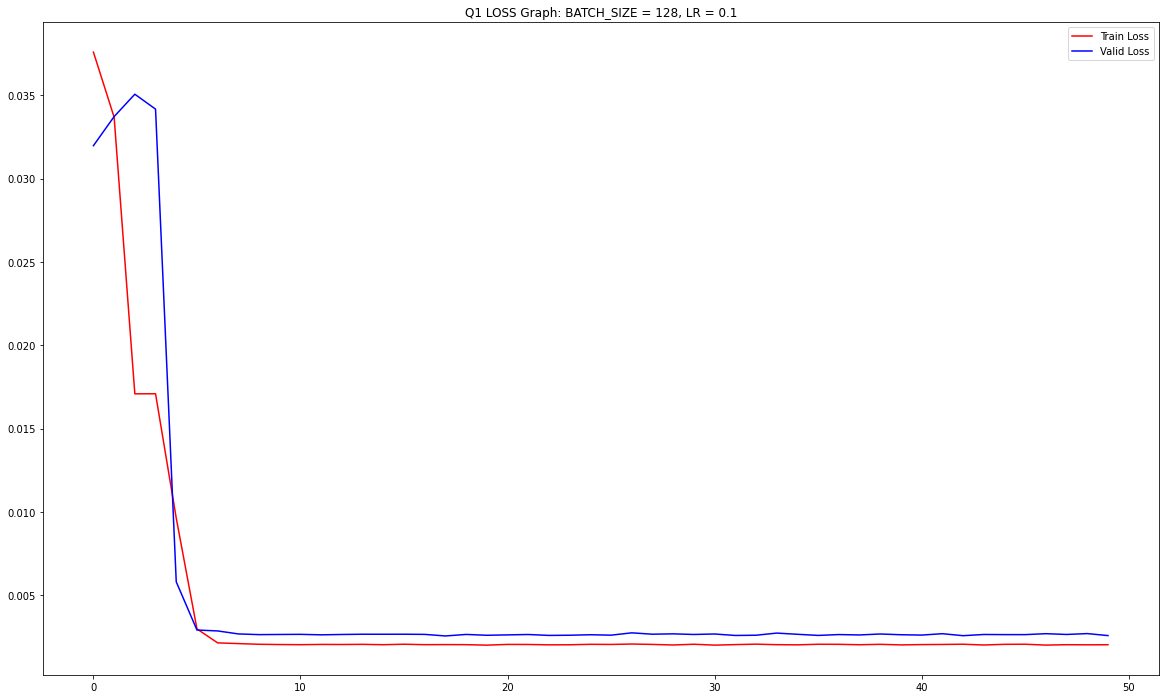

In [272]:
x = np.arange(len(train_loss))
plt.figure(figsize=(20, 12))
plt.plot(x, train_loss, color='r', label='Train Loss')
plt.plot(x, valid_loss, color='b', label='Valid Loss')
plt.title(f"Q1 LOSS Graph: BATCH_SIZE = {batch_size}, LR = {params['learning_rate']}")
plt.legend()
plt.show()

In [273]:
def mape(truths, preds):
    return np.mean(np.abs((truths - preds) / truths)) * 100

from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score

In [274]:
def test(params, test_loader, path):
    input_size = params['input_size']
    hidden_size = params['hidden_size']
    num_layers = params['num_layers']
    output_size = params['output_size']
    truths, preds = [], []
    model = LSTM(input_size, hidden_size, num_layers, output_size, batch_size)
    print(model)
    if MULTI_GPU:
        model = nn.DataParallel(model, device_ids=device_ids)
    model.load_state_dict(torch.load(path)['model'])
    model.to(device)
    
    model.eval()
    for X, y in tqdm(test_loader):
        X = X.to(device)
        for each in y:
            truths.append(each.cpu().numpy())
        with torch.no_grad():
            y_hat = model(X)
            for each in y_hat:
                preds.append(each.cpu().numpy())
    truths, preds = np.array(truths), np.array(preds)
    truths = test_scaler.inverse_transform(truths)
    preds = test_scaler.inverse_transform(preds)
    print('MAPE:', mape(truths, preds))
    print('MAE:', MAE(truths, preds))
    print('MSE:', MSE(truths, preds))
    print('R2 Score:', r2_score(truths, preds))
    
    return truths, preds

In [275]:
truths, preds = test(params, test_loader, 'model.pth')

LSTM(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)


100%|██████████| 99/99 [00:01<00:00, 76.72it/s] 

MAPE: 6.494203954935074
MAE: 13078.942
MSE: 358490700.0
R2 Score: 0.5577153034785525


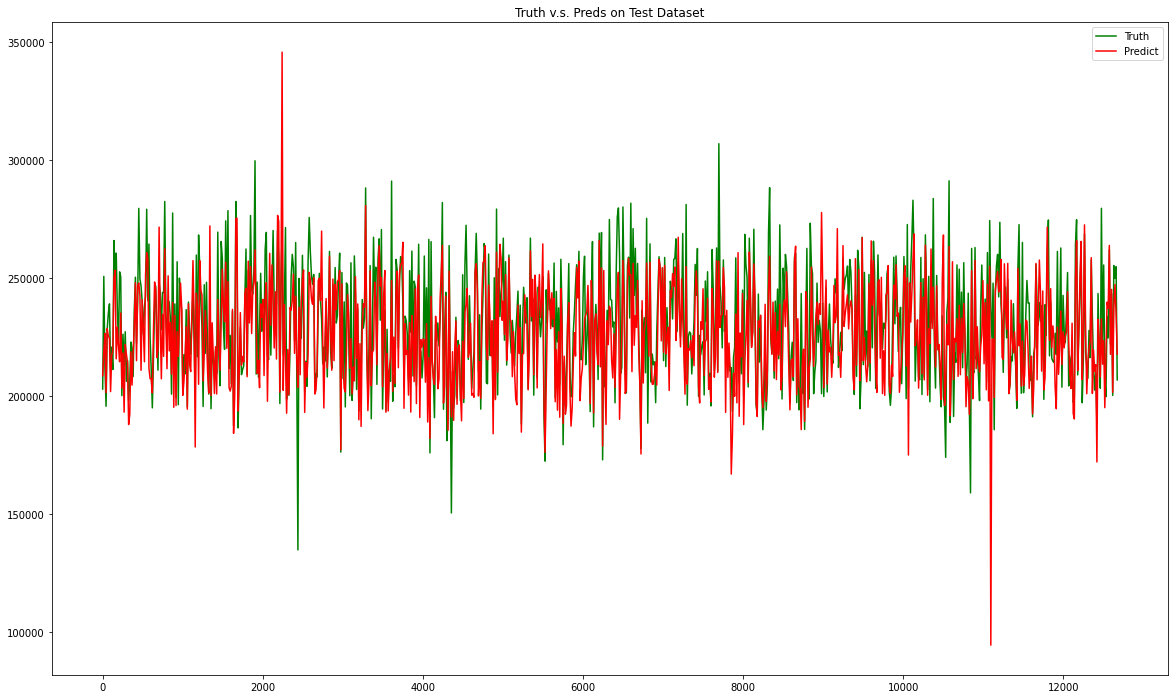

In [276]:
from scipy.interpolate import make_interp_spline

x = [i for i in range(1, len(truths) + 1)]
x_smth = np.linspace(np.min(x), np.max(x), 900)
truths_smth = make_interp_spline(x, truths)(x_smth)
preds_smth = make_interp_spline(x, preds)(x_smth)
plt.figure(figsize=(20, 12))
plt.plot(x_smth, truths_smth, color='g', label='Truth')
plt.plot(x_smth, preds_smth, color='r', label='Predict')
plt.legend()
plt.title('Truth v.s. Preds on Test Dataset')
plt.show()

# Question 2

In [277]:
df = pd.read_csv('15min_freq.csv')
df.head()

,Date,Power
0,2018-01-01 00:00:00,244033.7682
1,2018-01-01 00:15:00,232720.6402
2,2018-01-01 00:30:00,231685.6891
3,2018-01-01 00:45:00,227581.3317
4,2018-01-01 01:00:00,233482.4269


In [278]:
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Hour'] = df['Date'].dt.hour
df['Minute'] = df['Date'].dt.minute
df['Tick'] = df['Hour'] * 4 + df['Minute'] // 15
df.drop(columns=['Date'], inplace=True)
df.head()

,Power,Year,Month,Day,Hour,Minute,Tick
0,244033.7682,2018,1,1,0,0,0
1,232720.6402,2018,1,1,0,15,1
2,231685.6891,2018,1,1,0,30,2
3,227581.3317,2018,1,1,0,45,3
4,233482.4269,2018,1,1,1,0,4


In [279]:
groups = df.groupby(['Year', 'Month', 'Day'], as_index=False)
columns = ['Power', 'Year', 'Month', 'Day', 'Hour', 'Minute']
data_daily_max = pd.DataFrame(columns=columns)
data_daily_min = pd.DataFrame(columns=columns)
for group in groups:
    _, meta = group
    max_row = meta[meta['Power'] == meta['Power'].max()]
    min_row = meta[meta['Power'] == meta['Power'].min()]
    data_daily_max = pd.concat([data_daily_max, max_row], ignore_index=True)
    data_daily_min = pd.concat([data_daily_min, min_row], ignore_index=True)

In [280]:
data_daily_max.head()

,Power,Year,Month,Day,Hour,Minute,Tick
0,257733.9648,2018,1,1,19,45,79.0
1,288502.5947,2018,1,2,20,30,82.0
2,300698.5858,2018,1,3,18,15,73.0
3,293806.5077,2018,1,4,14,45,59.0
4,295075.2147,2018,1,5,18,30,74.0


In [281]:
data_daily_min.head()

,Power,Year,Month,Day,Hour,Minute,Tick
0,203793.5753,2018,1,1,8,15,33.0
1,183505.2648,2018,1,2,4,15,17.0
2,220601.5301,2018,1,3,4,15,17.0
3,224981.5866,2018,1,4,4,45,19.0
4,224667.8170,2018,1,5,4,15,17.0


Text(0.5, 1.0, 'Daily Power Max & Min')

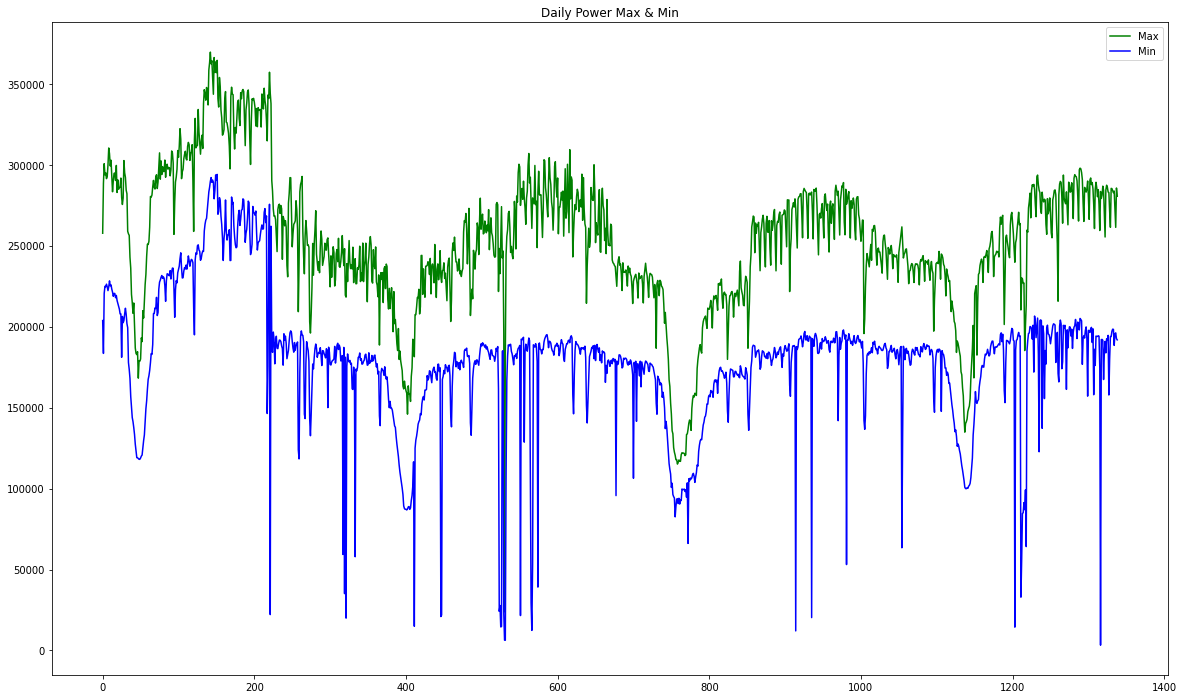

In [282]:
plt.figure(figsize=(20, 12))
x = np.arange(len(data_daily_max))
plt.plot(x, data_daily_max['Power'], c='g', label='Max')
plt.plot(x, data_daily_min['Power'], c='b', label='Min')
plt.legend()
plt.title('Daily Power Max & Min')

Text(0.5, 1.0, 'Daily Max and Min Time (As Tick)')

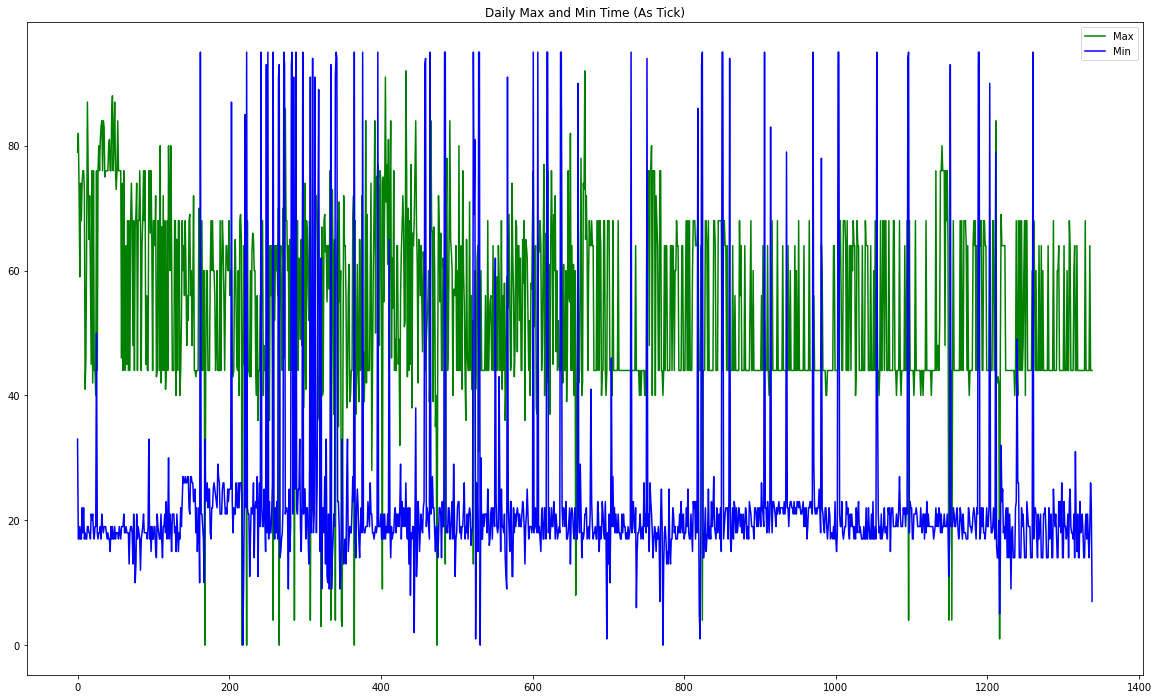

In [283]:
plt.figure(figsize=(20, 12))
x = np.arange(len(data_daily_max))
plt.plot(x, data_daily_max['Tick'], c='g', label='Max')
plt.plot(x, data_daily_min['Tick'], c='b', label='Min')
plt.legend()
plt.title('Daily Max and Min Time (As Tick)')

In [284]:
data_daily_max['Date'] = pd.to_datetime(data_daily_max[['Year', 'Month', 'Day']])
data_daily_min['Date'] = pd.to_datetime(data_daily_min[['Year', 'Month', 'Day']])

In [285]:
weather_data = pd.read_csv('../input/electrical-energy-load/train/3.csv')
weather_data.head()

,日期,天气状况,最高温度,最低温度,白天风力风向,夜晚风力风向
0,2018年1月1日,多云/多云,22℃,12℃,无持续风向<3级,无持续风向<3级
1,2018年1月1日,多云/多云,22℃,12℃,无持续风向<3级,无持续风向<3级
2,2018年1月2日,多云/多云,22℃,15℃,无持续风向<3级,无持续风向<3级
3,2018年1月3日,多云/阴,23℃,15℃,无持续风向<3级,无持续风向<3级
4,2018年1月4日,多云/小雨,21℃,16℃,无持续风向<3级,无持续风向<3级


In [286]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1345 entries, 0 to 1344
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   日期      1345 non-null   object
 1   天气状况    1345 non-null   object
 2   最高温度    1345 non-null   object
 3   最低温度    1345 non-null   object
 4   白天风力风向  1345 non-null   object
 5   夜晚风力风向  1345 non-null   object
dtypes: object(6)
memory usage: 63.2+ KB


In [287]:
weather_data.columns = ['Date', 'Weather', 'HighTemp', 'LowTemp', 'DayWind', 'NightWind']
weather_data['Date'] = weather_data['Date'].apply(lambda x: x.replace('年', '-'))
weather_data['Date'] = weather_data['Date'].apply(lambda x: x.replace('月', '-'))
weather_data['Date'] = weather_data['Date'].apply(lambda x: x.replace('日', '-'))
weather_data['Date'] = pd.to_datetime(weather_data['Date'])
weather_data.head()

,Date,Weather,HighTemp,LowTemp,DayWind,NightWind
0,2018-01-01,多云/多云,22℃,12℃,无持续风向<3级,无持续风向<3级
1,2018-01-01,多云/多云,22℃,12℃,无持续风向<3级,无持续风向<3级
2,2018-01-02,多云/多云,22℃,15℃,无持续风向<3级,无持续风向<3级
3,2018-01-03,多云/阴,23℃,15℃,无持续风向<3级,无持续风向<3级
4,2018-01-04,多云/小雨,21℃,16℃,无持续风向<3级,无持续风向<3级


In [288]:
weather_data['HighTemp'] = weather_data['HighTemp'].apply(lambda x: int(x[:-1]))
weather_data['LowTemp'] = weather_data['LowTemp'].apply(lambda x: int(x[:-1]))
weather_data['HighTemp'] = weather_data['HighTemp'].astype('int32')
weather_data['LowTemp'] = weather_data['LowTemp'].astype('int32')
weather_data.head()

,Date,Weather,HighTemp,LowTemp,DayWind,NightWind
0,2018-01-01,多云/多云,22,12,无持续风向<3级,无持续风向<3级
1,2018-01-01,多云/多云,22,12,无持续风向<3级,无持续风向<3级
2,2018-01-02,多云/多云,22,15,无持续风向<3级,无持续风向<3级
3,2018-01-03,多云/阴,23,15,无持续风向<3级,无持续风向<3级
4,2018-01-04,多云/小雨,21,16,无持续风向<3级,无持续风向<3级


In [289]:
weather_data['Weather1'] = weather_data['Weather'].apply(lambda x: x.split('/')[0])
weather_data['Weather2'] = weather_data['Weather'].apply(lambda x: x.split('/')[1])
weather_data.drop(columns=['Weather'], inplace=True)
weather_data['Weather1'].value_counts(), weather_data['Weather2'].value_counts()

(多云       447
 雷阵雨      213
 阴        172
 晴        158
 阵雨        96
 中雨        87
 小雨        78
 大雨        52
 暴雨        14
 中到大雨      10
 小雨-中雨      8
 中雨-大雨      4
 雾          2
 小到中雨       2
 晴间多云       1
 大到暴雨       1
 Name: Weather1, dtype: int64,
 多云       574
 阴        187
 晴        142
 雷阵雨      131
 阵雨       103
 小雨        77
 中雨        68
 大雨        33
 暴雨         8
 小到中雨       7
 大到暴雨       4
 雾          3
 中到大雨       3
 中雨-大雨      2
 小雨-中雨      2
 局部多云       1
 Name: Weather2, dtype: int64)

In [290]:
from sklearn.preprocessing import OneHotEncoder

weather_encoder = OneHotEncoder(handle_unknown='ignore')
weather_encoder.fit(weather_data[['Weather1', 'Weather2']].values)
mat = weather_encoder.transform(weather_data[['Weather1', 'Weather2']].values).toarray()
feature_labels = np.array(weather_encoder.categories_).ravel()

columns = []
for col in ['Weather1', 'Weather2']:
    for val in weather_data[col].unique():
        columns.append('{}_{}'.format(col, val))
        
onehot_codes = pd.DataFrame(data=mat, columns=columns, dtype=int)
weather_data = pd.concat([weather_data, onehot_codes], axis=1)
weather_data.head()

,Date,HighTemp,LowTemp,DayWind,NightWind,Weather1,Weather2,Weather1_多云,Weather1_阴,Weather1_小雨-中雨,...,Weather2_晴,Weather2_局部多云,Weather2_阵雨,Weather2_雾,Weather2_雷阵雨,Weather2_大雨,Weather2_暴雨,Weather2_中到大雨,Weather2_小到中雨,Weather2_大到暴雨
0,2018-01-01,22,12,无持续风向<3级,无持续风向<3级,多云,多云,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2018-01-01,22,12,无持续风向<3级,无持续风向<3级,多云,多云,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2018-01-02,22,15,无持续风向<3级,无持续风向<3级,多云,多云,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2018-01-03,23,15,无持续风向<3级,无持续风向<3级,多云,阴,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,2018-01-04,21,16,无持续风向<3级,无持续风向<3级,多云,小雨,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [291]:
wind_encoder = OneHotEncoder(handle_unknown='ignore')
wind_encoder.fit(weather_data[['DayWind', 'NightWind']].values)
mat = wind_encoder.transform(weather_data[['DayWind', 'NightWind']].values).toarray()
feature_labels = np.array(wind_encoder.categories_).ravel()

columns = []
for col in ['DayWind', 'NightWind']:
    for val in weather_data[col].unique():
        columns.append('{}_{}'.format(col, val))

onehot_codes = pd.DataFrame(data=mat, columns=columns, dtype=int)
weather_data = pd.concat([weather_data, onehot_codes], axis=1)
weather_data.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  after removing the cwd from sys.path.


,Date,HighTemp,LowTemp,DayWind,NightWind,Weather1,Weather2,Weather1_多云,Weather1_阴,Weather1_小雨-中雨,...,NightWind_北风3-4级,NightWind_北风4-5级,NightWind_南风3-4级,NightWind_南风1-2级,NightWind_东南风1-2级,NightWind_西南风3-4级,NightWind_东风1-2级,NightWind_北风1-2级,NightWind_东北风1-2级,NightWind_西南风1-2级
0,2018-01-01,22,12,无持续风向<3级,无持续风向<3级,多云,多云,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,2018-01-01,22,12,无持续风向<3级,无持续风向<3级,多云,多云,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,2018-01-02,22,15,无持续风向<3级,无持续风向<3级,多云,多云,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,2018-01-03,23,15,无持续风向<3级,无持续风向<3级,多云,阴,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,2018-01-04,21,16,无持续风向<3级,无持续风向<3级,多云,小雨,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [292]:
weather_data.shape

(1345, 90)

In [293]:
weather_data.drop(columns=['DayWind', 'NightWind', 'Weather1', 'Weather2'], inplace=True)
weather_data = weather_data.drop_duplicates(subset=['Date']).reset_index()
weather_data.shape

(1339, 87)

In [294]:
daily_max_data = pd.merge(data_daily_max, weather_data, on='Date')
daily_min_data = pd.merge(data_daily_min, weather_data, on='Date')

In [295]:
daily_max_data.index = daily_max_data['Date']
daily_min_data.index = daily_min_data['Date']
daily_max_data.drop(columns=['Date', 'index', 'Year', 'Month', 'Day', 'Hour', 'Minute'], inplace=True)
daily_min_data.drop(columns=['Date', 'index', 'Year', 'Month', 'Day', 'Hour', 'Minute'], inplace=True)

In [296]:
daily_max_data.head()

,Power,Tick,HighTemp,LowTemp,Weather1_多云,Weather1_阴,Weather1_小雨-中雨,Weather1_大雨,Weather1_中雨,Weather1_小雨,...,NightWind_北风3-4级,NightWind_北风4-5级,NightWind_南风3-4级,NightWind_南风1-2级,NightWind_东南风1-2级,NightWind_西南风3-4级,NightWind_东风1-2级,NightWind_北风1-2级,NightWind_东北风1-2级,NightWind_西南风1-2级
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,257733.9648,79.0,22,12,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
2018-01-02,288502.5947,82.0,22,15,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
2018-01-03,300698.5858,73.0,23,15,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
2018-01-04,293806.5077,59.0,21,16,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
2018-01-05,295075.2147,74.0,19,13,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [297]:
daily_max_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1339 entries, 2018-01-01 to 2021-08-31
Data columns (total 87 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Power                1339 non-null   float64
 1   Tick                 1339 non-null   float64
 2   HighTemp             1339 non-null   int32  
 3   LowTemp              1339 non-null   int32  
 4   Weather1_多云          1339 non-null   int64  
 5   Weather1_阴           1339 non-null   int64  
 6   Weather1_小雨-中雨       1339 non-null   int64  
 7   Weather1_大雨          1339 non-null   int64  
 8   Weather1_中雨          1339 non-null   int64  
 9   Weather1_小雨          1339 non-null   int64  
 10  Weather1_晴           1339 non-null   int64  
 11  Weather1_雷阵雨         1339 non-null   int64  
 12  Weather1_雾           1339 non-null   int64  
 13  Weather1_阵雨          1339 non-null   int64  
 14  Weather1_中雨-大雨       1339 non-null   int64  
 15  Weather1_晴间多云       

In [298]:
# from sklearn.feature_selection import VarianceThreshold

# daily_max_data = daily_max_data.values
# daily_min_data = daily_min_data.values

# max_selector = VarianceThreshold(threshold=0.16)
# daily_max_data = np.concatenate([daily_max_data[:, :2], max_selector.fit_transform(daily_max_data[:, 2:])], axis=1)

# min_selector = VarianceThreshold(threshold=0.16)
# daily_min_data = np.concatenate([daily_min_data[:, :2], min_selector.fit_transform(daily_min_data[:, 2:])], axis=1)

In [299]:
daily_max_data

,Power,Tick,HighTemp,LowTemp,Weather1_多云,Weather1_阴,Weather1_小雨-中雨,Weather1_大雨,Weather1_中雨,Weather1_小雨,...,NightWind_北风3-4级,NightWind_北风4-5级,NightWind_南风3-4级,NightWind_南风1-2级,NightWind_东南风1-2级,NightWind_西南风3-4级,NightWind_东风1-2级,NightWind_北风1-2级,NightWind_东北风1-2级,NightWind_西南风1-2级
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,257733.9648,79.0,22,12,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
2018-01-02,288502.5947,82.0,22,15,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
2018-01-03,300698.5858,73.0,23,15,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
2018-01-04,293806.5077,59.0,21,16,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
2018-01-05,295075.2147,74.0,19,13,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-27,283786.5080,44.0,35,26,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2021-08-28,272522.5991,64.0,33,26,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2021-08-29,261364.9171,44.0,32,25,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [300]:
from scipy.signal import savgol_filter as SGFilt

train_bin_max, valid_bin_max, test_bin_max = split_dataset(daily_max_data, .7, .1)
train_bin_min, valid_bin_min, test_bin_min = split_dataset(daily_min_data, .7, .1)

w, p = 7, 3
train_bin_max['Power'] = SGFilt(train_bin_max['Power'], w, p)
train_bin_max['Tick'] = SGFilt(train_bin_max['Tick'], w, p)
train_bin_min['Power'] = SGFilt(train_bin_min['Power'], w, p)
train_bin_min['Tick'] = SGFilt(train_bin_min['Tick'], w, p)

In [301]:
test_max_power_range = [test_bin_max['Power'].min(), test_bin_max['Power'].max()]
test_max_tick_range = [test_bin_max['Tick'].min(), test_bin_max['Tick'].max()]

test_min_power_range = [test_bin_min['Power'].min(), test_bin_min['Power'].max()]
test_min_tick_range = [test_bin_min['Tick'].min(), test_bin_min['Tick'].max()]

In [302]:
def scaling(data):
    scaler = MinMaxScaler()
    return scaler, scaler.fit_transform(data)

In [303]:
train_max_scaler, train_max = scaling(train_bin_max)
train_min_scaler, train_min = scaling(train_bin_min)
valid_max_scaler, valid_max = scaling(valid_bin_max)
valid_min_scaler, valid_min = scaling(valid_bin_min)
test_max_scaler, test_max = scaling(test_bin_max)
test_min_scaler, test_min = scaling(test_bin_min)

Now daily max data on: train_max, valid_max, test_max

Now daily min data on: train_min, valid_min, test_min


## 2.1 For Daily Max

### 2.1.1 multi-output LSTM Regression Trail

In [304]:
def preprocessing(data, window_size, predict_size):
    X, y = [], []
    for i in range(len(data) - window_size - predict_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size:i + window_size + predict_size, :2].reshape(2, -1))
    X = torch.FloatTensor(np.array(X))
    y = torch.FloatTensor(np.array(y))
    return X, y

In [305]:
window_size, predict_size = 14, 1

X_train, y_train = preprocessing(train_max, window_size, predict_size)
X_valid, y_valid = preprocessing(valid_max, window_size, predict_size)
X_test, y_test = preprocessing(test_max, window_size, predict_size)

In [306]:
X_train.shape

torch.Size([922, 14, 87])

In [307]:
train_data = TensorDataset(X_train, y_train)
valid_data = TensorDataset(X_valid, y_valid)
test_data = TensorDataset(X_test, y_test)

In [308]:
batch_size = 16
train_loader = DataLoader(train_data, batch_size=batch_size * num_gpus,
                          shuffle=True, num_workers=2,
                          drop_last=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size * num_gpus,
                          shuffle=True, num_workers=2,
                          drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size * num_gpus,
                          shuffle=True, num_workers=2,
                          drop_last=True)

In [309]:
print('Train set:', X_train.shape, y_train.shape)
print('Valid set:', X_valid.shape, y_valid.shape)
print('Test set:', X_test.shape, y_test.shape)

Train set: torch.Size([922, 14, 87]) torch.Size([922, 2, 1])
Valid set: torch.Size([118, 14, 87]) torch.Size([118, 2, 1])
Test set: torch.Size([254, 14, 87]) torch.Size([254, 2, 1])


In [310]:
class LSTM_multi(nn.Module):
    def __init__(self, input_size, hidden_size,
                 num_layers, output_size, batch_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_size = batch_size
        self.num_directions = 1
        self.lstm = nn.LSTM(self.input_size, self.hidden_size,
                            self.num_layers, batch_first=True)
#         self.reg_pred = nn.Sequential(nn.Linear(self.hidden_size, self.hidden_size // 2),
#                                       nn.ReLU(),
#                                       nn.Linear(self.hidden_size // 2, self.hidden_size // 4),
#                                       nn.ReLU(),
#                                       nn.Linear(self.hidden_size // 4, self.output_size))
#         self.reg_time = nn.Sequential(nn.Linear(self.hidden_size, self.hidden_size // 2),
#                                       nn.ReLU(),
#                                       nn.Linear(self.hidden_size // 2, self.hidden_size // 4),
#                                       nn.ReLU(),
#                                       nn.Linear(self.hidden_size // 4, self.output_size))
        self.linear_pred = nn.Linear(self.hidden_size, self.output_size)
        self.linear_time = nn.Linear(self.hidden_size, self.output_size)
    
    def forward(self, X):
        h_0 = torch.randn(self.num_directions * self.num_layers, self.batch_size, self.hidden_size).to(device)
        c_0 = torch.randn(self.num_directions * self.num_layers, self.batch_size, self.hidden_size).to(device)
        output, _ = self.lstm(X, (h_0, c_0))
        o = output[:, -1, :]
        pred, time = self.linear_pred(o), self.linear_time(o)
#         pred, time = self.reg_pred(o), self.reg_time(o)
        preds = torch.stack([pred, time], dim=0)
        return preds

In [311]:
params = {'input_size': X_train.shape[2],
          'hidden_size': 512,
          'output_size': predict_size,
          'num_outputs': 2,
          'num_layers': 20, 
          'learning_rate': 0.5,
          'weight_decay': 1e-2,
          'step_size': 10,
          'gamma': 0.1,
          'epochs': 100}

In [312]:
def train(params, train_loader, valid_loader, path):
    input_size = params['input_size']
    hidden_size = params['hidden_size']
    num_layers = params['num_layers']
    output_size = params['output_size']
    lr = params['learning_rate']
    wd = params['weight_decay']
    step_size = params['step_size']
    gamma = params['gamma']
    epochs = params['epochs']
    num_outputs = params['num_outputs']
    train_loss, valid_loss = [], []
    min_valid_loss = np.inf
    
    model = LSTM_multi(input_size, hidden_size, num_layers, output_size, batch_size)
    print(model)
    if MULTI_GPU:
        model = nn.DataParallel(model, device_ids=device_ids)
    model.to(device)
    
    loss = nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size,
                                                gamma=gamma)
    if MULTI_GPU:
        optimizer = nn.DataParallel(optimizer, device_ids=device_ids)
        scheduler = nn.DataParallel(scheduler, device_ids=device_ids)
        
    for epoch in tqdm(range(epochs)):
        train_ls, valid_ls = [], []
        
        model.train()
        for step, (X, y) in enumerate(train_loader):
            X = X.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            l = 0
            for k in range(num_outputs):
                l += loss(y_hat[k, :, :], y[:, k, :])
            l /= num_outputs
            train_ls.append(l.item())
            l.backward()
            optimizer.step()
            if step % 10 == 0:
                print("Step {}, train loss {:.6f}".format(step, l.item()))
        train_loss.append(np.mean(train_ls))
        
        model.eval()
        for step, (X, y) in enumerate(valid_loader):
            X = X.to(device)
            y = y.to(device)
            with torch.no_grad():
                y_hat = model(X)
            l = 0
            for k in range(num_outputs):
                l += loss(y_hat[k, :, :], y[:, k, :])
            l /= num_outputs
            valid_ls.append(l.item())
        valid_loss.append(np.mean(valid_ls))
        if valid_loss[-1] < min_valid_loss:
            state = {'model': model.state_dict()}
            torch.save(state, path)
            min_valid_loss = valid_loss[-1]
        
        print('Epoch [{:d}/{:d}], train loss {:.6f}, valid loss {:.6f}. Now best: {:.6f}'.format(
                epoch + 1, epochs, train_loss[-1], valid_loss[-1], min_valid_loss))
        scheduler.step()
    
    return train_loss, valid_loss

In [313]:
train_loss, valid_loss = train(params, train_loader, valid_loader, 'model_max.pth')

LSTM_multi(
  (lstm): LSTM(87, 512, num_layers=20, batch_first=True)
  (linear_pred): Linear(in_features=512, out_features=1, bias=True)
  (linear_time): Linear(in_features=512, out_features=1, bias=True)
)


  0%|          | 0/100 [00:00<?, ?it/s]

Step 0, train loss 0.293156
Step 10, train loss 147.107849
Step 20, train loss 300.241028
Step 30, train loss 130.440704
Step 40, train loss 179.903625
Step 50, train loss 187.724365


  1%|          | 1/100 [00:03<05:54,  3.58s/it]

Epoch [1/100], train loss 184.882523, valid loss 208.582670. Now best: 208.582670
Step 0, train loss 139.139679
Step 10, train loss 229.012909
Step 20, train loss 210.822296
Step 30, train loss 246.462189
Step 40, train loss 209.540070
Step 50, train loss 278.401520


  2%|▏         | 2/100 [00:07<05:56,  3.63s/it]

Epoch [2/100], train loss 183.185714, valid loss 181.604045. Now best: 181.604045
Step 0, train loss 138.912766
Step 10, train loss 174.667358
Step 20, train loss 265.934204
Step 30, train loss 104.450272
Step 40, train loss 104.552567
Step 50, train loss 123.552155


  3%|▎         | 3/100 [00:11<05:59,  3.70s/it]

Epoch [3/100], train loss 161.797123, valid loss 179.653799. Now best: 179.653799
Step 0, train loss 151.389755
Step 10, train loss 292.765411
Step 20, train loss 220.362030
Step 30, train loss 162.374542
Step 40, train loss 204.852310
Step 50, train loss 136.053528


  4%|▍         | 4/100 [00:14<05:35,  3.50s/it]

Epoch [4/100], train loss 173.237474, valid loss 205.345418. Now best: 179.653799
Step 0, train loss 116.136612
Step 10, train loss 83.476028
Step 20, train loss 198.797058
Step 30, train loss 247.572067
Step 40, train loss 248.748077
Step 50, train loss 239.294067


  5%|▌         | 5/100 [00:17<05:37,  3.55s/it]

Epoch [5/100], train loss 174.812255, valid loss 170.513588. Now best: 170.513588
Step 0, train loss 227.264709
Step 10, train loss 368.582581
Step 20, train loss 172.030945
Step 30, train loss 89.633667
Step 40, train loss 101.255981
Step 50, train loss 140.156311


  6%|▌         | 6/100 [00:20<05:20,  3.41s/it]

Epoch [6/100], train loss 161.258864, valid loss 176.788549. Now best: 170.513588
Step 0, train loss 107.500107
Step 10, train loss 164.897034
Step 20, train loss 93.572937
Step 30, train loss 135.406387
Step 40, train loss 241.036362
Step 50, train loss 115.305359


  7%|▋         | 7/100 [00:24<05:26,  3.51s/it]

Epoch [7/100], train loss 162.455217, valid loss 138.557558. Now best: 138.557558
Step 0, train loss 93.663696
Step 10, train loss 246.290192
Step 20, train loss 145.158234
Step 30, train loss 157.356384
Step 40, train loss 300.280518
Step 50, train loss 98.595932


  8%|▊         | 8/100 [00:27<05:11,  3.38s/it]

Epoch [8/100], train loss 184.084400, valid loss 176.680632. Now best: 138.557558
Step 0, train loss 200.778595
Step 10, train loss 154.014084
Step 20, train loss 333.908203
Step 30, train loss 230.183548
Step 40, train loss 139.115753
Step 50, train loss 273.603455


  9%|▉         | 9/100 [00:31<05:15,  3.47s/it]

Epoch [9/100], train loss 178.041717, valid loss 130.775653. Now best: 130.775653
Step 0, train loss 103.296326
Step 10, train loss 123.323303
Step 20, train loss 144.020599
Step 30, train loss 182.359161
Step 40, train loss 141.867355
Step 50, train loss 267.301208


 10%|█         | 10/100 [00:34<05:04,  3.39s/it]

Epoch [10/100], train loss 146.130151, valid loss 131.258640. Now best: 130.775653
Step 0, train loss 121.447212
Step 10, train loss 121.834167
Step 20, train loss 58.610977
Step 30, train loss 106.359344
Step 40, train loss 86.744492
Step 50, train loss 82.657669


 11%|█         | 11/100 [00:38<05:11,  3.50s/it]

Epoch [11/100], train loss 120.065042, valid loss 68.918704. Now best: 68.918704
Step 0, train loss 50.034981
Step 10, train loss 65.834816
Step 20, train loss 61.985222
Step 30, train loss 27.159100
Step 40, train loss 9.252804
Step 50, train loss 28.003845


 12%|█▏        | 12/100 [00:42<05:14,  3.58s/it]

Epoch [12/100], train loss 49.196174, valid loss 33.852781. Now best: 33.852781
Step 0, train loss 28.159370
Step 10, train loss 22.120825
Step 20, train loss 25.991581
Step 30, train loss 25.687145
Step 40, train loss 27.492111
Step 50, train loss 18.204073


 13%|█▎        | 13/100 [00:46<05:17,  3.65s/it]

Epoch [13/100], train loss 21.201235, valid loss 17.231624. Now best: 17.231624
Step 0, train loss 19.580444
Step 10, train loss 11.339170
Step 20, train loss 9.513235
Step 30, train loss 13.507675
Step 40, train loss 12.178523
Step 50, train loss 4.061380


 14%|█▍        | 14/100 [00:49<05:14,  3.66s/it]

Epoch [14/100], train loss 11.915111, valid loss 7.102006. Now best: 7.102006
Step 0, train loss 10.562677
Step 10, train loss 4.988816
Step 20, train loss 9.151613
Step 30, train loss 5.207210
Step 40, train loss 7.701932
Step 50, train loss 2.534156


 15%|█▌        | 15/100 [00:53<05:11,  3.66s/it]

Epoch [15/100], train loss 5.686090, valid loss 3.767683. Now best: 3.767683
Step 0, train loss 2.367996
Step 10, train loss 4.687622
Step 20, train loss 1.468121
Step 30, train loss 2.141497
Step 40, train loss 2.019842
Step 50, train loss 1.699260


 16%|█▌        | 16/100 [00:57<05:08,  3.67s/it]

Epoch [16/100], train loss 2.633854, valid loss 1.936738. Now best: 1.936738
Step 0, train loss 2.164827
Step 10, train loss 1.164375
Step 20, train loss 1.871977
Step 30, train loss 2.212896
Step 40, train loss 1.139591
Step 50, train loss 1.149729


 17%|█▋        | 17/100 [01:00<05:04,  3.67s/it]

Epoch [17/100], train loss 1.222769, valid loss 0.873952. Now best: 0.873952
Step 0, train loss 0.819909
Step 10, train loss 1.183688
Step 20, train loss 0.376227
Step 30, train loss 0.830977
Step 40, train loss 1.003060
Step 50, train loss 0.504650


 18%|█▊        | 18/100 [01:04<05:01,  3.68s/it]

Epoch [18/100], train loss 0.648927, valid loss 0.534085. Now best: 0.534085
Step 0, train loss 0.171457
Step 10, train loss 0.326721
Step 20, train loss 0.338408
Step 30, train loss 0.153553
Step 40, train loss 0.251777
Step 50, train loss 0.354221


 19%|█▉        | 19/100 [01:08<04:58,  3.69s/it]

Epoch [19/100], train loss 0.324747, valid loss 0.238777. Now best: 0.238777
Step 0, train loss 0.468307
Step 10, train loss 0.143533
Step 20, train loss 0.264765
Step 30, train loss 0.081558
Step 40, train loss 0.091761
Step 50, train loss 0.136423


 20%|██        | 20/100 [01:11<04:54,  3.68s/it]

Epoch [20/100], train loss 0.168066, valid loss 0.187359. Now best: 0.187359
Step 0, train loss 0.070981
Step 10, train loss 0.150716
Step 20, train loss 0.188280
Step 30, train loss 0.152312
Step 40, train loss 0.119801
Step 50, train loss 0.110264


 21%|██        | 21/100 [01:15<04:51,  3.69s/it]

Epoch [21/100], train loss 0.110914, valid loss 0.177864. Now best: 0.177864
Step 0, train loss 0.044219
Step 10, train loss 0.097405
Step 20, train loss 0.062954
Step 30, train loss 0.074464
Step 40, train loss 0.109234
Step 50, train loss 0.096801


 22%|██▏       | 22/100 [01:19<04:55,  3.78s/it]

Epoch [22/100], train loss 0.097275, valid loss 0.156674. Now best: 0.156674
Step 0, train loss 0.104829
Step 10, train loss 0.098968
Step 20, train loss 0.124789
Step 30, train loss 0.122540
Step 40, train loss 0.085640
Step 50, train loss 0.062528


 23%|██▎       | 23/100 [01:22<04:35,  3.58s/it]

Epoch [23/100], train loss 0.088481, valid loss 0.160968. Now best: 0.156674
Step 0, train loss 0.052258
Step 10, train loss 0.052659
Step 20, train loss 0.085324
Step 30, train loss 0.054884
Step 40, train loss 0.094449
Step 50, train loss 0.056668


 24%|██▍       | 24/100 [01:26<04:34,  3.61s/it]

Epoch [24/100], train loss 0.078729, valid loss 0.148641. Now best: 0.148641
Step 0, train loss 0.043786
Step 10, train loss 0.100953
Step 20, train loss 0.120223
Step 30, train loss 0.092121
Step 40, train loss 0.066006
Step 50, train loss 0.043412


 25%|██▌       | 25/100 [01:29<04:20,  3.47s/it]

Epoch [25/100], train loss 0.082675, valid loss 0.158399. Now best: 0.148641
Step 0, train loss 0.064807
Step 10, train loss 0.128413
Step 20, train loss 0.097286
Step 30, train loss 0.100525
Step 40, train loss 0.067669
Step 50, train loss 0.079504


 26%|██▌       | 26/100 [01:32<04:08,  3.36s/it]

Epoch [26/100], train loss 0.077307, valid loss 0.163364. Now best: 0.148641
Step 0, train loss 0.089144
Step 10, train loss 0.076746
Step 20, train loss 0.071304
Step 30, train loss 0.097623
Step 40, train loss 0.070721
Step 50, train loss 0.050010


 27%|██▋       | 27/100 [01:35<03:59,  3.28s/it]

Epoch [27/100], train loss 0.073724, valid loss 0.167835. Now best: 0.148641
Step 0, train loss 0.073403
Step 10, train loss 0.063907
Step 20, train loss 0.059641
Step 30, train loss 0.056634
Step 40, train loss 0.034970
Step 50, train loss 0.055046


 28%|██▊       | 28/100 [01:39<04:04,  3.40s/it]

Epoch [28/100], train loss 0.066525, valid loss 0.130797. Now best: 0.130797
Step 0, train loss 0.065456
Step 10, train loss 0.081002
Step 20, train loss 0.036895
Step 30, train loss 0.068779
Step 40, train loss 0.110480
Step 50, train loss 0.041614


 29%|██▉       | 29/100 [01:42<03:55,  3.31s/it]

Epoch [29/100], train loss 0.059236, valid loss 0.136361. Now best: 0.130797
Step 0, train loss 0.092643
Step 10, train loss 0.036932
Step 20, train loss 0.054443
Step 30, train loss 0.079033
Step 40, train loss 0.035756
Step 50, train loss 0.048892


 30%|███       | 30/100 [01:46<03:59,  3.42s/it]

Epoch [30/100], train loss 0.057857, valid loss 0.129199. Now best: 0.129199
Step 0, train loss 0.050209
Step 10, train loss 0.053622
Step 20, train loss 0.031940
Step 30, train loss 0.058589
Step 40, train loss 0.088411
Step 50, train loss 0.037745


 31%|███       | 31/100 [01:49<03:53,  3.39s/it]

Epoch [31/100], train loss 0.054997, valid loss 0.139471. Now best: 0.129199
Step 0, train loss 0.067251
Step 10, train loss 0.053344
Step 20, train loss 0.065383
Step 30, train loss 0.043196
Step 40, train loss 0.060867
Step 50, train loss 0.083353


 32%|███▏      | 32/100 [01:53<03:56,  3.48s/it]

Epoch [32/100], train loss 0.055457, valid loss 0.126326. Now best: 0.126326
Step 0, train loss 0.081419
Step 10, train loss 0.034772
Step 20, train loss 0.043180
Step 30, train loss 0.068008
Step 40, train loss 0.038937
Step 50, train loss 0.046921


 33%|███▎      | 33/100 [01:56<03:45,  3.37s/it]

Epoch [33/100], train loss 0.053638, valid loss 0.135645. Now best: 0.126326
Step 0, train loss 0.078471
Step 10, train loss 0.045217
Step 20, train loss 0.064563
Step 30, train loss 0.031735
Step 40, train loss 0.030633
Step 50, train loss 0.041475


 34%|███▍      | 34/100 [01:59<03:37,  3.29s/it]

Epoch [34/100], train loss 0.055600, valid loss 0.131323. Now best: 0.126326
Step 0, train loss 0.039234
Step 10, train loss 0.063886
Step 20, train loss 0.032405
Step 30, train loss 0.052977
Step 40, train loss 0.055939
Step 50, train loss 0.047526


 35%|███▌      | 35/100 [02:02<03:30,  3.24s/it]

Epoch [35/100], train loss 0.053088, valid loss 0.129075. Now best: 0.126326
Step 0, train loss 0.041125
Step 10, train loss 0.052482
Step 20, train loss 0.062808
Step 30, train loss 0.066726
Step 40, train loss 0.051257
Step 50, train loss 0.069329


 36%|███▌      | 36/100 [02:06<03:35,  3.37s/it]

Epoch [36/100], train loss 0.057480, valid loss 0.124132. Now best: 0.124132
Step 0, train loss 0.034098
Step 10, train loss 0.065552
Step 20, train loss 0.067078
Step 30, train loss 0.054813
Step 40, train loss 0.067228
Step 50, train loss 0.031754


 37%|███▋      | 37/100 [02:09<03:27,  3.29s/it]

Epoch [37/100], train loss 0.054103, valid loss 0.127759. Now best: 0.124132
Step 0, train loss 0.037775
Step 10, train loss 0.040441
Step 20, train loss 0.042251
Step 30, train loss 0.062045
Step 40, train loss 0.055237
Step 50, train loss 0.068976


 38%|███▊      | 38/100 [02:12<03:21,  3.25s/it]

Epoch [38/100], train loss 0.050902, valid loss 0.129577. Now best: 0.124132
Step 0, train loss 0.071114
Step 10, train loss 0.041767
Step 20, train loss 0.046139
Step 30, train loss 0.056134
Step 40, train loss 0.047363
Step 50, train loss 0.031732


 39%|███▉      | 39/100 [02:16<03:25,  3.38s/it]

Epoch [39/100], train loss 0.052976, valid loss 0.121278. Now best: 0.121278
Step 0, train loss 0.054400
Step 10, train loss 0.088534
Step 20, train loss 0.068666
Step 30, train loss 0.043858
Step 40, train loss 0.050458
Step 50, train loss 0.046532


 40%|████      | 40/100 [02:19<03:32,  3.54s/it]

Epoch [40/100], train loss 0.053167, valid loss 0.120558. Now best: 0.120558
Step 0, train loss 0.048869
Step 10, train loss 0.093291
Step 20, train loss 0.041421
Step 30, train loss 0.053093
Step 40, train loss 0.038943
Step 50, train loss 0.055992


 41%|████      | 41/100 [02:23<03:33,  3.63s/it]

Epoch [41/100], train loss 0.053132, valid loss 0.119517. Now best: 0.119517
Step 0, train loss 0.049080
Step 10, train loss 0.052219
Step 20, train loss 0.046356
Step 30, train loss 0.042982
Step 40, train loss 0.040107
Step 50, train loss 0.056974


 42%|████▏     | 42/100 [02:27<03:22,  3.50s/it]

Epoch [42/100], train loss 0.049678, valid loss 0.134145. Now best: 0.119517
Step 0, train loss 0.031053
Step 10, train loss 0.058688
Step 20, train loss 0.029773
Step 30, train loss 0.057981
Step 40, train loss 0.074869
Step 50, train loss 0.069562


 43%|████▎     | 43/100 [02:30<03:12,  3.38s/it]

Epoch [43/100], train loss 0.051697, valid loss 0.131850. Now best: 0.119517
Step 0, train loss 0.058219
Step 10, train loss 0.053472
Step 20, train loss 0.062210
Step 30, train loss 0.036559
Step 40, train loss 0.041957
Step 50, train loss 0.025486


 44%|████▍     | 44/100 [02:33<03:06,  3.33s/it]

Epoch [44/100], train loss 0.053466, valid loss 0.125175. Now best: 0.119517
Step 0, train loss 0.050352
Step 10, train loss 0.035376
Step 20, train loss 0.031032
Step 30, train loss 0.041675
Step 40, train loss 0.030662
Step 50, train loss 0.061011


 45%|████▌     | 45/100 [02:36<03:00,  3.28s/it]

Epoch [45/100], train loss 0.051058, valid loss 0.120798. Now best: 0.119517
Step 0, train loss 0.055509
Step 10, train loss 0.080662
Step 20, train loss 0.037195
Step 30, train loss 0.029403
Step 40, train loss 0.054141
Step 50, train loss 0.072252


 46%|████▌     | 46/100 [02:39<02:54,  3.23s/it]

Epoch [46/100], train loss 0.054750, valid loss 0.122537. Now best: 0.119517
Step 0, train loss 0.039824
Step 10, train loss 0.063138
Step 20, train loss 0.050713
Step 30, train loss 0.066378
Step 40, train loss 0.037087
Step 50, train loss 0.063352


 47%|████▋     | 47/100 [02:42<02:49,  3.19s/it]

Epoch [47/100], train loss 0.054193, valid loss 0.133426. Now best: 0.119517
Step 0, train loss 0.052731
Step 10, train loss 0.036145
Step 20, train loss 0.042135
Step 30, train loss 0.053807
Step 40, train loss 0.054550
Step 50, train loss 0.071399


 48%|████▊     | 48/100 [02:45<02:45,  3.18s/it]

Epoch [48/100], train loss 0.051965, valid loss 0.126381. Now best: 0.119517
Step 0, train loss 0.070515
Step 10, train loss 0.061263
Step 20, train loss 0.049316
Step 30, train loss 0.059288
Step 40, train loss 0.054931
Step 50, train loss 0.045457


 49%|████▉     | 49/100 [02:48<02:41,  3.16s/it]

Epoch [49/100], train loss 0.051569, valid loss 0.135540. Now best: 0.119517
Step 0, train loss 0.046403
Step 10, train loss 0.078306
Step 20, train loss 0.028111
Step 30, train loss 0.052413
Step 40, train loss 0.065522
Step 50, train loss 0.067610


 50%|█████     | 50/100 [02:52<02:38,  3.17s/it]

Epoch [50/100], train loss 0.054848, valid loss 0.134052. Now best: 0.119517
Step 0, train loss 0.041393
Step 10, train loss 0.067797
Step 20, train loss 0.064131
Step 30, train loss 0.037024
Step 40, train loss 0.036781
Step 50, train loss 0.057145


 51%|█████     | 51/100 [02:55<02:36,  3.20s/it]

Epoch [51/100], train loss 0.050311, valid loss 0.124293. Now best: 0.119517
Step 0, train loss 0.043930
Step 10, train loss 0.054514
Step 20, train loss 0.063524
Step 30, train loss 0.065685
Step 40, train loss 0.041663
Step 50, train loss 0.059476


 52%|█████▏    | 52/100 [02:58<02:32,  3.18s/it]

Epoch [52/100], train loss 0.050166, valid loss 0.126035. Now best: 0.119517
Step 0, train loss 0.060370
Step 10, train loss 0.051958
Step 20, train loss 0.040090
Step 30, train loss 0.064077
Step 40, train loss 0.062038
Step 50, train loss 0.099927


 53%|█████▎    | 53/100 [03:01<02:28,  3.16s/it]

Epoch [53/100], train loss 0.051977, valid loss 0.123658. Now best: 0.119517
Step 0, train loss 0.050534
Step 10, train loss 0.054980
Step 20, train loss 0.053671
Step 30, train loss 0.042787
Step 40, train loss 0.053592
Step 50, train loss 0.032098


 54%|█████▍    | 54/100 [03:04<02:24,  3.14s/it]

Epoch [54/100], train loss 0.049953, valid loss 0.126241. Now best: 0.119517
Step 0, train loss 0.042827
Step 10, train loss 0.046924
Step 20, train loss 0.055381
Step 30, train loss 0.045063
Step 40, train loss 0.064110
Step 50, train loss 0.055835


 55%|█████▌    | 55/100 [03:07<02:21,  3.14s/it]

Epoch [55/100], train loss 0.047739, valid loss 0.131194. Now best: 0.119517
Step 0, train loss 0.039156
Step 10, train loss 0.054185
Step 20, train loss 0.058751
Step 30, train loss 0.041926
Step 40, train loss 0.055105
Step 50, train loss 0.047520


 56%|█████▌    | 56/100 [03:11<02:17,  3.13s/it]

Epoch [56/100], train loss 0.051234, valid loss 0.135353. Now best: 0.119517
Step 0, train loss 0.037299
Step 10, train loss 0.051420
Step 20, train loss 0.041818
Step 30, train loss 0.044817
Step 40, train loss 0.047468
Step 50, train loss 0.029350


 57%|█████▋    | 57/100 [03:14<02:14,  3.12s/it]

Epoch [57/100], train loss 0.052829, valid loss 0.131384. Now best: 0.119517
Step 0, train loss 0.060684
Step 10, train loss 0.024548
Step 20, train loss 0.046105
Step 30, train loss 0.064431
Step 40, train loss 0.045242
Step 50, train loss 0.053138


 58%|█████▊    | 58/100 [03:17<02:12,  3.14s/it]

Epoch [58/100], train loss 0.051095, valid loss 0.127314. Now best: 0.119517
Step 0, train loss 0.049965
Step 10, train loss 0.053921
Step 20, train loss 0.084369
Step 30, train loss 0.048569
Step 40, train loss 0.055477
Step 50, train loss 0.058785


 59%|█████▉    | 59/100 [03:20<02:08,  3.15s/it]

Epoch [59/100], train loss 0.052855, valid loss 0.122491. Now best: 0.119517
Step 0, train loss 0.034401
Step 10, train loss 0.041202
Step 20, train loss 0.047581
Step 30, train loss 0.038611
Step 40, train loss 0.057408
Step 50, train loss 0.060911


 60%|██████    | 60/100 [03:23<02:06,  3.15s/it]

Epoch [60/100], train loss 0.048916, valid loss 0.129717. Now best: 0.119517
Step 0, train loss 0.037984
Step 10, train loss 0.076082
Step 20, train loss 0.066062
Step 30, train loss 0.055232
Step 40, train loss 0.047923
Step 50, train loss 0.067151


 61%|██████    | 61/100 [03:26<02:02,  3.14s/it]

Epoch [61/100], train loss 0.049209, valid loss 0.128157. Now best: 0.119517
Step 0, train loss 0.034701
Step 10, train loss 0.062668
Step 20, train loss 0.068675
Step 30, train loss 0.087721
Step 40, train loss 0.042560
Step 50, train loss 0.034746


 62%|██████▏   | 62/100 [03:29<01:59,  3.14s/it]

Epoch [62/100], train loss 0.052561, valid loss 0.119854. Now best: 0.119517
Step 0, train loss 0.055075
Step 10, train loss 0.046940
Step 20, train loss 0.067083
Step 30, train loss 0.045836
Step 40, train loss 0.045755
Step 50, train loss 0.076125


 63%|██████▎   | 63/100 [03:33<02:01,  3.30s/it]

Epoch [63/100], train loss 0.052335, valid loss 0.118158. Now best: 0.118158
Step 0, train loss 0.053442
Step 10, train loss 0.051646
Step 20, train loss 0.058163
Step 30, train loss 0.052319
Step 40, train loss 0.036973
Step 50, train loss 0.061228


 64%|██████▍   | 64/100 [03:36<01:56,  3.24s/it]

Epoch [64/100], train loss 0.052348, valid loss 0.125452. Now best: 0.118158
Step 0, train loss 0.050327
Step 10, train loss 0.063788
Step 20, train loss 0.070020
Step 30, train loss 0.047782
Step 40, train loss 0.076886
Step 50, train loss 0.043994


 65%|██████▌   | 65/100 [03:39<01:53,  3.23s/it]

Epoch [65/100], train loss 0.051468, valid loss 0.134406. Now best: 0.118158
Step 0, train loss 0.048875
Step 10, train loss 0.065419
Step 20, train loss 0.072328
Step 30, train loss 0.055052
Step 40, train loss 0.063955
Step 50, train loss 0.054256


 66%|██████▌   | 66/100 [03:42<01:48,  3.19s/it]

Epoch [66/100], train loss 0.053353, valid loss 0.118939. Now best: 0.118158
Step 0, train loss 0.045302
Step 10, train loss 0.058358
Step 20, train loss 0.075371
Step 30, train loss 0.038563
Step 40, train loss 0.067141
Step 50, train loss 0.034147


 67%|██████▋   | 67/100 [03:46<01:44,  3.17s/it]

Epoch [67/100], train loss 0.050914, valid loss 0.118897. Now best: 0.118158
Step 0, train loss 0.033223
Step 10, train loss 0.065216
Step 20, train loss 0.061545
Step 30, train loss 0.049265
Step 40, train loss 0.066386
Step 50, train loss 0.048276


 68%|██████▊   | 68/100 [03:49<01:40,  3.15s/it]

Epoch [68/100], train loss 0.050705, valid loss 0.132556. Now best: 0.118158
Step 0, train loss 0.047768
Step 10, train loss 0.032587
Step 20, train loss 0.034087
Step 30, train loss 0.044483
Step 40, train loss 0.045138
Step 50, train loss 0.072174


 69%|██████▉   | 69/100 [03:52<01:38,  3.18s/it]

Epoch [69/100], train loss 0.053373, valid loss 0.121200. Now best: 0.118158
Step 0, train loss 0.071131
Step 10, train loss 0.058608
Step 20, train loss 0.035575
Step 30, train loss 0.042053
Step 40, train loss 0.028925
Step 50, train loss 0.057000


 70%|███████   | 70/100 [03:55<01:35,  3.19s/it]

Epoch [70/100], train loss 0.055473, valid loss 0.124111. Now best: 0.118158
Step 0, train loss 0.037871
Step 10, train loss 0.053857
Step 20, train loss 0.090751
Step 30, train loss 0.044734
Step 40, train loss 0.070604
Step 50, train loss 0.079552


 71%|███████   | 71/100 [03:58<01:31,  3.17s/it]

Epoch [71/100], train loss 0.052747, valid loss 0.125721. Now best: 0.118158
Step 0, train loss 0.043757
Step 10, train loss 0.057517
Step 20, train loss 0.044142
Step 30, train loss 0.021355
Step 40, train loss 0.039974
Step 50, train loss 0.037791


 72%|███████▏  | 72/100 [04:01<01:28,  3.16s/it]

Epoch [72/100], train loss 0.049544, valid loss 0.132879. Now best: 0.118158
Step 0, train loss 0.042920
Step 10, train loss 0.058514
Step 20, train loss 0.072182
Step 30, train loss 0.050209
Step 40, train loss 0.044232
Step 50, train loss 0.032543


 73%|███████▎  | 73/100 [04:05<01:24,  3.14s/it]

Epoch [73/100], train loss 0.049728, valid loss 0.126474. Now best: 0.118158
Step 0, train loss 0.081337
Step 10, train loss 0.040041
Step 20, train loss 0.045691
Step 30, train loss 0.030936
Step 40, train loss 0.031139
Step 50, train loss 0.046074


 74%|███████▍  | 74/100 [04:08<01:21,  3.13s/it]

Epoch [74/100], train loss 0.051803, valid loss 0.127077. Now best: 0.118158
Step 0, train loss 0.066265
Step 10, train loss 0.047104
Step 20, train loss 0.023879
Step 30, train loss 0.042941
Step 40, train loss 0.037368
Step 50, train loss 0.053394


 75%|███████▌  | 75/100 [04:11<01:18,  3.12s/it]

Epoch [75/100], train loss 0.050058, valid loss 0.121268. Now best: 0.118158
Step 0, train loss 0.076424
Step 10, train loss 0.058471
Step 20, train loss 0.048797
Step 30, train loss 0.070626
Step 40, train loss 0.071958
Step 50, train loss 0.040182


 76%|███████▌  | 76/100 [04:14<01:15,  3.13s/it]

Epoch [76/100], train loss 0.053205, valid loss 0.120378. Now best: 0.118158
Step 0, train loss 0.037929
Step 10, train loss 0.058142
Step 20, train loss 0.071329
Step 30, train loss 0.066209
Step 40, train loss 0.077913
Step 50, train loss 0.054231


 77%|███████▋  | 77/100 [04:17<01:11,  3.12s/it]

Epoch [77/100], train loss 0.050714, valid loss 0.123734. Now best: 0.118158
Step 0, train loss 0.077178
Step 10, train loss 0.057759
Step 20, train loss 0.045908
Step 30, train loss 0.037250
Step 40, train loss 0.063238
Step 50, train loss 0.042425


 78%|███████▊  | 78/100 [04:20<01:08,  3.12s/it]

Epoch [78/100], train loss 0.050109, valid loss 0.137884. Now best: 0.118158
Step 0, train loss 0.057600
Step 10, train loss 0.058167
Step 20, train loss 0.027676
Step 30, train loss 0.037792
Step 40, train loss 0.036822
Step 50, train loss 0.061388


 79%|███████▉  | 79/100 [04:24<01:07,  3.22s/it]

Epoch [79/100], train loss 0.049331, valid loss 0.120867. Now best: 0.118158
Step 0, train loss 0.052096
Step 10, train loss 0.049107
Step 20, train loss 0.062757
Step 30, train loss 0.051047
Step 40, train loss 0.052730
Step 50, train loss 0.052249


 80%|████████  | 80/100 [04:27<01:04,  3.24s/it]

Epoch [80/100], train loss 0.051406, valid loss 0.123505. Now best: 0.118158
Step 0, train loss 0.027118
Step 10, train loss 0.048574
Step 20, train loss 0.066671
Step 30, train loss 0.060181
Step 40, train loss 0.034646
Step 50, train loss 0.075376


 81%|████████  | 81/100 [04:30<01:00,  3.20s/it]

Epoch [81/100], train loss 0.049567, valid loss 0.131271. Now best: 0.118158
Step 0, train loss 0.066646
Step 10, train loss 0.080545
Step 20, train loss 0.075183
Step 30, train loss 0.063224
Step 40, train loss 0.045335
Step 50, train loss 0.060070


 82%|████████▏ | 82/100 [04:33<00:57,  3.17s/it]

Epoch [82/100], train loss 0.052555, valid loss 0.125947. Now best: 0.118158
Step 0, train loss 0.042103
Step 10, train loss 0.039257
Step 20, train loss 0.021848
Step 30, train loss 0.050694
Step 40, train loss 0.070743
Step 50, train loss 0.033965


 83%|████████▎ | 83/100 [04:36<00:53,  3.16s/it]

Epoch [83/100], train loss 0.049174, valid loss 0.120146. Now best: 0.118158
Step 0, train loss 0.034509
Step 10, train loss 0.029092
Step 20, train loss 0.064501
Step 30, train loss 0.043074
Step 40, train loss 0.057518
Step 50, train loss 0.046850


 84%|████████▍ | 84/100 [04:39<00:50,  3.14s/it]

Epoch [84/100], train loss 0.050465, valid loss 0.133892. Now best: 0.118158
Step 0, train loss 0.060514
Step 10, train loss 0.056722
Step 20, train loss 0.081901
Step 30, train loss 0.037323
Step 40, train loss 0.052623
Step 50, train loss 0.044627


 85%|████████▌ | 85/100 [04:42<00:46,  3.13s/it]

Epoch [85/100], train loss 0.051682, valid loss 0.136807. Now best: 0.118158
Step 0, train loss 0.039469
Step 10, train loss 0.060290
Step 20, train loss 0.047094
Step 30, train loss 0.052994
Step 40, train loss 0.029803
Step 50, train loss 0.059229


 86%|████████▌ | 86/100 [04:46<00:43,  3.14s/it]

Epoch [86/100], train loss 0.051623, valid loss 0.126752. Now best: 0.118158
Step 0, train loss 0.062410
Step 10, train loss 0.081827
Step 20, train loss 0.042526
Step 30, train loss 0.059436
Step 40, train loss 0.053408
Step 50, train loss 0.040692


 87%|████████▋ | 87/100 [04:49<00:40,  3.14s/it]

Epoch [87/100], train loss 0.049263, valid loss 0.129276. Now best: 0.118158
Step 0, train loss 0.060259
Step 10, train loss 0.029489
Step 20, train loss 0.043456
Step 30, train loss 0.049748
Step 40, train loss 0.042718
Step 50, train loss 0.042113


 88%|████████▊ | 88/100 [04:52<00:37,  3.13s/it]

Epoch [88/100], train loss 0.052287, valid loss 0.124656. Now best: 0.118158
Step 0, train loss 0.045695
Step 10, train loss 0.045656
Step 20, train loss 0.070762
Step 30, train loss 0.069186
Step 40, train loss 0.075145
Step 50, train loss 0.039434


 89%|████████▉ | 89/100 [04:56<00:37,  3.45s/it]

Epoch [89/100], train loss 0.050712, valid loss 0.117592. Now best: 0.117592
Step 0, train loss 0.047092
Step 10, train loss 0.044214
Step 20, train loss 0.059059
Step 30, train loss 0.041767
Step 40, train loss 0.038145
Step 50, train loss 0.021233


 90%|█████████ | 90/100 [04:59<00:33,  3.36s/it]

Epoch [90/100], train loss 0.052623, valid loss 0.124209. Now best: 0.117592
Step 0, train loss 0.057642
Step 10, train loss 0.019758
Step 20, train loss 0.037149
Step 30, train loss 0.058497
Step 40, train loss 0.055078
Step 50, train loss 0.074830


 91%|█████████ | 91/100 [05:02<00:29,  3.28s/it]

Epoch [91/100], train loss 0.052111, valid loss 0.129661. Now best: 0.117592
Step 0, train loss 0.063018
Step 10, train loss 0.067090
Step 20, train loss 0.045732
Step 30, train loss 0.067313
Step 40, train loss 0.080513
Step 50, train loss 0.039246


 92%|█████████▏| 92/100 [05:05<00:25,  3.23s/it]

Epoch [92/100], train loss 0.051333, valid loss 0.131541. Now best: 0.117592
Step 0, train loss 0.037069
Step 10, train loss 0.039458
Step 20, train loss 0.051715
Step 30, train loss 0.068977
Step 40, train loss 0.053500
Step 50, train loss 0.038084


 93%|█████████▎| 93/100 [05:08<00:22,  3.20s/it]

Epoch [93/100], train loss 0.050919, valid loss 0.125375. Now best: 0.117592
Step 0, train loss 0.060352
Step 10, train loss 0.026203
Step 20, train loss 0.054869
Step 30, train loss 0.058248
Step 40, train loss 0.058782
Step 50, train loss 0.055977


 94%|█████████▍| 94/100 [05:12<00:19,  3.17s/it]

Epoch [94/100], train loss 0.051887, valid loss 0.130054. Now best: 0.117592
Step 0, train loss 0.043499
Step 10, train loss 0.028310
Step 20, train loss 0.053291
Step 30, train loss 0.060402
Step 40, train loss 0.044250
Step 50, train loss 0.056185


 95%|█████████▌| 95/100 [05:15<00:15,  3.15s/it]

Epoch [95/100], train loss 0.051001, valid loss 0.121318. Now best: 0.117592
Step 0, train loss 0.044272
Step 10, train loss 0.056671
Step 20, train loss 0.057798
Step 30, train loss 0.040468
Step 40, train loss 0.065296
Step 50, train loss 0.046244


 96%|█████████▌| 96/100 [05:18<00:12,  3.17s/it]

Epoch [96/100], train loss 0.052764, valid loss 0.123524. Now best: 0.117592
Step 0, train loss 0.083419
Step 10, train loss 0.054052
Step 20, train loss 0.070919
Step 30, train loss 0.034123
Step 40, train loss 0.044192
Step 50, train loss 0.059644


 97%|█████████▋| 97/100 [05:21<00:09,  3.17s/it]

Epoch [97/100], train loss 0.051845, valid loss 0.122774. Now best: 0.117592
Step 0, train loss 0.042190
Step 10, train loss 0.045774
Step 20, train loss 0.070790
Step 30, train loss 0.070298
Step 40, train loss 0.028255
Step 50, train loss 0.049098


 98%|█████████▊| 98/100 [05:24<00:06,  3.15s/it]

Epoch [98/100], train loss 0.050395, valid loss 0.125673. Now best: 0.117592
Step 0, train loss 0.062261
Step 10, train loss 0.071296
Step 20, train loss 0.058887
Step 30, train loss 0.059945
Step 40, train loss 0.074188
Step 50, train loss 0.038576


 99%|█████████▉| 99/100 [05:27<00:03,  3.19s/it]

Epoch [99/100], train loss 0.051025, valid loss 0.128233. Now best: 0.117592
Step 0, train loss 0.057924
Step 10, train loss 0.029511
Step 20, train loss 0.031703
Step 30, train loss 0.052182
Step 40, train loss 0.051785
Step 50, train loss 0.064491


100%|██████████| 100/100 [05:31<00:00,  3.32s/it]

Epoch [100/100], train loss 0.049927, valid loss 0.115070. Now best: 0.115070


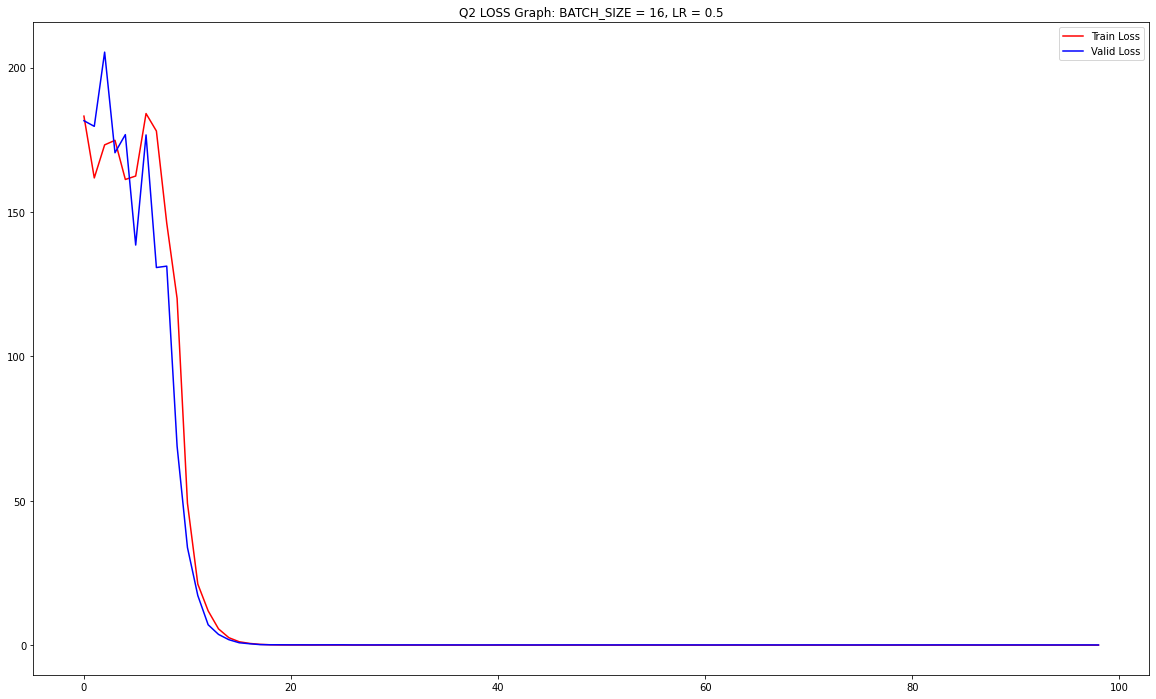

In [314]:
x = np.arange(len(train_loss[1:]))
plt.figure(figsize=(20, 12))
plt.plot(x, train_loss[1:], color='r', label='Train Loss')
plt.plot(x, valid_loss[1:], color='b', label='Valid Loss')
plt.title(f"Q2 LOSS Graph: BATCH_SIZE = {batch_size}, LR = {params['learning_rate']}")
plt.legend()
plt.show()

In [315]:
def test(params, test_loader, path):
    input_size = params['input_size']
    hidden_size = params['hidden_size']
    num_layers = params['num_layers']
    output_size = params['output_size']
    num_outputs = params['num_outputs']
    truths, preds = [[], []], [[], []]
    model = LSTM_multi(input_size, hidden_size, num_layers, output_size, batch_size)
    print(model)
    if MULTI_GPU:
        model = nn.DataParallel(model, device_ids=device_ids)
    model.load_state_dict(torch.load(path)['model'])
    model.to(device)
    
    model.eval()
    for X, y in tqdm(test_loader):
        X = X.to(device)
        for k in range(num_outputs):
            truths[k].extend(y[:, k, :].view(-1).cpu().numpy())
        with torch.no_grad():
            y_hat = model(X)
            for k in range(num_outputs):
                preds[k].extend(y_hat[k, :, :].view(-1).cpu().numpy())
    truths, preds = np.array(truths), np.array(preds)
    for vals in [truths, preds]:
        vals[0] = vals[0] * (test_max_power_range[1] - test_max_power_range[0]) + test_max_power_range[0]
        vals[1] = vals[1] * (test_max_tick_range[1] - test_max_tick_range[0]) + test_max_tick_range[0]
    scores = pd.DataFrame(columns=['MAPE', 'MAE', 'MSE', 'R2 Score'])
    for k in range(num_outputs):
        scores.loc[k, 'MAPE'] = mape(truths[k], preds[k])
        scores.loc[k, 'MAE'] = MAE(truths[k], preds[k])
        scores.loc[k, 'MSE'] = MSE(truths[k], preds[k])
        scores.loc[k, 'R2 Score'] = r2_score(truths[k], preds[k])
    return truths, preds, scores

In [316]:
truths, preds, scores = test(params, test_loader, 'model_max.pth')

LSTM_multi(
  (lstm): LSTM(87, 512, num_layers=20, batch_first=True)
  (linear_pred): Linear(in_features=512, out_features=1, bias=True)
  (linear_time): Linear(in_features=512, out_features=1, bias=True)
)


100%|██████████| 15/15 [00:00<00:00, 35.99it/s]


In [317]:
scores

,MAPE,MAE,MSE,R2 Score
0,18.009777,44572.007812,2861821696.0,-1.136822
1,56.004918,13.406018,291.592468,-0.861585


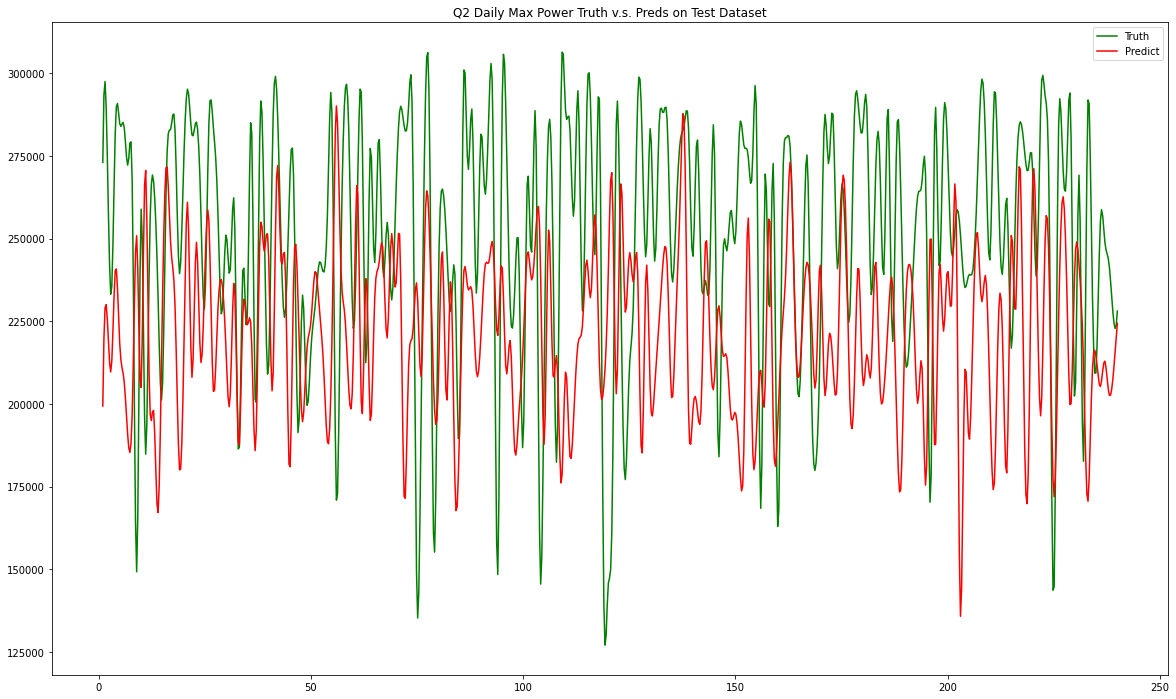

In [318]:
x = [i for i in range(1, len(truths[0]) + 1)]
x_smth = np.linspace(np.min(x), np.max(x), 900)
truths_smth = make_interp_spline(x, truths[0])(x_smth)
preds_smth = make_interp_spline(x, preds[0])(x_smth)
plt.figure(figsize=(20, 12))
plt.plot(x_smth, truths_smth, color='g', label='Truth')
plt.plot(x_smth, preds_smth, color='r', label='Predict')
plt.legend()
plt.title('Q2 Daily Max Power Truth v.s. Preds on Test Dataset')
plt.show()

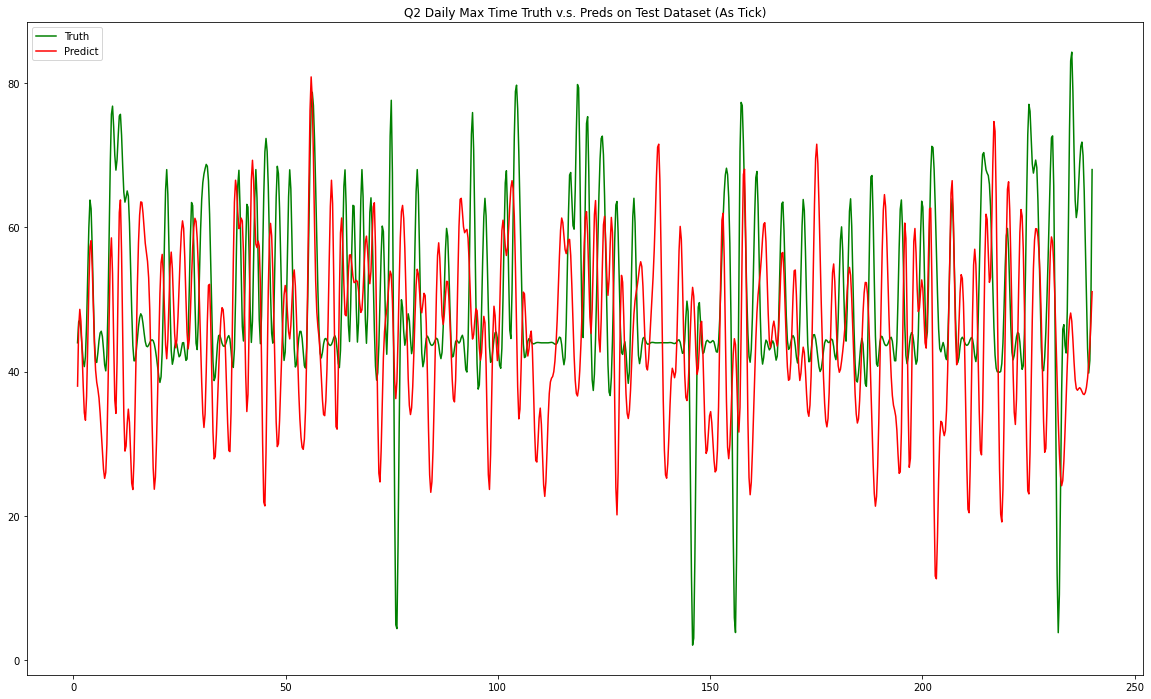

In [319]:
x = [i for i in range(1, len(truths[1]) + 1)]
x_smth = np.linspace(np.min(x), np.max(x), 900)
truths_smth = make_interp_spline(x, truths[1])(x_smth)
preds_smth = make_interp_spline(x, preds[1])(x_smth)
plt.figure(figsize=(20, 12))
plt.plot(x_smth, truths_smth, color='g', label='Truth')
plt.plot(x_smth, preds_smth, color='r', label='Predict')
plt.legend()
plt.title('Q2 Daily Max Time Truth v.s. Preds on Test Dataset (As Tick)')
plt.show()

### 2.1.2 single-output LSTM and train twice Trail

#### 2.1.2.1 Train Model for Power

In [357]:
def preprocessing(data, window_size, predict_size):
    X, y = [], []
    for i in range(len(data) - window_size - predict_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size:i + window_size + predict_size, :1].reshape(1, -1))
    X = torch.FloatTensor(np.array(X))
    y = torch.FloatTensor(np.array(y))
    return X, y

In [358]:
window_size, predict_size = 7, 1

X_train, y_train = preprocessing(train_max, window_size, predict_size)
X_valid, y_valid = preprocessing(valid_max, window_size, predict_size)
X_test, y_test = preprocessing(test_max, window_size, predict_size)

train_data = TensorDataset(X_train, y_train)
valid_data = TensorDataset(X_valid, y_valid)
test_data = TensorDataset(X_test, y_test)

In [359]:
batch_size = 16
train_loader = DataLoader(train_data, batch_size=batch_size * num_gpus,
                          shuffle=True, num_workers=2,
                          drop_last=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size * num_gpus,
                          shuffle=True, num_workers=2,
                          drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size * num_gpus,
                          shuffle=True, num_workers=2,
                          drop_last=True)

In [360]:
def train(params, train_loader, valid_loader, path):
    input_size = params['input_size']
    hidden_size = params['hidden_size']
    num_layers = params['num_layers']
    output_size = params['output_size']
    lr = params['learning_rate']
    wd = params['weight_decay']
    step_size = params['step_size']
    gamma = params['gamma']
    epochs = params['epochs']
    train_loss, valid_loss = [], []
    min_valid_loss = np.inf
    
    model = LSTM(input_size, hidden_size, num_layers, output_size, batch_size)
    print(model)
    if MULTI_GPU:
        model = nn.DataParallel(model, device_ids=device_ids)
    model.to(device)
    
    loss = nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size,
                                                gamma=gamma)
    if MULTI_GPU:
        optimizer = nn.DataParallel(optimizer, device_ids=device_ids)
        scheduler = nn.DataParallel(scheduler, device_ids=device_ids)
        
    for epoch in tqdm(range(epochs)):
        train_ls, valid_ls = [], []
        
        model.train()
        for step, (X, y) in enumerate(train_loader):
            optimizer.zero_grad()
            X = X.to(device)
            y = y.to(device)
            y_hat = model(X)
#             if step == 0:
#                 print(y_hat, y)
            l = loss(y_hat, y)
            train_ls.append(l.item())
            l.backward()
            optimizer.step()
            if step % 100 == 0:
                print("Step {}, train loss {:.6f}".format(step, l.item()))
        train_loss.append(np.mean(train_ls))
        
        model.eval()
        for step, (X, y) in enumerate(valid_loader):
            X = X.to(device)
            y = y.to(device)
            with torch.no_grad():
                y_hat = model(X)
#                 print(y_hat)
            l = loss(y_hat, y)
            valid_ls.append(l.item())
        valid_loss.append(np.mean(valid_ls))
        if valid_loss[-1] < min_valid_loss:
            state = {'model': model.state_dict()}
            torch.save(state, path)
            print('New best performance... Save new model checkpoint.')
            min_valid_loss = valid_loss[-1]
        
        print('Epoch [{:d}/{:d}], train loss {:.6f}, valid loss {:.6f}. Now best: {:.6f}'.format(
                epoch + 1, epochs, train_loss[-1], valid_loss[-1], min_valid_loss))
        scheduler.step()
    
    return train_loss, valid_loss

In [361]:
params = {'input_size': X_train.shape[2],
          'hidden_size': 128,
          'output_size': predict_size,
          'num_layers': 5, 
          'learning_rate': 0.5,
          'weight_decay': 1e-2,
          'step_size': 2,
          'gamma': 0.1,
          'epochs': 100}

In [325]:
train_loss, valid_loss = train(params, train_loader, valid_loader, 'model_max_1.pth')

LSTM(
  (lstm): LSTM(87, 128, num_layers=5, batch_first=True)
  (linear): Linear(in_features=128, out_features=1, bias=True)
)


  0%|          | 0/100 [00:00<?, ?it/s]

Step 0, train loss 0.424817


/opt/conda/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([16, 1, 1])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  1%|          | 1/100 [00:00<01:08,  1.46it/s]

New best performance... Save new model checkpoint.
Epoch [1/100], train loss 17.978659, valid loss 9.727285. Now best: 9.727285
Step 0, train loss 5.094822


  2%|▏         | 2/100 [00:01<01:06,  1.48it/s]

New best performance... Save new model checkpoint.
Epoch [2/100], train loss 3.687714, valid loss 1.089512. Now best: 1.089512
Step 0, train loss 2.037013


  3%|▎         | 3/100 [00:02<01:06,  1.47it/s]

New best performance... Save new model checkpoint.
Epoch [3/100], train loss 0.638255, valid loss 0.199351. Now best: 0.199351
Step 0, train loss 0.217131


  4%|▍         | 4/100 [00:02<01:05,  1.46it/s]

New best performance... Save new model checkpoint.
Epoch [4/100], train loss 0.135862, valid loss 0.095150. Now best: 0.095150
Step 0, train loss 0.112293


  5%|▌         | 5/100 [00:03<01:04,  1.48it/s]

Epoch [5/100], train loss 0.077076, valid loss 0.101093. Now best: 0.095150
Step 0, train loss 0.087869


  6%|▌         | 6/100 [00:04<01:02,  1.49it/s]

Epoch [6/100], train loss 0.078466, valid loss 0.099434. Now best: 0.095150
Step 0, train loss 0.070837


  7%|▋         | 7/100 [00:04<01:02,  1.49it/s]

New best performance... Save new model checkpoint.
Epoch [7/100], train loss 0.072616, valid loss 0.093572. Now best: 0.093572
Step 0, train loss 0.087310


  8%|▊         | 8/100 [00:05<01:01,  1.49it/s]

Epoch [8/100], train loss 0.071555, valid loss 0.098794. Now best: 0.093572
Step 0, train loss 0.087056


  9%|▉         | 9/100 [00:06<01:06,  1.38it/s]

New best performance... Save new model checkpoint.
Epoch [9/100], train loss 0.070434, valid loss 0.078338. Now best: 0.078338
Step 0, train loss 0.060772


 10%|█         | 10/100 [00:06<01:05,  1.37it/s]

Epoch [10/100], train loss 0.069766, valid loss 0.089868. Now best: 0.078338
Step 0, train loss 0.051425


 11%|█         | 11/100 [00:07<01:03,  1.40it/s]

New best performance... Save new model checkpoint.
Epoch [11/100], train loss 0.069070, valid loss 0.075548. Now best: 0.075548
Step 0, train loss 0.072039


 12%|█▏        | 12/100 [00:08<01:01,  1.43it/s]

Epoch [12/100], train loss 0.065606, valid loss 0.090540. Now best: 0.075548
Step 0, train loss 0.079864


 13%|█▎        | 13/100 [00:09<01:00,  1.44it/s]

Epoch [13/100], train loss 0.072499, valid loss 0.087878. Now best: 0.075548
Step 0, train loss 0.057060


 14%|█▍        | 14/100 [00:09<00:58,  1.46it/s]

Epoch [14/100], train loss 0.070551, valid loss 0.086641. Now best: 0.075548
Step 0, train loss 0.068051


 15%|█▌        | 15/100 [00:10<00:57,  1.48it/s]

Epoch [15/100], train loss 0.071238, valid loss 0.080573. Now best: 0.075548
Step 0, train loss 0.100592


 16%|█▌        | 16/100 [00:10<00:56,  1.48it/s]

New best performance... Save new model checkpoint.
Epoch [16/100], train loss 0.070024, valid loss 0.075056. Now best: 0.075056
Step 0, train loss 0.064407


 17%|█▋        | 17/100 [00:11<00:56,  1.48it/s]

Epoch [17/100], train loss 0.068242, valid loss 0.084056. Now best: 0.075056
Step 0, train loss 0.038912


 18%|█▊        | 18/100 [00:12<00:55,  1.48it/s]

Epoch [18/100], train loss 0.067500, valid loss 0.087048. Now best: 0.075056
Step 0, train loss 0.047634


 19%|█▉        | 19/100 [00:13<00:54,  1.49it/s]

Epoch [19/100], train loss 0.071107, valid loss 0.083872. Now best: 0.075056
Step 0, train loss 0.055788


 20%|██        | 20/100 [00:13<00:53,  1.49it/s]

Epoch [20/100], train loss 0.069373, valid loss 0.089194. Now best: 0.075056
Step 0, train loss 0.085821


 21%|██        | 21/100 [00:14<00:53,  1.49it/s]

Epoch [21/100], train loss 0.067513, valid loss 0.089202. Now best: 0.075056
Step 0, train loss 0.075752


 22%|██▏       | 22/100 [00:15<00:52,  1.48it/s]

Epoch [22/100], train loss 0.072672, valid loss 0.099617. Now best: 0.075056
Step 0, train loss 0.072354


 23%|██▎       | 23/100 [00:15<00:52,  1.48it/s]

Epoch [23/100], train loss 0.072869, valid loss 0.082623. Now best: 0.075056
Step 0, train loss 0.102633


 24%|██▍       | 24/100 [00:16<00:51,  1.48it/s]

Epoch [24/100], train loss 0.068958, valid loss 0.086159. Now best: 0.075056
Step 0, train loss 0.060877


 25%|██▌       | 25/100 [00:17<00:55,  1.36it/s]

Epoch [25/100], train loss 0.069592, valid loss 0.079461. Now best: 0.075056
Step 0, train loss 0.074332


 26%|██▌       | 26/100 [00:18<00:55,  1.33it/s]

Epoch [26/100], train loss 0.070394, valid loss 0.096306. Now best: 0.075056
Step 0, train loss 0.056368


 27%|██▋       | 27/100 [00:18<00:53,  1.37it/s]

Epoch [27/100], train loss 0.067599, valid loss 0.089528. Now best: 0.075056
Step 0, train loss 0.054311


 28%|██▊       | 28/100 [00:19<00:51,  1.40it/s]

Epoch [28/100], train loss 0.067771, valid loss 0.097390. Now best: 0.075056
Step 0, train loss 0.065206


 29%|██▉       | 29/100 [00:20<00:50,  1.42it/s]

Epoch [29/100], train loss 0.068397, valid loss 0.096839. Now best: 0.075056
Step 0, train loss 0.067462


 30%|███       | 30/100 [00:20<00:49,  1.42it/s]

Epoch [30/100], train loss 0.070679, valid loss 0.085892. Now best: 0.075056
Step 0, train loss 0.074808


 31%|███       | 31/100 [00:21<00:47,  1.44it/s]

Epoch [31/100], train loss 0.067742, valid loss 0.091613. Now best: 0.075056
Step 0, train loss 0.078633


 32%|███▏      | 32/100 [00:22<00:47,  1.44it/s]

Epoch [32/100], train loss 0.068439, valid loss 0.093340. Now best: 0.075056
Step 0, train loss 0.031225


 33%|███▎      | 33/100 [00:22<00:45,  1.46it/s]

Epoch [33/100], train loss 0.067990, valid loss 0.091314. Now best: 0.075056
Step 0, train loss 0.073652


 34%|███▍      | 34/100 [00:23<00:45,  1.47it/s]

Epoch [34/100], train loss 0.068539, valid loss 0.088715. Now best: 0.075056
Step 0, train loss 0.082986


 35%|███▌      | 35/100 [00:24<00:49,  1.31it/s]

Epoch [35/100], train loss 0.068426, valid loss 0.096938. Now best: 0.075056
Step 0, train loss 0.064280


 36%|███▌      | 36/100 [00:25<00:50,  1.27it/s]

Epoch [36/100], train loss 0.069413, valid loss 0.083427. Now best: 0.075056
Step 0, train loss 0.032507


 37%|███▋      | 37/100 [00:25<00:47,  1.34it/s]

Epoch [37/100], train loss 0.069484, valid loss 0.091321. Now best: 0.075056
Step 0, train loss 0.076946


 38%|███▊      | 38/100 [00:26<00:45,  1.38it/s]

Epoch [38/100], train loss 0.070844, valid loss 0.089800. Now best: 0.075056
Step 0, train loss 0.088564


 39%|███▉      | 39/100 [00:27<00:43,  1.41it/s]

Epoch [39/100], train loss 0.074453, valid loss 0.076287. Now best: 0.075056
Step 0, train loss 0.054452


 40%|████      | 40/100 [00:28<00:44,  1.35it/s]

Epoch [40/100], train loss 0.070940, valid loss 0.081432. Now best: 0.075056
Step 0, train loss 0.065233


 41%|████      | 41/100 [00:28<00:44,  1.32it/s]

Epoch [41/100], train loss 0.068646, valid loss 0.082690. Now best: 0.075056
Step 0, train loss 0.068682


 42%|████▏     | 42/100 [00:29<00:42,  1.36it/s]

Epoch [42/100], train loss 0.072835, valid loss 0.081001. Now best: 0.075056
Step 0, train loss 0.048416


 43%|████▎     | 43/100 [00:30<00:41,  1.39it/s]

Epoch [43/100], train loss 0.070447, valid loss 0.088163. Now best: 0.075056
Step 0, train loss 0.088118


 44%|████▍     | 44/100 [00:30<00:39,  1.41it/s]

Epoch [44/100], train loss 0.068568, valid loss 0.089951. Now best: 0.075056
Step 0, train loss 0.088908


 45%|████▌     | 45/100 [00:31<00:38,  1.44it/s]

Epoch [45/100], train loss 0.068837, valid loss 0.083529. Now best: 0.075056
Step 0, train loss 0.051225


 46%|████▌     | 46/100 [00:32<00:37,  1.45it/s]

Epoch [46/100], train loss 0.069391, valid loss 0.091206. Now best: 0.075056
Step 0, train loss 0.079101


 47%|████▋     | 47/100 [00:32<00:36,  1.47it/s]

Epoch [47/100], train loss 0.066743, valid loss 0.081598. Now best: 0.075056
Step 0, train loss 0.129706


 48%|████▊     | 48/100 [00:33<00:35,  1.48it/s]

Epoch [48/100], train loss 0.073153, valid loss 0.089443. Now best: 0.075056
Step 0, train loss 0.087857


 49%|████▉     | 49/100 [00:34<00:34,  1.48it/s]

New best performance... Save new model checkpoint.
Epoch [49/100], train loss 0.069557, valid loss 0.074652. Now best: 0.074652
Step 0, train loss 0.061469


 50%|█████     | 50/100 [00:34<00:33,  1.49it/s]

Epoch [50/100], train loss 0.070714, valid loss 0.083797. Now best: 0.074652
Step 0, train loss 0.042398


 51%|█████     | 51/100 [00:35<00:32,  1.50it/s]

Epoch [51/100], train loss 0.070102, valid loss 0.094509. Now best: 0.074652
Step 0, train loss 0.112022


 52%|█████▏    | 52/100 [00:36<00:31,  1.50it/s]

Epoch [52/100], train loss 0.068591, valid loss 0.083544. Now best: 0.074652
Step 0, train loss 0.056509


 53%|█████▎    | 53/100 [00:36<00:31,  1.51it/s]

Epoch [53/100], train loss 0.071423, valid loss 0.080460. Now best: 0.074652
Step 0, train loss 0.086660


 54%|█████▍    | 54/100 [00:37<00:30,  1.51it/s]

Epoch [54/100], train loss 0.069392, valid loss 0.078983. Now best: 0.074652
Step 0, train loss 0.055694


 55%|█████▌    | 55/100 [00:38<00:29,  1.50it/s]

Epoch [55/100], train loss 0.069441, valid loss 0.093848. Now best: 0.074652
Step 0, train loss 0.071039


 56%|█████▌    | 56/100 [00:39<00:31,  1.42it/s]

Epoch [56/100], train loss 0.070620, valid loss 0.086941. Now best: 0.074652
Step 0, train loss 0.066339


 57%|█████▋    | 57/100 [00:39<00:31,  1.37it/s]

Epoch [57/100], train loss 0.069741, valid loss 0.079709. Now best: 0.074652
Step 0, train loss 0.051287


 58%|█████▊    | 58/100 [00:40<00:29,  1.41it/s]

Epoch [58/100], train loss 0.069286, valid loss 0.088314. Now best: 0.074652
Step 0, train loss 0.077359


 59%|█████▉    | 59/100 [00:41<00:28,  1.44it/s]

Epoch [59/100], train loss 0.071668, valid loss 0.089551. Now best: 0.074652
Step 0, train loss 0.056673


 60%|██████    | 60/100 [00:41<00:27,  1.46it/s]

Epoch [60/100], train loss 0.069792, valid loss 0.088267. Now best: 0.074652
Step 0, train loss 0.046613


 61%|██████    | 61/100 [00:42<00:26,  1.47it/s]

Epoch [61/100], train loss 0.073815, valid loss 0.085681. Now best: 0.074652
Step 0, train loss 0.076128


 62%|██████▏   | 62/100 [00:43<00:25,  1.48it/s]

Epoch [62/100], train loss 0.069771, valid loss 0.080307. Now best: 0.074652
Step 0, train loss 0.068827


 63%|██████▎   | 63/100 [00:43<00:24,  1.49it/s]

Epoch [63/100], train loss 0.072015, valid loss 0.080317. Now best: 0.074652
Step 0, train loss 0.063149


 64%|██████▍   | 64/100 [00:44<00:24,  1.49it/s]

Epoch [64/100], train loss 0.066060, valid loss 0.089250. Now best: 0.074652
Step 0, train loss 0.053530


 65%|██████▌   | 65/100 [00:45<00:23,  1.50it/s]

Epoch [65/100], train loss 0.069886, valid loss 0.082178. Now best: 0.074652
Step 0, train loss 0.057111


 66%|██████▌   | 66/100 [00:45<00:22,  1.51it/s]

Epoch [66/100], train loss 0.071067, valid loss 0.097638. Now best: 0.074652
Step 0, train loss 0.096395


 67%|██████▋   | 67/100 [00:46<00:21,  1.50it/s]

Epoch [67/100], train loss 0.067499, valid loss 0.095364. Now best: 0.074652
Step 0, train loss 0.087818


 68%|██████▊   | 68/100 [00:47<00:21,  1.51it/s]

Epoch [68/100], train loss 0.067376, valid loss 0.079247. Now best: 0.074652
Step 0, train loss 0.059342


 69%|██████▉   | 69/100 [00:47<00:20,  1.51it/s]

Epoch [69/100], train loss 0.068445, valid loss 0.099739. Now best: 0.074652
Step 0, train loss 0.059178


 70%|███████   | 70/100 [00:48<00:20,  1.50it/s]

Epoch [70/100], train loss 0.068719, valid loss 0.093356. Now best: 0.074652
Step 0, train loss 0.072752


 71%|███████   | 71/100 [00:49<00:19,  1.48it/s]

Epoch [71/100], train loss 0.071034, valid loss 0.093025. Now best: 0.074652
Step 0, train loss 0.059920


 72%|███████▏  | 72/100 [00:50<00:21,  1.28it/s]

Epoch [72/100], train loss 0.074772, valid loss 0.088517. Now best: 0.074652
Step 0, train loss 0.072954


 73%|███████▎  | 73/100 [00:50<00:20,  1.29it/s]

Epoch [73/100], train loss 0.073137, valid loss 0.079175. Now best: 0.074652
Step 0, train loss 0.045423


 74%|███████▍  | 74/100 [00:51<00:19,  1.34it/s]

Epoch [74/100], train loss 0.070106, valid loss 0.096200. Now best: 0.074652
Step 0, train loss 0.060816


 75%|███████▌  | 75/100 [00:52<00:18,  1.37it/s]

Epoch [75/100], train loss 0.070103, valid loss 0.085250. Now best: 0.074652
Step 0, train loss 0.084839


 76%|███████▌  | 76/100 [00:53<00:17,  1.40it/s]

Epoch [76/100], train loss 0.070205, valid loss 0.095437. Now best: 0.074652
Step 0, train loss 0.087637


 77%|███████▋  | 77/100 [00:53<00:16,  1.43it/s]

Epoch [77/100], train loss 0.070479, valid loss 0.080124. Now best: 0.074652
Step 0, train loss 0.072736


 78%|███████▊  | 78/100 [00:54<00:15,  1.45it/s]

Epoch [78/100], train loss 0.073257, valid loss 0.080377. Now best: 0.074652
Step 0, train loss 0.106893


 79%|███████▉  | 79/100 [00:55<00:14,  1.47it/s]

Epoch [79/100], train loss 0.068252, valid loss 0.091988. Now best: 0.074652
Step 0, train loss 0.077161


 80%|████████  | 80/100 [00:56<00:15,  1.28it/s]

Epoch [80/100], train loss 0.069931, valid loss 0.090356. Now best: 0.074652
Step 0, train loss 0.058571


 81%|████████  | 81/100 [00:56<00:14,  1.28it/s]

Epoch [81/100], train loss 0.067961, valid loss 0.087832. Now best: 0.074652
Step 0, train loss 0.066151


 82%|████████▏ | 82/100 [00:57<00:13,  1.34it/s]

Epoch [82/100], train loss 0.070673, valid loss 0.089634. Now best: 0.074652
Step 0, train loss 0.091034


 83%|████████▎ | 83/100 [00:58<00:12,  1.39it/s]

Epoch [83/100], train loss 0.071828, valid loss 0.085258. Now best: 0.074652
Step 0, train loss 0.070086


 84%|████████▍ | 84/100 [00:58<00:11,  1.43it/s]

Epoch [84/100], train loss 0.067653, valid loss 0.094739. Now best: 0.074652
Step 0, train loss 0.062289


 85%|████████▌ | 85/100 [00:59<00:10,  1.45it/s]

Epoch [85/100], train loss 0.069297, valid loss 0.086882. Now best: 0.074652
Step 0, train loss 0.064727


 86%|████████▌ | 86/100 [01:00<00:09,  1.46it/s]

Epoch [86/100], train loss 0.072381, valid loss 0.086371. Now best: 0.074652
Step 0, train loss 0.090107


 87%|████████▋ | 87/100 [01:00<00:09,  1.43it/s]

Epoch [87/100], train loss 0.067429, valid loss 0.097649. Now best: 0.074652
Step 0, train loss 0.072276


 88%|████████▊ | 88/100 [01:01<00:08,  1.36it/s]

Epoch [88/100], train loss 0.069903, valid loss 0.085009. Now best: 0.074652
Step 0, train loss 0.063734


 89%|████████▉ | 89/100 [01:02<00:07,  1.39it/s]

Epoch [89/100], train loss 0.067616, valid loss 0.086352. Now best: 0.074652
Step 0, train loss 0.083092


 90%|█████████ | 90/100 [01:03<00:07,  1.42it/s]

Epoch [90/100], train loss 0.070156, valid loss 0.102049. Now best: 0.074652
Step 0, train loss 0.051953


 91%|█████████ | 91/100 [01:03<00:06,  1.44it/s]

Epoch [91/100], train loss 0.066078, valid loss 0.091756. Now best: 0.074652
Step 0, train loss 0.064722


 92%|█████████▏| 92/100 [01:04<00:05,  1.46it/s]

Epoch [92/100], train loss 0.070274, valid loss 0.090432. Now best: 0.074652
Step 0, train loss 0.033883


 93%|█████████▎| 93/100 [01:05<00:04,  1.47it/s]

Epoch [93/100], train loss 0.069453, valid loss 0.104350. Now best: 0.074652
Step 0, train loss 0.066819


 94%|█████████▍| 94/100 [01:05<00:04,  1.49it/s]

Epoch [94/100], train loss 0.067421, valid loss 0.097295. Now best: 0.074652
Step 0, train loss 0.114972


 95%|█████████▌| 95/100 [01:06<00:03,  1.50it/s]

Epoch [95/100], train loss 0.070880, valid loss 0.081410. Now best: 0.074652
Step 0, train loss 0.099111


 96%|█████████▌| 96/100 [01:07<00:02,  1.49it/s]

Epoch [96/100], train loss 0.065157, valid loss 0.091628. Now best: 0.074652
Step 0, train loss 0.058466


 97%|█████████▋| 97/100 [01:07<00:02,  1.49it/s]

Epoch [97/100], train loss 0.070766, valid loss 0.079688. Now best: 0.074652
Step 0, train loss 0.094103


 98%|█████████▊| 98/100 [01:08<00:01,  1.50it/s]

Epoch [98/100], train loss 0.069966, valid loss 0.085673. Now best: 0.074652
Step 0, train loss 0.087086


 99%|█████████▉| 99/100 [01:09<00:00,  1.49it/s]

Epoch [99/100], train loss 0.070941, valid loss 0.092315. Now best: 0.074652
Step 0, train loss 0.108221


100%|██████████| 100/100 [01:09<00:00,  1.43it/s]

Epoch [100/100], train loss 0.072796, valid loss 0.095237. Now best: 0.074652


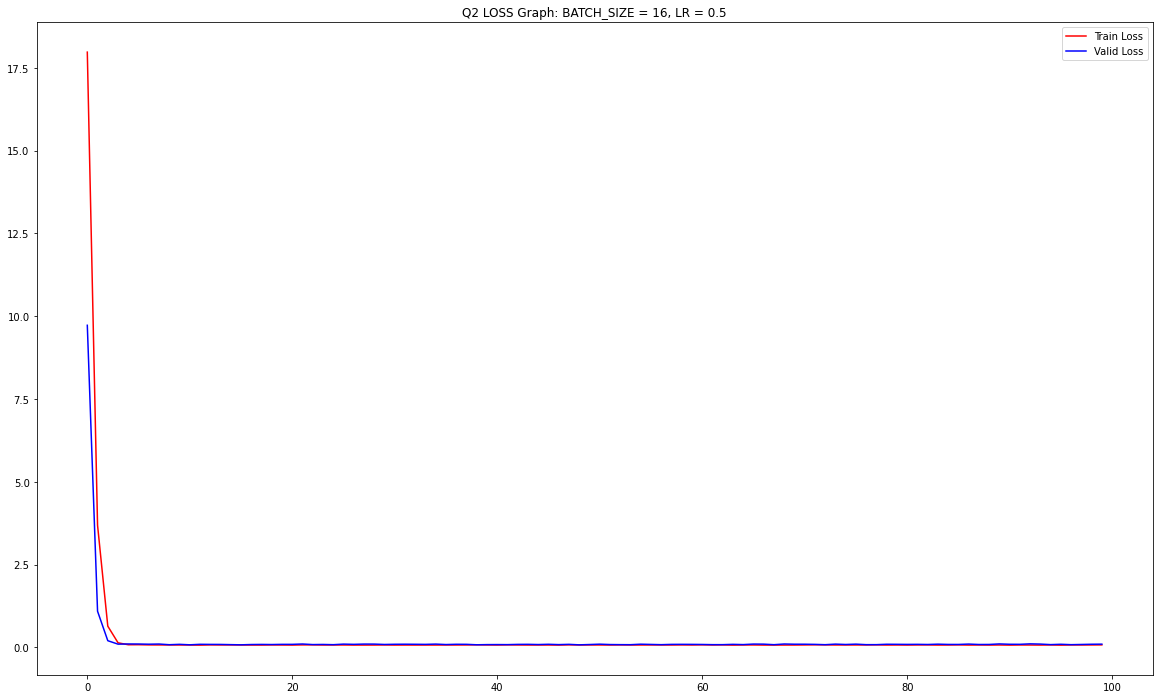

In [326]:
x = np.arange(len(train_loss))
plt.figure(figsize=(20, 12))
plt.plot(x, train_loss, color='r', label='Train Loss')
plt.plot(x, valid_loss, color='b', label='Valid Loss')
plt.title(f"Q2 LOSS Graph: BATCH_SIZE = {batch_size}, LR = {params['learning_rate']}")
plt.legend()
plt.show()

In [362]:
def test(params, test_loader, path):
    input_size = params['input_size']
    hidden_size = params['hidden_size']
    num_layers = params['num_layers']
    output_size = params['output_size']
    truths, preds = [], []
    model = LSTM(input_size, hidden_size, num_layers, output_size, batch_size)
    print(model)
    if MULTI_GPU:
        model = nn.DataParallel(model, device_ids=device_ids)
    model.load_state_dict(torch.load(path)['model'])
    model.to(device)
    
    model.eval()
    for X, y in tqdm(test_loader):
        X = X.to(device)
        truths.extend(y.view(-1).cpu().numpy())
        with torch.no_grad():
            y_hat = model(X)
            preds.extend(y_hat.view(-1).cpu().numpy())
    truths, preds = np.array(truths), np.array(preds)
    truths = truths * (test_max_power_range[1] - test_max_power_range[0]) + test_max_power_range[0]
    preds = preds * (test_max_power_range[1] - test_max_power_range[0]) + test_max_power_range[0]
    print('MAPE:', mape(truths, preds))
    print('MAE:', MAE(truths, preds))
    print('MSE:', MSE(truths, preds))
    print('R2 Score:', r2_score(truths, preds))
    
    return truths, preds

In [328]:
truths, preds = test(params, test_loader, 'model_max_1.pth')

LSTM(
  (lstm): LSTM(87, 128, num_layers=5, batch_first=True)
  (linear): Linear(in_features=128, out_features=1, bias=True)
)


100%|██████████| 16/16 [00:00<00:00, 91.54it/s]

MAPE: 18.49059909582138
MAE: 45586.234
MSE: 3046448600.0
R2 Score: -1.249043252783788


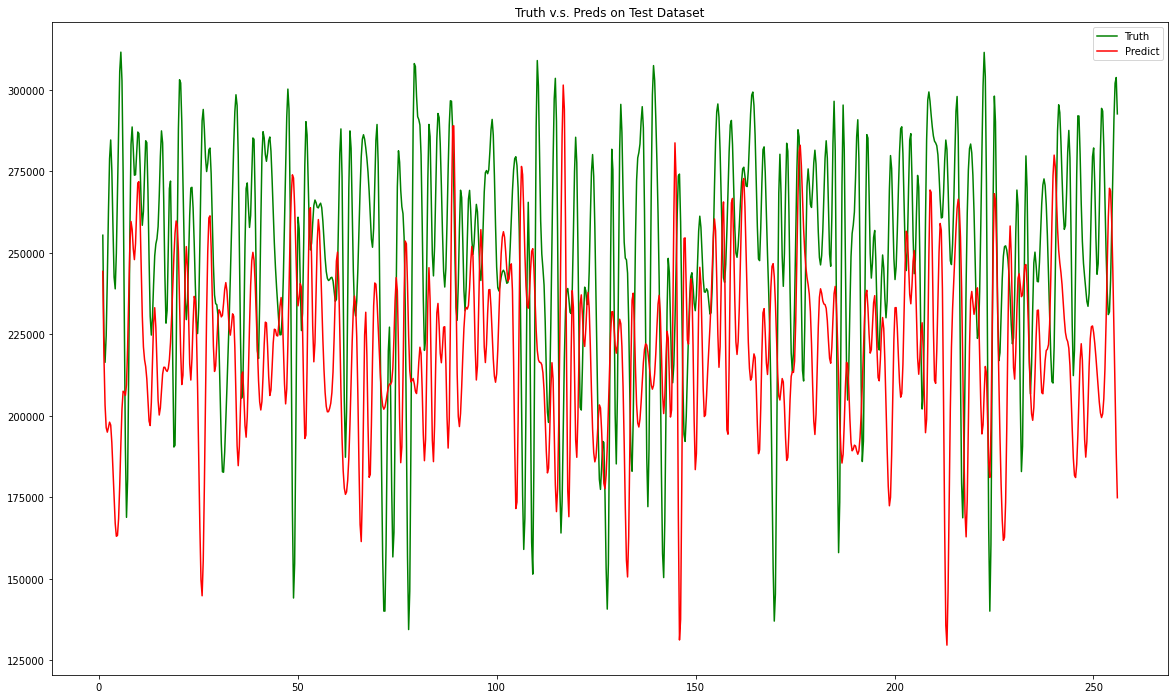

In [329]:
x = [i for i in range(1, len(truths) + 1)]
x_smth = np.linspace(np.min(x), np.max(x), 900)
truths_smth = make_interp_spline(x, truths)(x_smth)
preds_smth = make_interp_spline(x, preds)(x_smth)
plt.figure(figsize=(20, 12))
plt.plot(x_smth, truths_smth, color='g', label='Truth')
plt.plot(x_smth, preds_smth, color='r', label='Predict')
plt.legend()
plt.title('Truth v.s. Preds on Test Dataset')
plt.show()

#### 2.1.2.2 Train Model for Tick

In [363]:
def preprocessing(data, window_size, predict_size):
    X, y = [], []
    for i in range(len(data) - window_size - predict_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size:i + window_size + predict_size, 1:2].reshape(1, -1))
    X = torch.FloatTensor(np.array(X))
    y = torch.FloatTensor(np.array(y))
    return X, y

In [379]:
window_size, predict_size = 7, 1

X_train, y_train = preprocessing(train_max, window_size, predict_size)
X_valid, y_valid = preprocessing(valid_max, window_size, predict_size)
X_test, y_test = preprocessing(test_max, window_size, predict_size)

train_data = TensorDataset(X_train, y_train)
valid_data = TensorDataset(X_valid, y_valid)
test_data = TensorDataset(X_test, y_test)

In [380]:
batch_size = 16
train_loader = DataLoader(train_data, batch_size=batch_size * num_gpus,
                          shuffle=True, num_workers=2,
                          drop_last=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size * num_gpus,
                          shuffle=True, num_workers=2,
                          drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size * num_gpus,
                          shuffle=True, num_workers=2,
                          drop_last=True)

In [381]:
params = {'input_size': X_train.shape[2],
          'hidden_size': 32,
          'output_size': predict_size,
          'num_layers': 5, 
          'learning_rate': 0.5,
          'weight_decay': 1e-3,
          'step_size': 2,
          'gamma': 0.1,
          'epochs': 100}

In [382]:
train_loss, valid_loss = train(params, train_loader, valid_loader, 'model_max_2.pth')

LSTM(
  (lstm): LSTM(87, 32, num_layers=5, batch_first=True)
  (linear): Linear(in_features=32, out_features=1, bias=True)
)


  0%|          | 0/100 [00:00<?, ?it/s]

Step 0, train loss 0.356016


/opt/conda/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([16, 1, 1])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  1%|          | 1/100 [00:00<01:05,  1.52it/s]

New best performance... Save new model checkpoint.
Epoch [1/100], train loss 2.337135, valid loss 0.266206. Now best: 0.266206
Step 0, train loss 0.297390


  2%|▏         | 2/100 [00:01<01:04,  1.51it/s]

New best performance... Save new model checkpoint.
Epoch [2/100], train loss 0.073089, valid loss 0.157282. Now best: 0.157282
Step 0, train loss 0.018928


  3%|▎         | 3/100 [00:01<01:04,  1.51it/s]

New best performance... Save new model checkpoint.
Epoch [3/100], train loss 0.024483, valid loss 0.152498. Now best: 0.152498
Step 0, train loss 0.023484


  4%|▍         | 4/100 [00:02<01:03,  1.51it/s]

Epoch [4/100], train loss 0.024423, valid loss 0.163753. Now best: 0.152498
Step 0, train loss 0.024942


  5%|▌         | 5/100 [00:03<01:03,  1.51it/s]

Epoch [5/100], train loss 0.024084, valid loss 0.154350. Now best: 0.152498
Step 0, train loss 0.033183


  6%|▌         | 6/100 [00:04<01:09,  1.35it/s]

New best performance... Save new model checkpoint.
Epoch [6/100], train loss 0.023920, valid loss 0.152019. Now best: 0.152019
Step 0, train loss 0.039911


  7%|▋         | 7/100 [00:04<01:06,  1.40it/s]

Epoch [7/100], train loss 0.024024, valid loss 0.152653. Now best: 0.152019
Step 0, train loss 0.012136


  8%|▊         | 8/100 [00:05<01:03,  1.44it/s]

Epoch [8/100], train loss 0.024023, valid loss 0.158009. Now best: 0.152019
Step 0, train loss 0.014529


  9%|▉         | 9/100 [00:06<01:03,  1.44it/s]

Epoch [9/100], train loss 0.023855, valid loss 0.156241. Now best: 0.152019
Step 0, train loss 0.039642


 10%|█         | 10/100 [00:06<01:01,  1.46it/s]

Epoch [10/100], train loss 0.023957, valid loss 0.155844. Now best: 0.152019
Step 0, train loss 0.013646


 11%|█         | 11/100 [00:07<00:59,  1.49it/s]

Epoch [11/100], train loss 0.023849, valid loss 0.156184. Now best: 0.152019
Step 0, train loss 0.026626


 12%|█▏        | 12/100 [00:08<00:58,  1.50it/s]

Epoch [12/100], train loss 0.023850, valid loss 0.152911. Now best: 0.152019
Step 0, train loss 0.027988


 13%|█▎        | 13/100 [00:08<00:57,  1.51it/s]

Epoch [13/100], train loss 0.023813, valid loss 0.157329. Now best: 0.152019
Step 0, train loss 0.025146


 14%|█▍        | 14/100 [00:09<00:56,  1.52it/s]

Epoch [14/100], train loss 0.024011, valid loss 0.158095. Now best: 0.152019
Step 0, train loss 0.033123


 15%|█▌        | 15/100 [00:10<00:55,  1.52it/s]

Epoch [15/100], train loss 0.023844, valid loss 0.156538. Now best: 0.152019
Step 0, train loss 0.033544


 16%|█▌        | 16/100 [00:10<00:55,  1.53it/s]

Epoch [16/100], train loss 0.023803, valid loss 0.152505. Now best: 0.152019
Step 0, train loss 0.052830


 17%|█▋        | 17/100 [00:11<00:54,  1.52it/s]

Epoch [17/100], train loss 0.023854, valid loss 0.158390. Now best: 0.152019
Step 0, train loss 0.038365


 18%|█▊        | 18/100 [00:12<00:53,  1.53it/s]

Epoch [18/100], train loss 0.023897, valid loss 0.154063. Now best: 0.152019
Step 0, train loss 0.030730


 19%|█▉        | 19/100 [00:12<00:53,  1.51it/s]

Epoch [19/100], train loss 0.023790, valid loss 0.153783. Now best: 0.152019
Step 0, train loss 0.025045


 20%|██        | 20/100 [00:13<01:01,  1.31it/s]

Epoch [20/100], train loss 0.023857, valid loss 0.155283. Now best: 0.152019
Step 0, train loss 0.034871


 21%|██        | 21/100 [00:14<01:02,  1.27it/s]

Epoch [21/100], train loss 0.023904, valid loss 0.155963. Now best: 0.152019
Step 0, train loss 0.017776


 22%|██▏       | 22/100 [00:15<01:01,  1.27it/s]

Epoch [22/100], train loss 0.023780, valid loss 0.154212. Now best: 0.152019
Step 0, train loss 0.048535


 23%|██▎       | 23/100 [00:16<00:57,  1.33it/s]

Epoch [23/100], train loss 0.023823, valid loss 0.155785. Now best: 0.152019
Step 0, train loss 0.022612


 24%|██▍       | 24/100 [00:16<00:55,  1.38it/s]

Epoch [24/100], train loss 0.023772, valid loss 0.155562. Now best: 0.152019
Step 0, train loss 0.017007


 25%|██▌       | 25/100 [00:17<00:52,  1.42it/s]

Epoch [25/100], train loss 0.023929, valid loss 0.157204. Now best: 0.152019
Step 0, train loss 0.019985


 26%|██▌       | 26/100 [00:18<00:51,  1.45it/s]

Epoch [26/100], train loss 0.023893, valid loss 0.155121. Now best: 0.152019
Step 0, train loss 0.040930


 27%|██▋       | 27/100 [00:18<00:49,  1.47it/s]

Epoch [27/100], train loss 0.023886, valid loss 0.157798. Now best: 0.152019
Step 0, train loss 0.011931


 28%|██▊       | 28/100 [00:19<00:48,  1.49it/s]

Epoch [28/100], train loss 0.023850, valid loss 0.154658. Now best: 0.152019
Step 0, train loss 0.014913


 29%|██▉       | 29/100 [00:20<00:47,  1.50it/s]

Epoch [29/100], train loss 0.023987, valid loss 0.156680. Now best: 0.152019
Step 0, train loss 0.019390


 30%|███       | 30/100 [00:20<00:46,  1.51it/s]

Epoch [30/100], train loss 0.023861, valid loss 0.156588. Now best: 0.152019
Step 0, train loss 0.033564


 31%|███       | 31/100 [00:21<00:45,  1.51it/s]

Epoch [31/100], train loss 0.023853, valid loss 0.153511. Now best: 0.152019
Step 0, train loss 0.014333


 32%|███▏      | 32/100 [00:21<00:44,  1.52it/s]

Epoch [32/100], train loss 0.023861, valid loss 0.153254. Now best: 0.152019
Step 0, train loss 0.011363


 33%|███▎      | 33/100 [00:22<00:44,  1.52it/s]

Epoch [33/100], train loss 0.023857, valid loss 0.159289. Now best: 0.152019
Step 0, train loss 0.024436


 34%|███▍      | 34/100 [00:23<00:43,  1.52it/s]

Epoch [34/100], train loss 0.023849, valid loss 0.156245. Now best: 0.152019
Step 0, train loss 0.040776


 35%|███▌      | 35/100 [00:23<00:42,  1.52it/s]

Epoch [35/100], train loss 0.023905, valid loss 0.153088. Now best: 0.152019
Step 0, train loss 0.017702


 36%|███▌      | 36/100 [00:24<00:41,  1.53it/s]

Epoch [36/100], train loss 0.023858, valid loss 0.153657. Now best: 0.152019
Step 0, train loss 0.022737


 37%|███▋      | 37/100 [00:25<00:41,  1.53it/s]

Epoch [37/100], train loss 0.023830, valid loss 0.156368. Now best: 0.152019
Step 0, train loss 0.036900


 38%|███▊      | 38/100 [00:26<00:44,  1.39it/s]

Epoch [38/100], train loss 0.023632, valid loss 0.152822. Now best: 0.152019
Step 0, train loss 0.024579


 39%|███▉      | 39/100 [00:26<00:42,  1.42it/s]

Epoch [39/100], train loss 0.023848, valid loss 0.153720. Now best: 0.152019
Step 0, train loss 0.015490


 40%|████      | 40/100 [00:27<00:41,  1.45it/s]

Epoch [40/100], train loss 0.023839, valid loss 0.156453. Now best: 0.152019
Step 0, train loss 0.016820


 41%|████      | 41/100 [00:28<00:40,  1.47it/s]

Epoch [41/100], train loss 0.023833, valid loss 0.154287. Now best: 0.152019
Step 0, train loss 0.022785


 42%|████▏     | 42/100 [00:28<00:38,  1.49it/s]

Epoch [42/100], train loss 0.023922, valid loss 0.155449. Now best: 0.152019
Step 0, train loss 0.035261


 43%|████▎     | 43/100 [00:29<00:38,  1.50it/s]

Epoch [43/100], train loss 0.023791, valid loss 0.156327. Now best: 0.152019
Step 0, train loss 0.031597


 44%|████▍     | 44/100 [00:30<00:37,  1.50it/s]

Epoch [44/100], train loss 0.023848, valid loss 0.155406. Now best: 0.152019
Step 0, train loss 0.017248


 45%|████▌     | 45/100 [00:30<00:36,  1.50it/s]

Epoch [45/100], train loss 0.023724, valid loss 0.154916. Now best: 0.152019
Step 0, train loss 0.021064


 46%|████▌     | 46/100 [00:31<00:35,  1.50it/s]

Epoch [46/100], train loss 0.024028, valid loss 0.157078. Now best: 0.152019
Step 0, train loss 0.018226


 47%|████▋     | 47/100 [00:32<00:35,  1.51it/s]

Epoch [47/100], train loss 0.023815, valid loss 0.153770. Now best: 0.152019
Step 0, train loss 0.021379


 48%|████▊     | 48/100 [00:32<00:34,  1.51it/s]

Epoch [48/100], train loss 0.023852, valid loss 0.157395. Now best: 0.152019
Step 0, train loss 0.018263


 49%|████▉     | 49/100 [00:33<00:33,  1.51it/s]

Epoch [49/100], train loss 0.023846, valid loss 0.156285. Now best: 0.152019
Step 0, train loss 0.015835


 50%|█████     | 50/100 [00:34<00:33,  1.51it/s]

Epoch [50/100], train loss 0.023849, valid loss 0.159539. Now best: 0.152019
Step 0, train loss 0.030535


 51%|█████     | 51/100 [00:34<00:32,  1.51it/s]

Epoch [51/100], train loss 0.023944, valid loss 0.155853. Now best: 0.152019
Step 0, train loss 0.021765


 52%|█████▏    | 52/100 [00:35<00:31,  1.51it/s]

Epoch [52/100], train loss 0.023826, valid loss 0.155043. Now best: 0.152019
Step 0, train loss 0.020481


 53%|█████▎    | 53/100 [00:36<00:31,  1.51it/s]

Epoch [53/100], train loss 0.024022, valid loss 0.160050. Now best: 0.152019
Step 0, train loss 0.015327


 54%|█████▍    | 54/100 [00:36<00:33,  1.38it/s]

Epoch [54/100], train loss 0.023834, valid loss 0.157587. Now best: 0.152019
Step 0, train loss 0.037749


 55%|█████▌    | 55/100 [00:37<00:33,  1.36it/s]

Epoch [55/100], train loss 0.023838, valid loss 0.157050. Now best: 0.152019
Step 0, train loss 0.027814


 56%|█████▌    | 56/100 [00:38<00:31,  1.40it/s]

Epoch [56/100], train loss 0.023871, valid loss 0.155317. Now best: 0.152019
Step 0, train loss 0.033359


 57%|█████▋    | 57/100 [00:39<00:31,  1.38it/s]

Epoch [57/100], train loss 0.023889, valid loss 0.156664. Now best: 0.152019
Step 0, train loss 0.014745


 58%|█████▊    | 58/100 [00:39<00:29,  1.41it/s]

Epoch [58/100], train loss 0.023751, valid loss 0.159194. Now best: 0.152019
Step 0, train loss 0.040112


 59%|█████▉    | 59/100 [00:40<00:28,  1.42it/s]

Epoch [59/100], train loss 0.023811, valid loss 0.152660. Now best: 0.152019
Step 0, train loss 0.019280


 60%|██████    | 60/100 [00:41<00:27,  1.43it/s]

Epoch [60/100], train loss 0.023847, valid loss 0.152517. Now best: 0.152019
Step 0, train loss 0.017731


 61%|██████    | 61/100 [00:41<00:26,  1.46it/s]

Epoch [61/100], train loss 0.023838, valid loss 0.155251. Now best: 0.152019
Step 0, train loss 0.019840


 62%|██████▏   | 62/100 [00:42<00:25,  1.47it/s]

Epoch [62/100], train loss 0.023810, valid loss 0.155469. Now best: 0.152019
Step 0, train loss 0.042415


 63%|██████▎   | 63/100 [00:43<00:24,  1.49it/s]

Epoch [63/100], train loss 0.023860, valid loss 0.156028. Now best: 0.152019
Step 0, train loss 0.027741


 64%|██████▍   | 64/100 [00:43<00:24,  1.50it/s]

Epoch [64/100], train loss 0.023845, valid loss 0.154822. Now best: 0.152019
Step 0, train loss 0.028021


 65%|██████▌   | 65/100 [00:44<00:25,  1.36it/s]

Epoch [65/100], train loss 0.023988, valid loss 0.153223. Now best: 0.152019
Step 0, train loss 0.019845


 66%|██████▌   | 66/100 [00:45<00:26,  1.29it/s]

Epoch [66/100], train loss 0.023913, valid loss 0.155087. Now best: 0.152019
Step 0, train loss 0.019304


 67%|██████▋   | 67/100 [00:46<00:24,  1.36it/s]

Epoch [67/100], train loss 0.023952, valid loss 0.154514. Now best: 0.152019
Step 0, train loss 0.036712


 68%|██████▊   | 68/100 [00:46<00:22,  1.40it/s]

Epoch [68/100], train loss 0.023800, valid loss 0.157094. Now best: 0.152019
Step 0, train loss 0.039933


 69%|██████▉   | 69/100 [00:47<00:22,  1.38it/s]

Epoch [69/100], train loss 0.023796, valid loss 0.153692. Now best: 0.152019
Step 0, train loss 0.018792


 70%|███████   | 70/100 [00:48<00:22,  1.35it/s]

Epoch [70/100], train loss 0.023815, valid loss 0.155660. Now best: 0.152019
Step 0, train loss 0.022381


 71%|███████   | 71/100 [00:49<00:20,  1.40it/s]

Epoch [71/100], train loss 0.023855, valid loss 0.154015. Now best: 0.152019
Step 0, train loss 0.018402


 72%|███████▏  | 72/100 [00:49<00:19,  1.43it/s]

Epoch [72/100], train loss 0.023864, valid loss 0.157787. Now best: 0.152019
Step 0, train loss 0.020872


 73%|███████▎  | 73/100 [00:50<00:18,  1.46it/s]

Epoch [73/100], train loss 0.023910, valid loss 0.155444. Now best: 0.152019
Step 0, train loss 0.012782


 74%|███████▍  | 74/100 [00:50<00:17,  1.49it/s]

Epoch [74/100], train loss 0.023975, valid loss 0.156523. Now best: 0.152019
Step 0, train loss 0.029573


 75%|███████▌  | 75/100 [00:51<00:16,  1.50it/s]

Epoch [75/100], train loss 0.023870, valid loss 0.157018. Now best: 0.152019
Step 0, train loss 0.023856


 76%|███████▌  | 76/100 [00:52<00:15,  1.51it/s]

Epoch [76/100], train loss 0.023876, valid loss 0.155906. Now best: 0.152019
Step 0, train loss 0.031833


 77%|███████▋  | 77/100 [00:52<00:15,  1.51it/s]

Epoch [77/100], train loss 0.023881, valid loss 0.155461. Now best: 0.152019
Step 0, train loss 0.022883


 78%|███████▊  | 78/100 [00:53<00:14,  1.51it/s]

Epoch [78/100], train loss 0.023873, valid loss 0.155473. Now best: 0.152019
Step 0, train loss 0.026513


 79%|███████▉  | 79/100 [00:54<00:13,  1.51it/s]

Epoch [79/100], train loss 0.023860, valid loss 0.155860. Now best: 0.152019
Step 0, train loss 0.017231


 80%|████████  | 80/100 [00:54<00:13,  1.51it/s]

Epoch [80/100], train loss 0.023934, valid loss 0.154826. Now best: 0.152019
Step 0, train loss 0.034418


 81%|████████  | 81/100 [00:55<00:12,  1.51it/s]

Epoch [81/100], train loss 0.023863, valid loss 0.155921. Now best: 0.152019
Step 0, train loss 0.015965


 82%|████████▏ | 82/100 [00:56<00:11,  1.51it/s]

Epoch [82/100], train loss 0.023858, valid loss 0.158212. Now best: 0.152019
Step 0, train loss 0.013042


 83%|████████▎ | 83/100 [00:56<00:11,  1.51it/s]

Epoch [83/100], train loss 0.023825, valid loss 0.157392. Now best: 0.152019
Step 0, train loss 0.018530


 84%|████████▍ | 84/100 [00:57<00:10,  1.51it/s]

Epoch [84/100], train loss 0.023927, valid loss 0.156178. Now best: 0.152019
Step 0, train loss 0.018040


 85%|████████▌ | 85/100 [00:58<00:09,  1.51it/s]

Epoch [85/100], train loss 0.023904, valid loss 0.154735. Now best: 0.152019
Step 0, train loss 0.028299


 86%|████████▌ | 86/100 [00:59<00:10,  1.37it/s]

Epoch [86/100], train loss 0.023882, valid loss 0.158463. Now best: 0.152019
Step 0, train loss 0.024358


 87%|████████▋ | 87/100 [00:59<00:09,  1.40it/s]

Epoch [87/100], train loss 0.023841, valid loss 0.158015. Now best: 0.152019
Step 0, train loss 0.035760


 88%|████████▊ | 88/100 [01:00<00:08,  1.44it/s]

Epoch [88/100], train loss 0.023870, valid loss 0.157461. Now best: 0.152019
Step 0, train loss 0.014663


 89%|████████▉ | 89/100 [01:01<00:07,  1.47it/s]

Epoch [89/100], train loss 0.023992, valid loss 0.155524. Now best: 0.152019
Step 0, train loss 0.028608


 90%|█████████ | 90/100 [01:01<00:06,  1.49it/s]

Epoch [90/100], train loss 0.023965, valid loss 0.156176. Now best: 0.152019
Step 0, train loss 0.009412


 91%|█████████ | 91/100 [01:02<00:05,  1.50it/s]

Epoch [91/100], train loss 0.023805, valid loss 0.155732. Now best: 0.152019
Step 0, train loss 0.028786


 92%|█████████▏| 92/100 [01:03<00:05,  1.51it/s]

Epoch [92/100], train loss 0.024098, valid loss 0.154414. Now best: 0.152019
Step 0, train loss 0.018724


 93%|█████████▎| 93/100 [01:03<00:04,  1.51it/s]

Epoch [93/100], train loss 0.023899, valid loss 0.154625. Now best: 0.152019
Step 0, train loss 0.029930


 94%|█████████▍| 94/100 [01:04<00:03,  1.52it/s]

Epoch [94/100], train loss 0.023877, valid loss 0.156010. Now best: 0.152019
Step 0, train loss 0.025026


 95%|█████████▌| 95/100 [01:05<00:03,  1.50it/s]

Epoch [95/100], train loss 0.024262, valid loss 0.153551. Now best: 0.152019
Step 0, train loss 0.018583


 96%|█████████▌| 96/100 [01:05<00:02,  1.51it/s]

Epoch [96/100], train loss 0.023858, valid loss 0.157863. Now best: 0.152019
Step 0, train loss 0.045474


 97%|█████████▋| 97/100 [01:06<00:01,  1.50it/s]

Epoch [97/100], train loss 0.023891, valid loss 0.157922. Now best: 0.152019
Step 0, train loss 0.021287


 98%|█████████▊| 98/100 [01:07<00:01,  1.51it/s]

Epoch [98/100], train loss 0.023858, valid loss 0.153746. Now best: 0.152019
Step 0, train loss 0.019129


 99%|█████████▉| 99/100 [01:07<00:00,  1.52it/s]

Epoch [99/100], train loss 0.023862, valid loss 0.156106. Now best: 0.152019
Step 0, train loss 0.027223


100%|██████████| 100/100 [01:08<00:00,  1.46it/s]

Epoch [100/100], train loss 0.023842, valid loss 0.155325. Now best: 0.152019


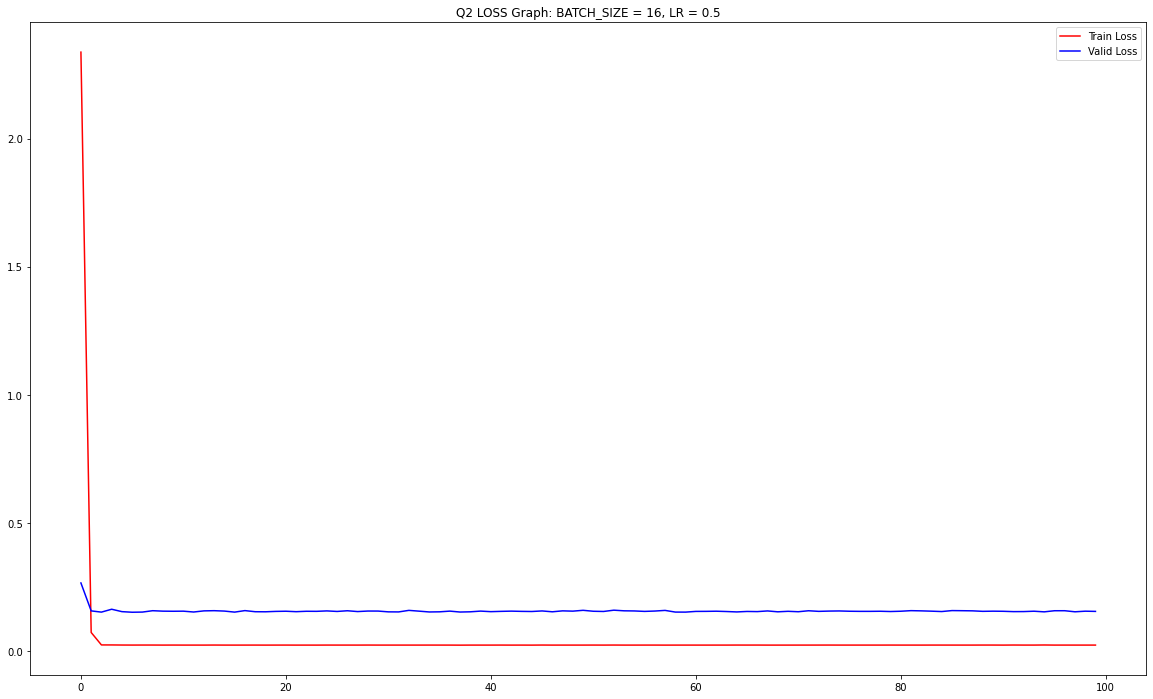

In [383]:
x = np.arange(len(train_loss))
plt.figure(figsize=(20, 12))
plt.plot(x, train_loss, color='r', label='Train Loss')
plt.plot(x, valid_loss, color='b', label='Valid Loss')
plt.title(f"Q2 LOSS Graph: BATCH_SIZE = {batch_size}, LR = {params['learning_rate']}")
plt.legend()
plt.show()

In [376]:
def test(params, test_loader, path):
    input_size = params['input_size']
    hidden_size = params['hidden_size']
    num_layers = params['num_layers']
    output_size = params['output_size']
    truths, preds = [], []
    model = LSTM(input_size, hidden_size, num_layers, output_size, batch_size)
    print(model)
    if MULTI_GPU:
        model = nn.DataParallel(model, device_ids=device_ids)
    model.load_state_dict(torch.load(path)['model'])
    model.to(device)
    
    model.eval()
    for X, y in tqdm(test_loader):
        X = X.to(device)
        truths.extend(y.view(-1).cpu().numpy())
        with torch.no_grad():
            y_hat = model(X)
            preds.extend(y_hat.view(-1).cpu().numpy())
    truths, preds = np.array(truths), np.array(preds)
    truths = truths * (test_max_tick_range[1] - test_max_tick_range[0]) + test_max_tick_range[0]
    preds = preds * (test_max_tick_range[1] - test_max_tick_range[0]) + test_max_tick_range[0]
    print('MAPE:', mape(truths, preds))
    print('MAE:', MAE(truths, preds))
    print('MSE:', MSE(truths, preds))
    print('R2 Score:', r2_score(truths, preds))
    
    return truths, preds

In [377]:
truths, preds = test(params, test_loader, 'model_max_2.pth')

LSTM(
  (lstm): LSTM(87, 24, num_layers=5, batch_first=True)
  (linear): Linear(in_features=24, out_features=1, bias=True)
)


100%|██████████| 16/16 [00:00<00:00, 90.37it/s]

MAPE: 49.14259314537048
MAE: 15.118595
MSE: 353.20758
R2 Score: -1.283854564632013


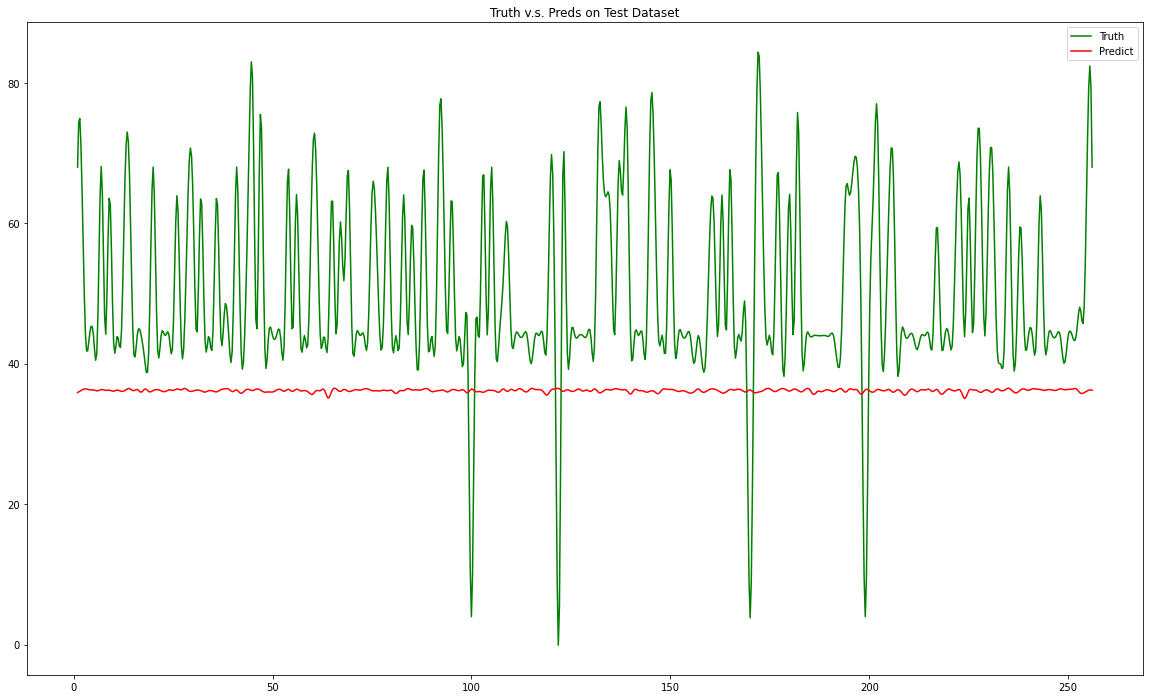

In [378]:
x = [i for i in range(1, len(truths) + 1)]
x_smth = np.linspace(np.min(x), np.max(x), 900)
truths_smth = make_interp_spline(x, truths)(x_smth)
preds_smth = make_interp_spline(x, preds)(x_smth)
plt.figure(figsize=(20, 12))
plt.plot(x_smth, truths_smth, color='g', label='Truth')
plt.plot(x_smth, preds_smth, color='r', label='Predict')
plt.legend()
plt.title('Truth v.s. Preds on Test Dataset')
plt.show()

## 2.2 For Daily Min

In [339]:
def preprocessing(data, window_size, predict_size):
    X, y = [], []
    for i in range(len(data) - window_size - predict_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size:i + window_size + predict_size, :2].reshape(2, -1))
    X = torch.FloatTensor(np.array(X))
    y = torch.FloatTensor(np.array(y))
    return X, y

In [340]:
window_size, predict_size = 7, 1

X_train, y_train = preprocessing(train_min, window_size, predict_size)
X_valid, y_valid = preprocessing(valid_min, window_size, predict_size)
X_test, y_test = preprocessing(test_min, window_size, predict_size)

train_data = TensorDataset(X_train, y_train)
valid_data = TensorDataset(X_valid, y_valid)
test_data = TensorDataset(X_test, y_test)

In [341]:
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size * num_gpus,
                          shuffle=True, num_workers=2,
                          drop_last=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size * num_gpus,
                          shuffle=True, num_workers=2,
                          drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size * num_gpus,
                          shuffle=True, num_workers=2,
                          drop_last=True)

In [342]:
print('Train set:', X_train.shape, y_train.shape)
print('Valid set:', X_valid.shape, y_valid.shape)
print('Test set:', X_test.shape, y_test.shape)

Train set: torch.Size([929, 7, 87]) torch.Size([929, 2, 1])
Valid set: torch.Size([125, 7, 87]) torch.Size([125, 2, 1])
Test set: torch.Size([261, 7, 87]) torch.Size([261, 2, 1])


In [343]:
params = {'input_size': X_train.shape[2],
          'hidden_size': 512,
          'output_size': predict_size,
          'num_outputs': 2,
          'num_layers': 50, 
          'learning_rate': 0.5,
          'weight_decay': 1e-2,
          'step_size': 10,
          'gamma': 0.1,
          'epochs': 100}

In [344]:
def train(params, train_loader, valid_loader, path):
    input_size = params['input_size']
    hidden_size = params['hidden_size']
    num_layers = params['num_layers']
    output_size = params['output_size']
    lr = params['learning_rate']
    wd = params['weight_decay']
    step_size = params['step_size']
    gamma = params['gamma']
    epochs = params['epochs']
    num_outputs = params['num_outputs']
    train_loss, valid_loss = [], []
    min_valid_loss = np.inf
    
    model = LSTM_multi(input_size, hidden_size, num_layers, output_size, batch_size)
    print(model)
    if MULTI_GPU:
        model = nn.DataParallel(model, device_ids=device_ids)
    model.to(device)
    
    loss = nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size,
                                                gamma=gamma)
    if MULTI_GPU:
        optimizer = nn.DataParallel(optimizer, device_ids=device_ids)
        scheduler = nn.DataParallel(scheduler, device_ids=device_ids)
        
    for epoch in tqdm(range(epochs)):
        train_ls, valid_ls = [], []
        
        model.train()
        for step, (X, y) in enumerate(train_loader):
            X = X.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            l = 0
            for k in range(num_outputs):
                l += loss(y_hat[k, :, :], y[:, k, :])
            l /= num_outputs
            train_ls.append(l.item())
            l.backward()
            optimizer.step()
            if step % 10 == 0:
                print("Step {}, train loss {:.6f}".format(step, l.item()))
        train_loss.append(np.mean(train_ls))
        
        model.eval()
        for step, (X, y) in enumerate(valid_loader):
            X = X.to(device)
            y = y.to(device)
            with torch.no_grad():
                y_hat = model(X)
            l = 0
            for k in range(num_outputs):
                l += loss(y_hat[k, :, :], y[:, k, :])
            l /= num_outputs
            valid_ls.append(l.item())
        valid_loss.append(np.mean(valid_ls))
        if valid_loss[-1] < min_valid_loss:
            state = {'model': model.state_dict()}
            torch.save(state, path)
            min_valid_loss = valid_loss[-1]
        
        print('Epoch [{:d}/{:d}], train loss {:.6f}, valid loss {:.6f}. Now best: {:.6f}'.format(
                epoch + 1, epochs, train_loss[-1], valid_loss[-1], min_valid_loss))
        scheduler.step()
    
    return train_loss, valid_loss

In [345]:
train_loss, valid_loss = train(params, train_loader, valid_loader, 'model_min.pth')

LSTM_multi(
  (lstm): LSTM(87, 512, num_layers=50, batch_first=True)
  (linear_pred): Linear(in_features=512, out_features=1, bias=True)
  (linear_time): Linear(in_features=512, out_features=1, bias=True)
)


  0%|          | 0/100 [00:00<?, ?it/s]

Step 0, train loss 0.249059
Step 10, train loss 59.365273


  1%|          | 1/100 [00:03<05:37,  3.41s/it]

Epoch [1/100], train loss 50.981548, valid loss 34.468979. Now best: 34.468979
Step 0, train loss 50.901913
Step 10, train loss 38.980366


  2%|▏         | 2/100 [00:05<04:02,  2.47s/it]

Epoch [2/100], train loss 50.010408, valid loss 41.215790. Now best: 34.468979
Step 0, train loss 36.748070
Step 10, train loss 32.067390


  3%|▎         | 3/100 [00:07<03:38,  2.25s/it]

Epoch [3/100], train loss 35.124960, valid loss 40.749916. Now best: 34.468979
Step 0, train loss 37.343025
Step 10, train loss 38.911961


  4%|▍         | 4/100 [00:10<04:24,  2.76s/it]

Epoch [4/100], train loss 33.415543, valid loss 31.579840. Now best: 31.579840
Step 0, train loss 40.176880
Step 10, train loss 27.145601


  5%|▌         | 5/100 [00:15<05:23,  3.41s/it]

Epoch [5/100], train loss 33.506470, valid loss 23.459679. Now best: 23.459679
Step 0, train loss 29.402967
Step 10, train loss 27.221916


  6%|▌         | 6/100 [00:20<06:14,  3.98s/it]

Epoch [6/100], train loss 29.739783, valid loss 22.289135. Now best: 22.289135
Step 0, train loss 20.207783
Step 10, train loss 33.661221


  7%|▋         | 7/100 [00:22<05:04,  3.28s/it]

Epoch [7/100], train loss 31.303151, valid loss 31.180599. Now best: 22.289135
Step 0, train loss 26.186752
Step 10, train loss 35.105087


  8%|▊         | 8/100 [00:24<04:18,  2.81s/it]

Epoch [8/100], train loss 31.066192, valid loss 33.708691. Now best: 22.289135
Step 0, train loss 33.482903
Step 10, train loss 35.915306


  9%|▉         | 9/100 [00:25<03:48,  2.51s/it]

Epoch [9/100], train loss 35.594525, valid loss 30.807579. Now best: 22.289135
Step 0, train loss 41.031475
Step 10, train loss 27.205999


 10%|█         | 10/100 [00:27<03:30,  2.34s/it]

Epoch [10/100], train loss 37.324199, valid loss 37.998547. Now best: 22.289135
Step 0, train loss 38.862305
Step 10, train loss 33.252850


 11%|█         | 11/100 [00:29<03:17,  2.22s/it]

Epoch [11/100], train loss 32.414163, valid loss 32.315197. Now best: 22.289135
Step 0, train loss 34.487267
Step 10, train loss 13.271669


 12%|█▏        | 12/100 [00:33<03:42,  2.52s/it]

Epoch [12/100], train loss 20.895052, valid loss 14.304338. Now best: 14.304338
Step 0, train loss 9.726052
Step 10, train loss 9.649206


 13%|█▎        | 13/100 [00:36<03:57,  2.73s/it]

Epoch [13/100], train loss 9.545663, valid loss 5.611719. Now best: 5.611719
Step 0, train loss 5.394519
Step 10, train loss 3.770896


 14%|█▍        | 14/100 [00:39<04:15,  2.97s/it]

Epoch [14/100], train loss 4.156520, valid loss 3.156783. Now best: 3.156783
Step 0, train loss 2.105870
Step 10, train loss 1.560643


 15%|█▌        | 15/100 [00:44<04:57,  3.51s/it]

Epoch [15/100], train loss 1.812292, valid loss 1.387380. Now best: 1.387380
Step 0, train loss 1.098359
Step 10, train loss 0.914610


 16%|█▌        | 16/100 [00:47<04:47,  3.43s/it]

Epoch [16/100], train loss 0.923840, valid loss 0.631527. Now best: 0.631527
Step 0, train loss 0.529531
Step 10, train loss 0.337935


 17%|█▋        | 17/100 [00:51<04:44,  3.42s/it]

Epoch [17/100], train loss 0.378775, valid loss 0.309963. Now best: 0.309963
Step 0, train loss 0.350903
Step 10, train loss 0.186427


 18%|█▊        | 18/100 [00:54<04:37,  3.38s/it]

Epoch [18/100], train loss 0.192011, valid loss 0.210212. Now best: 0.210212
Step 0, train loss 0.119684
Step 10, train loss 0.081583


 19%|█▉        | 19/100 [00:58<04:42,  3.48s/it]

Epoch [19/100], train loss 0.101588, valid loss 0.123561. Now best: 0.123561
Step 0, train loss 0.087738
Step 10, train loss 0.038617


 20%|██        | 20/100 [01:01<04:34,  3.44s/it]

Epoch [20/100], train loss 0.059624, valid loss 0.107307. Now best: 0.107307
Step 0, train loss 0.035143
Step 10, train loss 0.062473


 21%|██        | 21/100 [01:03<03:56,  3.00s/it]

Epoch [21/100], train loss 0.043683, valid loss 0.109884. Now best: 0.107307
Step 0, train loss 0.042245
Step 10, train loss 0.045824


 22%|██▏       | 22/100 [01:06<04:00,  3.09s/it]

Epoch [22/100], train loss 0.041908, valid loss 0.096440. Now best: 0.096440
Step 0, train loss 0.049413
Step 10, train loss 0.043676


 23%|██▎       | 23/100 [01:10<04:02,  3.15s/it]

Epoch [23/100], train loss 0.042827, valid loss 0.087675. Now best: 0.087675
Step 0, train loss 0.032375
Step 10, train loss 0.039603


 24%|██▍       | 24/100 [01:12<03:33,  2.81s/it]

Epoch [24/100], train loss 0.036512, valid loss 0.101163. Now best: 0.087675
Step 0, train loss 0.028863
Step 10, train loss 0.032980


 25%|██▌       | 25/100 [01:14<03:11,  2.55s/it]

Epoch [25/100], train loss 0.037169, valid loss 0.105651. Now best: 0.087675
Step 0, train loss 0.032974
Step 10, train loss 0.034388


 26%|██▌       | 26/100 [01:15<02:52,  2.34s/it]

Epoch [26/100], train loss 0.035412, valid loss 0.099929. Now best: 0.087675
Step 0, train loss 0.038733
Step 10, train loss 0.031689


 27%|██▋       | 27/100 [01:19<03:09,  2.60s/it]

Epoch [27/100], train loss 0.034093, valid loss 0.085182. Now best: 0.085182
Step 0, train loss 0.034382
Step 10, train loss 0.026090


 28%|██▊       | 28/100 [01:20<02:50,  2.36s/it]

Epoch [28/100], train loss 0.032970, valid loss 0.100649. Now best: 0.085182
Step 0, train loss 0.030895
Step 10, train loss 0.031764


 29%|██▉       | 29/100 [01:22<02:36,  2.20s/it]

Epoch [29/100], train loss 0.031629, valid loss 0.085559. Now best: 0.085182
Step 0, train loss 0.035180
Step 10, train loss 0.029939


 30%|███       | 30/100 [01:26<02:58,  2.56s/it]

Epoch [30/100], train loss 0.032154, valid loss 0.084499. Now best: 0.084499
Step 0, train loss 0.041183
Step 10, train loss 0.025190


 31%|███       | 31/100 [01:27<02:40,  2.33s/it]

Epoch [31/100], train loss 0.030908, valid loss 0.087141. Now best: 0.084499
Step 0, train loss 0.028174
Step 10, train loss 0.036555


 32%|███▏      | 32/100 [01:29<02:28,  2.19s/it]

Epoch [32/100], train loss 0.031046, valid loss 0.089636. Now best: 0.084499
Step 0, train loss 0.037553
Step 10, train loss 0.024746


 33%|███▎      | 33/100 [01:31<02:19,  2.09s/it]

Epoch [33/100], train loss 0.031090, valid loss 0.090618. Now best: 0.084499
Step 0, train loss 0.019502
Step 10, train loss 0.035267


 34%|███▍      | 34/100 [01:33<02:12,  2.01s/it]

Epoch [34/100], train loss 0.030897, valid loss 0.093406. Now best: 0.084499
Step 0, train loss 0.038403
Step 10, train loss 0.025469


 35%|███▌      | 35/100 [01:35<02:08,  1.98s/it]

Epoch [35/100], train loss 0.029605, valid loss 0.096117. Now best: 0.084499
Step 0, train loss 0.022081
Step 10, train loss 0.033629


 36%|███▌      | 36/100 [01:37<02:03,  1.93s/it]

Epoch [36/100], train loss 0.030439, valid loss 0.088746. Now best: 0.084499
Step 0, train loss 0.021572
Step 10, train loss 0.031488


 37%|███▋      | 37/100 [01:40<02:26,  2.32s/it]

Epoch [37/100], train loss 0.029536, valid loss 0.081869. Now best: 0.081869
Step 0, train loss 0.034397
Step 10, train loss 0.033826


 38%|███▊      | 38/100 [01:42<02:18,  2.23s/it]

Epoch [38/100], train loss 0.031548, valid loss 0.098139. Now best: 0.081869
Step 0, train loss 0.033916
Step 10, train loss 0.030130


 39%|███▉      | 39/100 [01:44<02:10,  2.14s/it]

Epoch [39/100], train loss 0.029519, valid loss 0.087470. Now best: 0.081869
Step 0, train loss 0.028206
Step 10, train loss 0.037108


 40%|████      | 40/100 [01:46<02:05,  2.09s/it]

Epoch [40/100], train loss 0.030553, valid loss 0.087498. Now best: 0.081869
Step 0, train loss 0.026558
Step 10, train loss 0.021025


 41%|████      | 41/100 [01:48<01:58,  2.01s/it]

Epoch [41/100], train loss 0.030290, valid loss 0.095481. Now best: 0.081869
Step 0, train loss 0.036521
Step 10, train loss 0.036673


 42%|████▏     | 42/100 [01:49<01:53,  1.95s/it]

Epoch [42/100], train loss 0.029261, valid loss 0.093082. Now best: 0.081869
Step 0, train loss 0.021390
Step 10, train loss 0.029805


 43%|████▎     | 43/100 [01:51<01:48,  1.91s/it]

Epoch [43/100], train loss 0.029938, valid loss 0.091544. Now best: 0.081869
Step 0, train loss 0.033898
Step 10, train loss 0.023906


 44%|████▍     | 44/100 [01:53<01:45,  1.89s/it]

Epoch [44/100], train loss 0.029894, valid loss 0.099713. Now best: 0.081869
Step 0, train loss 0.022226
Step 10, train loss 0.024550


 45%|████▌     | 45/100 [01:55<01:42,  1.86s/it]

Epoch [45/100], train loss 0.030182, valid loss 0.085251. Now best: 0.081869
Step 0, train loss 0.029571
Step 10, train loss 0.033966


 46%|████▌     | 46/100 [01:58<02:05,  2.32s/it]

Epoch [46/100], train loss 0.029314, valid loss 0.081153. Now best: 0.081153
Step 0, train loss 0.029458
Step 10, train loss 0.033165


 47%|████▋     | 47/100 [02:00<01:55,  2.18s/it]

Epoch [47/100], train loss 0.029246, valid loss 0.081743. Now best: 0.081153
Step 0, train loss 0.041659
Step 10, train loss 0.031871


 48%|████▊     | 48/100 [02:02<01:48,  2.08s/it]

Epoch [48/100], train loss 0.031129, valid loss 0.087259. Now best: 0.081153
Step 0, train loss 0.031456
Step 10, train loss 0.023228


 49%|████▉     | 49/100 [02:04<01:42,  2.01s/it]

Epoch [49/100], train loss 0.029546, valid loss 0.088236. Now best: 0.081153
Step 0, train loss 0.036050
Step 10, train loss 0.026775


 50%|█████     | 50/100 [02:06<01:37,  1.95s/it]

Epoch [50/100], train loss 0.030929, valid loss 0.089512. Now best: 0.081153
Step 0, train loss 0.026498
Step 10, train loss 0.030410


 51%|█████     | 51/100 [02:08<01:34,  1.94s/it]

Epoch [51/100], train loss 0.029726, valid loss 0.094264. Now best: 0.081153
Step 0, train loss 0.032496
Step 10, train loss 0.030924


 52%|█████▏    | 52/100 [02:09<01:31,  1.91s/it]

Epoch [52/100], train loss 0.029303, valid loss 0.090747. Now best: 0.081153
Step 0, train loss 0.033370
Step 10, train loss 0.034178


 53%|█████▎    | 53/100 [02:11<01:28,  1.88s/it]

Epoch [53/100], train loss 0.030712, valid loss 0.091274. Now best: 0.081153
Step 0, train loss 0.038279
Step 10, train loss 0.024647


 54%|█████▍    | 54/100 [02:13<01:28,  1.91s/it]

Epoch [54/100], train loss 0.030073, valid loss 0.084655. Now best: 0.081153
Step 0, train loss 0.030396
Step 10, train loss 0.033638


 55%|█████▌    | 55/100 [02:15<01:26,  1.91s/it]

Epoch [55/100], train loss 0.029653, valid loss 0.090450. Now best: 0.081153
Step 0, train loss 0.022683
Step 10, train loss 0.021836


 56%|█████▌    | 56/100 [02:17<01:22,  1.88s/it]

Epoch [56/100], train loss 0.030751, valid loss 0.088006. Now best: 0.081153
Step 0, train loss 0.026498
Step 10, train loss 0.026291


 57%|█████▋    | 57/100 [02:19<01:21,  1.89s/it]

Epoch [57/100], train loss 0.029903, valid loss 0.083232. Now best: 0.081153
Step 0, train loss 0.032465
Step 10, train loss 0.032208


 58%|█████▊    | 58/100 [02:21<01:18,  1.87s/it]

Epoch [58/100], train loss 0.031399, valid loss 0.097064. Now best: 0.081153
Step 0, train loss 0.032437
Step 10, train loss 0.039943


 59%|█████▉    | 59/100 [02:22<01:15,  1.85s/it]

Epoch [59/100], train loss 0.029966, valid loss 0.084577. Now best: 0.081153
Step 0, train loss 0.033554
Step 10, train loss 0.035009


 60%|██████    | 60/100 [02:24<01:13,  1.84s/it]

Epoch [60/100], train loss 0.029509, valid loss 0.096498. Now best: 0.081153
Step 0, train loss 0.025751
Step 10, train loss 0.021873


 61%|██████    | 61/100 [02:26<01:11,  1.83s/it]

Epoch [61/100], train loss 0.030184, valid loss 0.087566. Now best: 0.081153
Step 0, train loss 0.027876
Step 10, train loss 0.032735


 62%|██████▏   | 62/100 [02:28<01:10,  1.84s/it]

Epoch [62/100], train loss 0.029287, valid loss 0.090042. Now best: 0.081153
Step 0, train loss 0.034301
Step 10, train loss 0.027694


 63%|██████▎   | 63/100 [02:30<01:09,  1.87s/it]

Epoch [63/100], train loss 0.029261, valid loss 0.089730. Now best: 0.081153
Step 0, train loss 0.027373
Step 10, train loss 0.022155


 64%|██████▍   | 64/100 [02:32<01:07,  1.86s/it]

Epoch [64/100], train loss 0.029443, valid loss 0.093254. Now best: 0.081153
Step 0, train loss 0.025869
Step 10, train loss 0.037573


 65%|██████▌   | 65/100 [02:34<01:04,  1.85s/it]

Epoch [65/100], train loss 0.030743, valid loss 0.093274. Now best: 0.081153
Step 0, train loss 0.032899
Step 10, train loss 0.027352


 66%|██████▌   | 66/100 [02:35<01:02,  1.84s/it]

Epoch [66/100], train loss 0.030606, valid loss 0.082231. Now best: 0.081153
Step 0, train loss 0.026772
Step 10, train loss 0.029205


 67%|██████▋   | 67/100 [02:37<01:00,  1.83s/it]

Epoch [67/100], train loss 0.029074, valid loss 0.089886. Now best: 0.081153
Step 0, train loss 0.031347
Step 10, train loss 0.034162


 68%|██████▊   | 68/100 [02:41<01:12,  2.27s/it]

Epoch [68/100], train loss 0.029823, valid loss 0.080034. Now best: 0.080034
Step 0, train loss 0.030920
Step 10, train loss 0.030322


 69%|██████▉   | 69/100 [02:42<01:06,  2.16s/it]

Epoch [69/100], train loss 0.030387, valid loss 0.088657. Now best: 0.080034
Step 0, train loss 0.027224
Step 10, train loss 0.028338


 70%|███████   | 70/100 [02:44<01:03,  2.11s/it]

Epoch [70/100], train loss 0.028767, valid loss 0.082217. Now best: 0.080034
Step 0, train loss 0.033289
Step 10, train loss 0.028288


 71%|███████   | 71/100 [02:46<01:00,  2.08s/it]

Epoch [71/100], train loss 0.029663, valid loss 0.092161. Now best: 0.080034
Step 0, train loss 0.032218
Step 10, train loss 0.029825


 72%|███████▏  | 72/100 [02:48<00:55,  2.00s/it]

Epoch [72/100], train loss 0.030631, valid loss 0.082223. Now best: 0.080034
Step 0, train loss 0.029322
Step 10, train loss 0.038436


 73%|███████▎  | 73/100 [02:50<00:52,  1.94s/it]

Epoch [73/100], train loss 0.030499, valid loss 0.084090. Now best: 0.080034
Step 0, train loss 0.033236
Step 10, train loss 0.021090


 74%|███████▍  | 74/100 [02:52<00:50,  1.93s/it]

Epoch [74/100], train loss 0.030387, valid loss 0.085519. Now best: 0.080034
Step 0, train loss 0.028323
Step 10, train loss 0.024640


 75%|███████▌  | 75/100 [02:54<00:47,  1.90s/it]

Epoch [75/100], train loss 0.029200, valid loss 0.086003. Now best: 0.080034
Step 0, train loss 0.023213
Step 10, train loss 0.032496


 76%|███████▌  | 76/100 [02:56<00:45,  1.88s/it]

Epoch [76/100], train loss 0.030613, valid loss 0.092554. Now best: 0.080034
Step 0, train loss 0.030810
Step 10, train loss 0.040749


 77%|███████▋  | 77/100 [02:57<00:42,  1.86s/it]

Epoch [77/100], train loss 0.029223, valid loss 0.084239. Now best: 0.080034
Step 0, train loss 0.032853
Step 10, train loss 0.031880


 78%|███████▊  | 78/100 [02:59<00:40,  1.85s/it]

Epoch [78/100], train loss 0.030616, valid loss 0.084275. Now best: 0.080034
Step 0, train loss 0.037583
Step 10, train loss 0.026102


 79%|███████▉  | 79/100 [03:01<00:38,  1.84s/it]

Epoch [79/100], train loss 0.031442, valid loss 0.095409. Now best: 0.080034
Step 0, train loss 0.027111
Step 10, train loss 0.036993


 80%|████████  | 80/100 [03:03<00:37,  1.87s/it]

Epoch [80/100], train loss 0.029370, valid loss 0.090403. Now best: 0.080034
Step 0, train loss 0.032929
Step 10, train loss 0.036485


 81%|████████  | 81/100 [03:05<00:35,  1.86s/it]

Epoch [81/100], train loss 0.029827, valid loss 0.090555. Now best: 0.080034
Step 0, train loss 0.026536
Step 10, train loss 0.027484


 82%|████████▏ | 82/100 [03:07<00:33,  1.84s/it]

Epoch [82/100], train loss 0.029736, valid loss 0.086045. Now best: 0.080034
Step 0, train loss 0.025571
Step 10, train loss 0.030413


 83%|████████▎ | 83/100 [03:08<00:31,  1.84s/it]

Epoch [83/100], train loss 0.030615, valid loss 0.094830. Now best: 0.080034
Step 0, train loss 0.033340
Step 10, train loss 0.025483


 84%|████████▍ | 84/100 [03:12<00:36,  2.25s/it]

Epoch [84/100], train loss 0.029228, valid loss 0.078788. Now best: 0.078788
Step 0, train loss 0.034569
Step 10, train loss 0.037246


 85%|████████▌ | 85/100 [03:14<00:32,  2.18s/it]

Epoch [85/100], train loss 0.030220, valid loss 0.079895. Now best: 0.078788
Step 0, train loss 0.024647
Step 10, train loss 0.033689


 86%|████████▌ | 86/100 [03:16<00:29,  2.12s/it]

Epoch [86/100], train loss 0.029007, valid loss 0.087288. Now best: 0.078788
Step 0, train loss 0.026983
Step 10, train loss 0.025016


 87%|████████▋ | 87/100 [03:18<00:27,  2.08s/it]

Epoch [87/100], train loss 0.029752, valid loss 0.090102. Now best: 0.078788
Step 0, train loss 0.037410
Step 10, train loss 0.031718


 88%|████████▊ | 88/100 [03:19<00:24,  2.00s/it]

Epoch [88/100], train loss 0.030143, valid loss 0.090708. Now best: 0.078788
Step 0, train loss 0.038077
Step 10, train loss 0.018925


 89%|████████▉ | 89/100 [03:21<00:21,  1.94s/it]

Epoch [89/100], train loss 0.030611, valid loss 0.094258. Now best: 0.078788
Step 0, train loss 0.030848
Step 10, train loss 0.034338


 90%|█████████ | 90/100 [03:23<00:19,  1.90s/it]

Epoch [90/100], train loss 0.030760, valid loss 0.096531. Now best: 0.078788
Step 0, train loss 0.025893
Step 10, train loss 0.029790


 91%|█████████ | 91/100 [03:25<00:17,  1.90s/it]

Epoch [91/100], train loss 0.031152, valid loss 0.084053. Now best: 0.078788
Step 0, train loss 0.028568
Step 10, train loss 0.033519


 92%|█████████▏| 92/100 [03:27<00:15,  1.88s/it]

Epoch [92/100], train loss 0.030214, valid loss 0.081244. Now best: 0.078788
Step 0, train loss 0.027053
Step 10, train loss 0.027933


 93%|█████████▎| 93/100 [03:29<00:12,  1.86s/it]

Epoch [93/100], train loss 0.029579, valid loss 0.090869. Now best: 0.078788
Step 0, train loss 0.023051
Step 10, train loss 0.025168


 94%|█████████▍| 94/100 [03:30<00:11,  1.84s/it]

Epoch [94/100], train loss 0.028734, valid loss 0.082068. Now best: 0.078788
Step 0, train loss 0.031213
Step 10, train loss 0.030724


 95%|█████████▌| 95/100 [03:32<00:09,  1.84s/it]

Epoch [95/100], train loss 0.030148, valid loss 0.090447. Now best: 0.078788
Step 0, train loss 0.030855
Step 10, train loss 0.026680


 96%|█████████▌| 96/100 [03:34<00:07,  1.83s/it]

Epoch [96/100], train loss 0.030927, valid loss 0.087771. Now best: 0.078788
Step 0, train loss 0.048858
Step 10, train loss 0.028949


 97%|█████████▋| 97/100 [03:36<00:05,  1.85s/it]

Epoch [97/100], train loss 0.029665, valid loss 0.091799. Now best: 0.078788
Step 0, train loss 0.029168
Step 10, train loss 0.029441


 98%|█████████▊| 98/100 [03:38<00:03,  1.84s/it]

Epoch [98/100], train loss 0.030868, valid loss 0.088740. Now best: 0.078788
Step 0, train loss 0.029971
Step 10, train loss 0.033848


 99%|█████████▉| 99/100 [03:40<00:01,  1.83s/it]

Epoch [99/100], train loss 0.031601, valid loss 0.081817. Now best: 0.078788
Step 0, train loss 0.033649
Step 10, train loss 0.022445


100%|██████████| 100/100 [03:41<00:00,  2.22s/it]

Epoch [100/100], train loss 0.030297, valid loss 0.092081. Now best: 0.078788


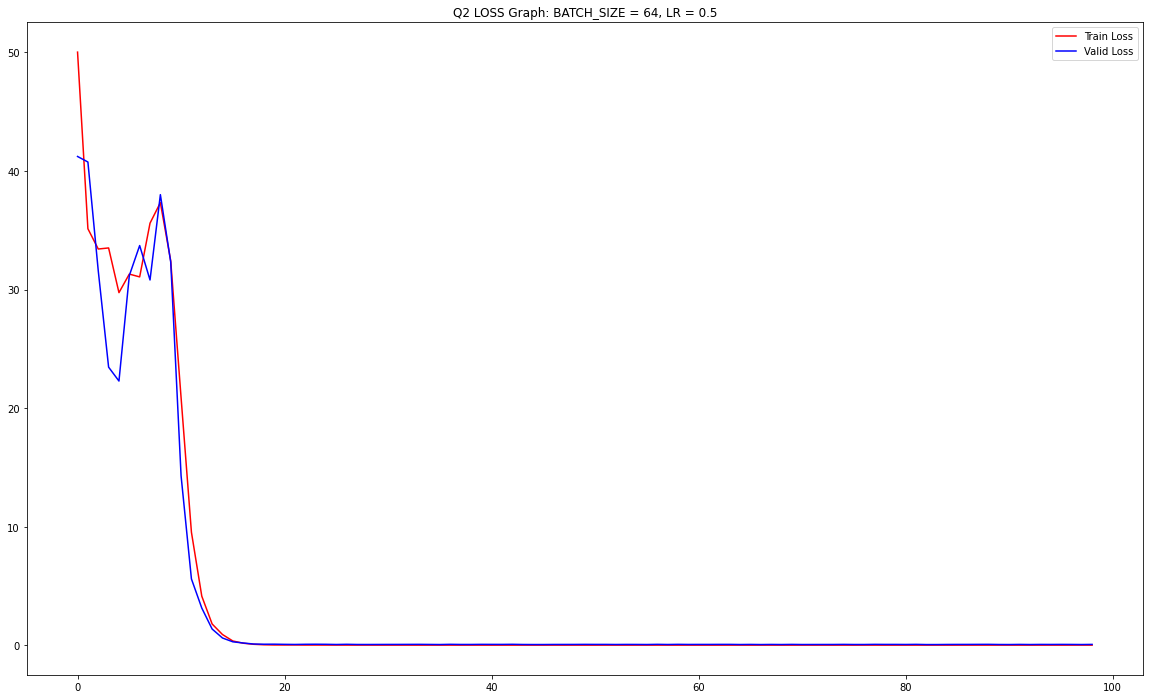

In [346]:
x = np.arange(len(train_loss[1:]))
plt.figure(figsize=(20, 12))
plt.plot(x, train_loss[1:], color='r', label='Train Loss')
plt.plot(x, valid_loss[1:], color='b', label='Valid Loss')
plt.title(f"Q2 LOSS Graph: BATCH_SIZE = {batch_size}, LR = {params['learning_rate']}")
plt.legend()
plt.show()

In [347]:
def test(params, test_loader, path):
    input_size = params['input_size']
    hidden_size = params['hidden_size']
    num_layers = params['num_layers']
    output_size = params['output_size']
    num_outputs = params['num_outputs']
    truths, preds = [[], []], [[], []]
    model = LSTM_multi(input_size, hidden_size, num_layers, output_size, batch_size)
    print(model)
    if MULTI_GPU:
        model = nn.DataParallel(model, device_ids=device_ids)
    model.load_state_dict(torch.load(path)['model'])
    model.to(device)
    
    model.eval()
    for X, y in tqdm(test_loader):
        X = X.to(device)
        for k in range(num_outputs):
            truths[k].extend(y[:, k, :].view(-1).cpu().numpy())
        with torch.no_grad():
            y_hat = model(X)
            for k in range(num_outputs):
                preds[k].extend(y_hat[k, :, :].view(-1).cpu().numpy())
    truths, preds = np.array(truths), np.array(preds)
    for vals in [truths, preds]:
        vals[0] = vals[0] * (test_min_power_range[1] - test_min_power_range[0]) + test_min_power_range[0]
        vals[1] = vals[1] * (test_min_tick_range[1] - test_min_tick_range[0]) + test_min_tick_range[0]
    scores = pd.DataFrame(columns=['MAPE', 'MAE', 'MSE', 'R2 Score'])
    for k in range(num_outputs):
        scores.loc[k, 'MAPE'] = mape(truths[k], preds[k])
        scores.loc[k, 'MAE'] = MAE(truths[k], preds[k])
        scores.loc[k, 'MSE'] = MSE(truths[k], preds[k])
        scores.loc[k, 'R2 Score'] = r2_score(truths[k], preds[k])
    return truths, preds, scores


In [348]:
truths, preds, scores = test(params, test_loader, 'model_min.pth')

LSTM_multi(
  (lstm): LSTM(87, 512, num_layers=50, batch_first=True)
  (linear_pred): Linear(in_features=512, out_features=1, bias=True)
  (linear_time): Linear(in_features=512, out_features=1, bias=True)
)


100%|██████████| 4/4 [00:00<00:00, 10.98it/s]


In [349]:
scores

,MAPE,MAE,MSE,R2 Score
0,51.028919,55467.789062,3731006976.0,-2.068358
1,63.999343,12.520973,282.357544,-0.608161


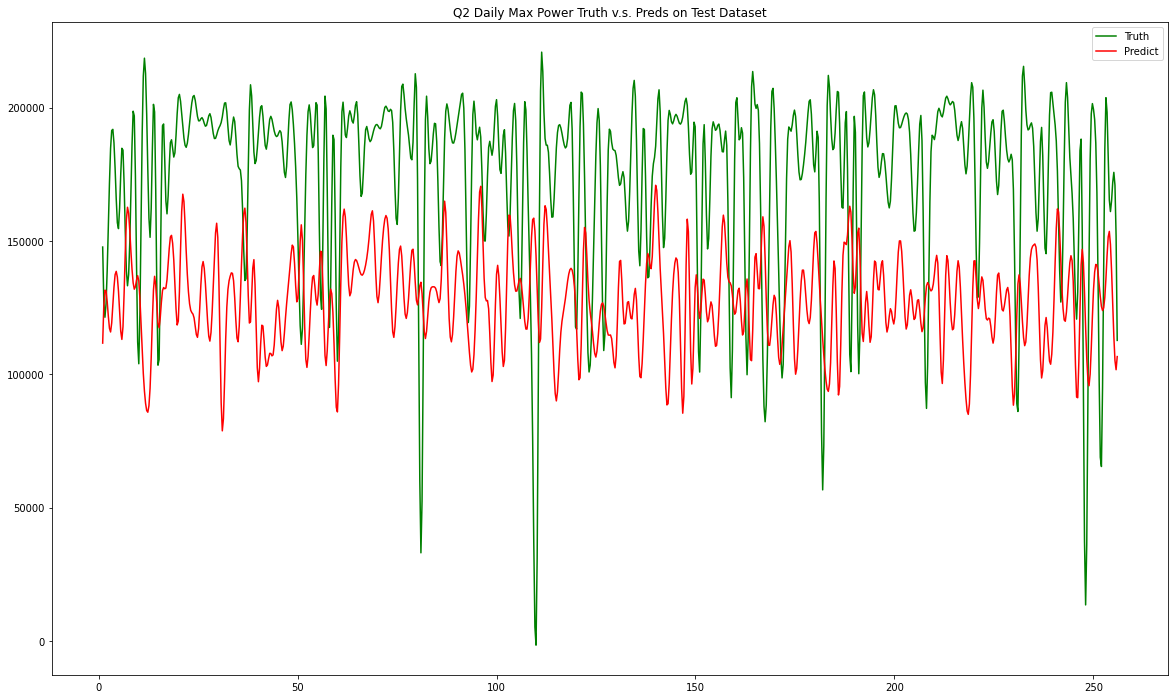

In [350]:
x = [i for i in range(1, len(truths[0]) + 1)]
x_smth = np.linspace(np.min(x), np.max(x), 900)
truths_smth = make_interp_spline(x, truths[0])(x_smth)
preds_smth = make_interp_spline(x, preds[0])(x_smth)
plt.figure(figsize=(20, 12))
plt.plot(x_smth, truths_smth, color='g', label='Truth')
plt.plot(x_smth, preds_smth, color='r', label='Predict')
plt.legend()
plt.title('Q2 Daily Max Power Truth v.s. Preds on Test Dataset')
plt.show()

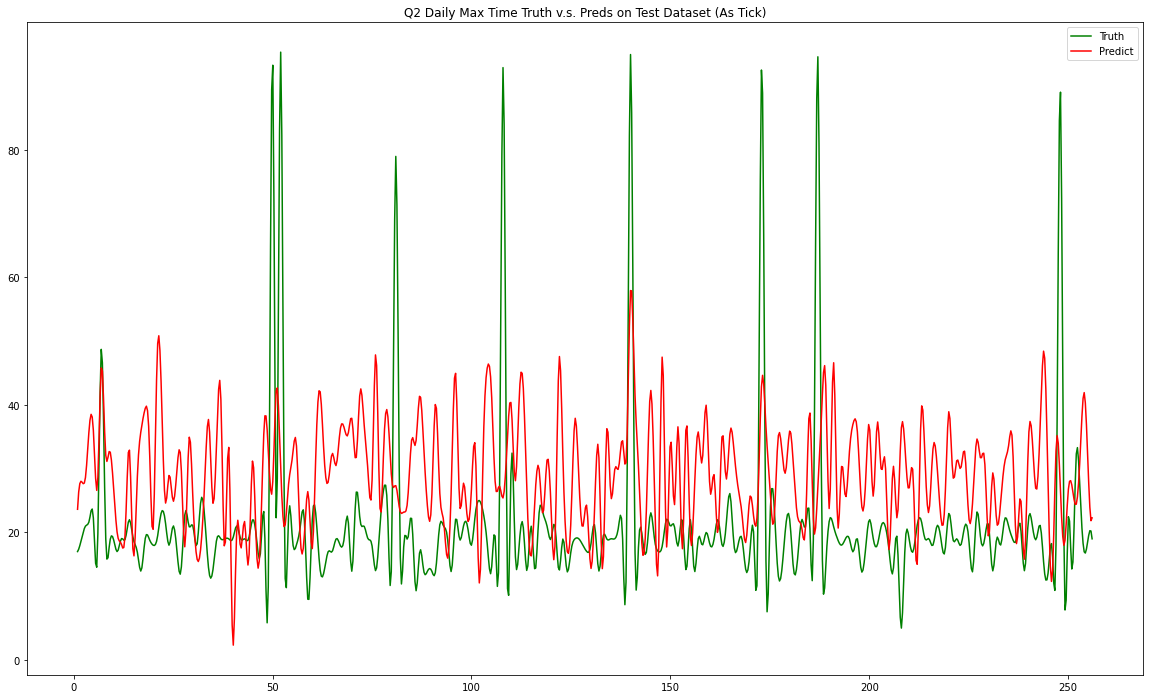

In [351]:
x = [i for i in range(1, len(truths[1]) + 1)]
x_smth = np.linspace(np.min(x), np.max(x), 900)
truths_smth = make_interp_spline(x, truths[1])(x_smth)
preds_smth = make_interp_spline(x, preds[1])(x_smth)
plt.figure(figsize=(20, 12))
plt.plot(x_smth, truths_smth, color='g', label='Truth')
plt.plot(x_smth, preds_smth, color='r', label='Predict')
plt.legend()
plt.title('Q2 Daily Max Time Truth v.s. Preds on Test Dataset (As Tick)')
plt.show()

# Q3